# Insurance Premium Prediction Models: different approaches to predict insurance premiums using various preprocessing techniques and models

## Overview
- The notebook aims to explore different preprocessing and modelling apporaches to this problem
- Different proprocessing pipelines are explored, mainly exploring different imputation, encoding and feature creation techniques 
- GBDT are also explored with CatBoost hyperparaemter tuning  
- So far final public score : 1.04584


## Data Loading and Initial Setup and Loading training and evaluation datasets

In [92]:
import pandas as pd 
import numpy as np 
from feature_engine import encoding, imputation, selection
from sklearn import base, pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_log_error
from catboost import CatBoostRegressor
from sklearn.compose import TransformedTargetRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import accuracy_score, roc_auc_score
from typing import Any, Dict, Union
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import optuna
import seaborn as sns 
from scipy import stats
import xgboost as xgb

In [2]:
df_train = pd.read_csv('df_train.csv')
df_eval = pd.read_csv('df_eval.csv')

### Defining basic preprocessing steps to clean and prepare the data

In [3]:
def tweak_df(df_: pd.DataFrame) -> pd.DataFrame:
    df_ = df_.drop(['id','Policy Start Date'], axis = 1)
    return df_

In [4]:
class TweakdfTransformer(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return tweak_df(X)

    def fit(self, X, y=None): 
        return self

In [5]:
def get_rawX_y(df, y_col):
    return df.drop(columns=[y_col]), df[y_col]

### Feature Type Definition

In [6]:
float_columns = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 
                 'Previous Claims', 'Vehicle Age', 'Credit Score', 
                 'Insurance Duration']

non_float_columns = ['Gender', 'Marital Status', 'Education Level', 
                     'Occupation', 'Location', 'Policy Type', 
                     'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 
                     'Property Type']

## Model 1: Basic Preprocessing Pipeline
A pipeline was created to preprocess data using basic steps. This included data tweaking, mode imputation for categorical variables, median imputation for numerical variables, and one-hot encoding.

In [7]:
df_pl_pre = pipeline.Pipeline([
    ('tweak', TweakdfTransformer()), 
    ('modeImpute', imputation.CategoricalImputer(imputation_method = 'frequent', variables = non_float_columns)),
    ('medianImpute', imputation.MeanMedianImputer(imputation_method = 'median', variables = float_columns)), 
    ('cat', encoding.OneHotEncoder(variables=non_float_columns)),
])

X_train, y_train = get_rawX_y(df_train, 'Premium Amount')
X_eval, y_eval = get_rawX_y(df_eval, 'Premium Amount')

In [8]:
df_pl_pre

Pipeline(steps=[('tweak', TweakdfTransformer()),
                ('modeImpute',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Gender', 'Marital Status',
                                               'Education Level', 'Occupation',
                                               'Location', 'Policy Type',
                                               'Customer Feedback',
                                               'Smoking Status',
                                               'Exercise Frequency',
                                               'Property Type'])),
                ('medianImpute',
                 MeanMedianImputer(variables=['Age', 'Annual Income',
                                              'Number of Dependents',
                                              'Health Score', 'Previous Claims',
                                              'Vehicle Age', 'Credit Score',
                                              'Insurance Duration'])),
                ('cat',
                 OneHotEncoder(variables=['Gender', 'Marital Status',
                                          'Education Level', 'Occupation',
                                          'Location', 'Policy Type',
                                          'Customer Feedback', 'Smoking Status',
                                          'Exercise Frequency',
                                          'Property Type']))])

In [9]:
X_train = df_pl_pre.fit_transform(X_train, y_train)
X_eval = df_pl_pre.transform(X_eval)

In [10]:
# Define the pipeline
df_pl_model_1 = pipeline.Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('model', LinearRegression()) # Base model
])

# Fit the pipeline
df_pl_model_1.fit(X_train, y_train)

# Predictions
y_pred = df_pl_model_1.predict(X_eval)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval, y_pred)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.1681


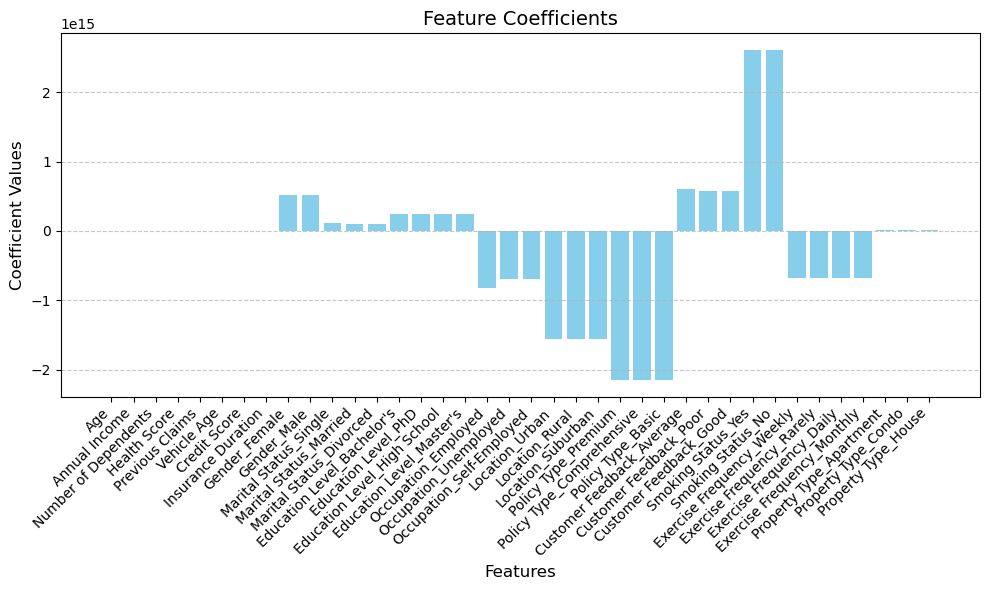

In [11]:
# Access the LinearRegression model
linear_model = df_pl_model_1.named_steps['model']

coefficients =linear_model.coef_
features = X_train.columns

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(features, coefficients, color='skyblue')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficient Values', fontsize=12)
plt.title('Feature Coefficients', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

## Model 2: Log-Transformed Target
A log transformation was applied to the target variable. This transformation aimed to make the target more compatible with the evaluation metric.

In [12]:
# Wrap the pipeline with a target transformer
transformed_pipeline = TransformedTargetRegressor(
    regressor=df_pl_model_1,
    func=np.log1p,   # Transform target: log(1 + y)
    inverse_func=np.expm1  # Inverse transform: exp(y) - 1
)

# Fit the pipeline
transformed_pipeline.fit(X_train, y_train)

# Predictions
y_pred = transformed_pipeline.predict(X_eval)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval, y_pred)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0887


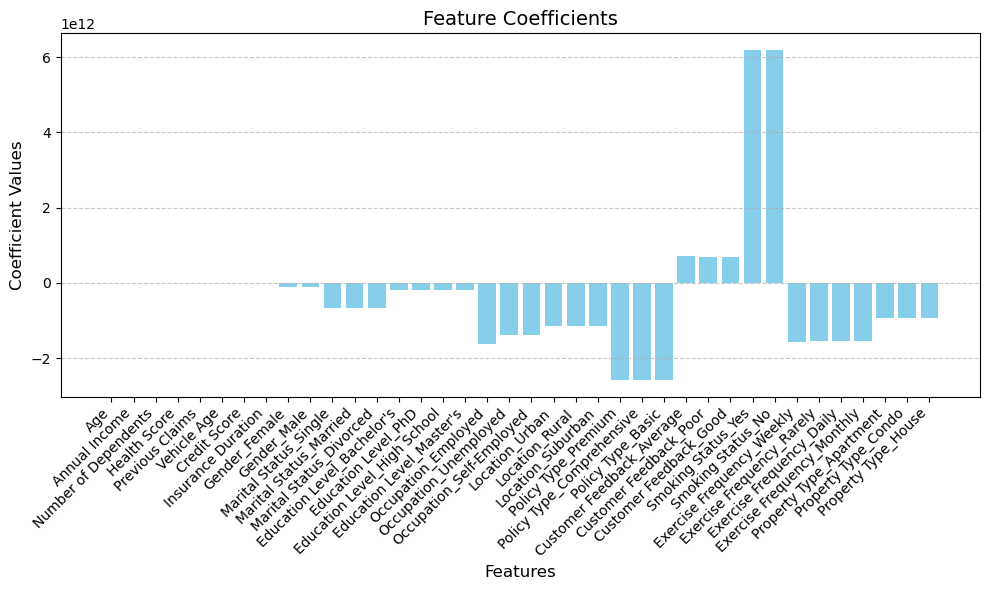

In [13]:
# Access the LinearRegression model
linear_model = transformed_pipeline.regressor_.named_steps['model']

coefficients =linear_model.coef_
features = X_train.columns

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(features, coefficients, color='skyblue')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficient Values', fontsize=12)
plt.title('Feature Coefficients', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

## Model 3: Enhanced Feature Engineering
Cyclic features for temporal data were added. Ordinal and one-hot encoding were implemented to improve feature representation.

In [14]:
def tweak_df_2(df_: pd.DataFrame) -> pd.DataFrame:
    df_['Policy Start Date'] = pd.to_datetime(df_['Policy Start Date'])
    df_['Year'] = df_['Policy Start Date'].dt.year
    df_['Month'] = df_['Policy Start Date'].dt.month
    df_['Day'] = df_['Policy Start Date'].dt.day
    df_['Month_name'] = df_['Policy Start Date'].dt.month_name()
    df_['Day_of_week'] = df_['Policy Start Date'].dt.day_name()
    df_['Week'] = df_['Policy Start Date'].dt.isocalendar().week
    df_['Year_sin'] = np.sin(2 * np.pi * df_['Year'])
    df_['Year_cos'] = np.cos(2 * np.pi * df_['Year'])
    df_['Month_sin'] = np.sin(2 * np.pi * df_['Month'] / 12)
    df_['Month_cos'] = np.cos(2 * np.pi * df_['Month'] / 12)
    df_['Day_sin'] = np.sin(2 * np.pi * df_['Day'] / 31)
    df_['Day_cos'] = np.cos(2 * np.pi * df_['Day'] / 31)
    df_['Group'] = (df_['Year'] - 2020) * 48 + df_['Month'] * 4 + df_['Day'] // 7
    df_ = df_.drop(['id','Policy Start Date', 'Month_name', 'Day_of_week'], axis = 1)
    return df_

In [15]:
class TweakdfTransformer_2(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return tweak_df_2(X)

    def fit(self, X, y=None): 
        return self

In [16]:
onehot_encoding_vars = [
    "Gender",
    "Marital Status",
    "Education Level",
    "Occupation",
    "Location",
    "Policy Type",
    "Customer Feedback",
    "Smoking Status",
    "Exercise Frequency",
    "Property Type",
]


ordinal_encoding_vars = [
    "Day",       # If the days are treated as ordered integers
    "Month",     # If the months are treated as ordered integers (e.g., 1=Jan, 12=Dec)
    "Week",      # If the weeks represent sequential order
]

float_vars = [
    "Age",
    "Annual Income",
    "Number of Dependents",
    "Health Score",
    "Previous Claims",
    "Vehicle Age",
    "Credit Score",
    "Insurance Duration",
    "Year_sin",
    "Year_cos",
    "Month_sin",
    "Month_cos",
    "Day_sin",
    "Day_cos"
]

In [17]:
df_pl_pre_2 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_2()), 
    ('modeImpute', imputation.CategoricalImputer(imputation_method = 'frequent', variables = onehot_encoding_vars)),
    ('medianImpute', imputation.MeanMedianImputer(imputation_method = 'median', variables =  float_vars + ordinal_encoding_vars)), 
    ('cat', encoding.OneHotEncoder(variables=onehot_encoding_vars)),
    #('ord', encoding.OrdinalEncoder(variables=ordinal_encoding_vars))
])

X_train_2, y_train_2 = get_rawX_y(df_train, 'Premium Amount')
X_eval_2, y_eval_2 = get_rawX_y(df_eval, 'Premium Amount')

In [18]:
X_train_2 = df_pl_pre_2.fit_transform(X_train_2, y_train_2)
X_eval_2 = df_pl_pre_2.transform(X_eval_2)

In [19]:
# Fit the pipeline
transformed_pipeline.fit(X_train_2, y_train_2)

# Predictions
y_pred_2 = transformed_pipeline.predict(X_eval_2)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_2, y_pred_2)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0886


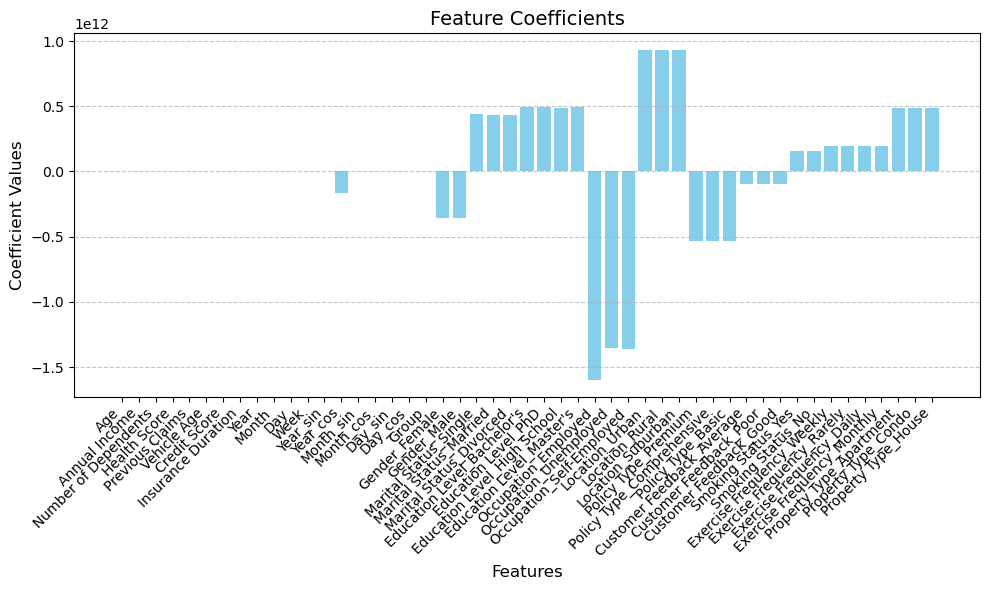

In [20]:
# Access the LinearRegression model
linear_model = transformed_pipeline.regressor_.named_steps['model']

coefficients =linear_model.coef_
features = X_train_2.columns

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(features, coefficients, color='skyblue')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficient Values', fontsize=12)
plt.title('Feature Coefficients', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

## Model 4: XGBoost Implementation : Testing XGBoost with preprocessing from Model 1
XGBoost was tested with preprocessing from Model 1.

In [21]:
df_pl_model_2 = pipeline.Pipeline([
    ('model', xgb.XGBRegressor()) # Base model
])

In [22]:
transformed_pipeline_2 = TransformedTargetRegressor(
    regressor=df_pl_model_2,
    func=np.log1p,   # Transform target: log(1 + y)
    inverse_func=np.expm1  # Inverse transform: exp(y) - 1
)

In [23]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train, y_train)

# Predictions
y_pred = transformed_pipeline_2.predict(X_eval)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval, y_pred)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0566


## Model 5: XGBoost Implementation : Testing XGBoost with preprocessing with cyclic features (model 3 preprocessing)
XGBoost was tested again, this time with preprocessing that included cyclic features. 

In [24]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train_2, y_train_2)

# Predictions
y_pred = transformed_pipeline_2.predict(X_eval_2)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_2, y_pred_2)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0886


## Model 6: Native Categorical Handling
XGBoost's native categorical feature handling was tested. This involved preprocessing data to use XGBoost's capabilities.

In [25]:
def tweak_df_3(df_: pd.DataFrame) -> pd.DataFrame:
    df_['Policy Start Date'] = pd.to_datetime(df_['Policy Start Date'])
    df_['Year'] = df_['Policy Start Date'].dt.year
    df_['Month'] = df_['Policy Start Date'].dt.month
    df_['Day'] = df_['Policy Start Date'].dt.day
    df_['Month_name'] = df_['Policy Start Date'].dt.month_name()
    df_['Day_of_week'] = df_['Policy Start Date'].dt.day_name()
    df_['Week'] = df_['Policy Start Date'].dt.isocalendar().week
    df_['Year_sin'] = np.sin(2 * np.pi * df_['Year'])
    df_['Year_cos'] = np.cos(2 * np.pi * df_['Year'])
    df_['Month_sin'] = np.sin(2 * np.pi * df_['Month'] / 12)
    df_['Month_cos'] = np.cos(2 * np.pi * df_['Month'] / 12)
    df_['Day_sin'] = np.sin(2 * np.pi * df_['Day'] / 31)
    df_['Day_cos'] = np.cos(2 * np.pi * df_['Day'] / 31)
    df_['Group'] = (df_['Year'] - 2020) * 48 + df_['Month'] * 4 + df_['Day'] // 7
    df_ = df_.drop(['id','Policy Start Date', 'Month_name', 'Day_of_week'], axis = 1)
    df_ = df_.drop(['Year', 'Month', 'Day', 'Week'], axis = 1)
    return df_

In [26]:
class TweakdfTransformer_3(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return tweak_df_3(X)

    def fit(self, X, y=None): 
        return self

In [27]:
df_pl_pre_3 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_3()), 
    ('modeImpute', imputation.CategoricalImputer(imputation_method = 'frequent', variables = onehot_encoding_vars)),
    ('medianImpute', imputation.MeanMedianImputer(imputation_method = 'median', variables =  float_vars)), 
    ('cat', encoding.OneHotEncoder(variables=onehot_encoding_vars)),
    #('ord', encoding.OrdinalEncoder(variables=ordinal_encoding_vars))
])

X_train_3, y_train_3 = get_rawX_y(df_train, 'Premium Amount')
X_eval_3, y_eval_3 = get_rawX_y(df_eval, 'Premium Amount')

In [28]:
X_train_3 = df_pl_pre_3.fit_transform(X_train_3, y_train_3)
X_eval_3 = df_pl_pre_3.transform(X_eval_3)

In [29]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train_3, y_train_3)

# Predictions
y_pred_3 = transformed_pipeline_2.predict(X_eval_3)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_3, y_pred_3)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0534


## Model 7: Alternative NaN Treatment for continous variables 
Different approaches to handle missing values were tested. This included median/mode imputations 

In [30]:
def tweak_df_4(df_: pd.DataFrame) -> pd.DataFrame:
    df_['Policy Start Date'] = pd.to_datetime(df_['Policy Start Date'])
    df_['Year'] = df_['Policy Start Date'].dt.year
    df_['Month'] = df_['Policy Start Date'].dt.month
    df_['Day'] = df_['Policy Start Date'].dt.day
    df_['Month_name'] = df_['Policy Start Date'].dt.month_name()
    df_['Day_of_week'] = df_['Policy Start Date'].dt.day_name()
    df_['Week'] = df_['Policy Start Date'].dt.isocalendar().week
    df_['Year_sin'] = np.sin(2 * np.pi * df_['Year'])
    df_['Year_cos'] = np.cos(2 * np.pi * df_['Year'])
    df_['Month_sin'] = np.sin(2 * np.pi * df_['Month'] / 12)
    df_['Month_cos'] = np.cos(2 * np.pi * df_['Month'] / 12)
    df_['Day_sin'] = np.sin(2 * np.pi * df_['Day'] / 31)
    df_['Day_cos'] = np.cos(2 * np.pi * df_['Day'] / 31)
    df_['Group'] = (df_['Year'] - 2020) * 48 + df_['Month'] * 4 + df_['Day'] // 7
    df_ = df_.drop(['id','Policy Start Date', 'Month_name', 'Day_of_week'], axis = 1)
    df_ = df_.drop(['Year', 'Month', 'Day', 'Week'], axis = 1)

    categorical_columns = df_.select_dtypes(include='object').columns
    df_[categorical_columns] = df_[categorical_columns].astype('category')
    df_[categorical_columns] = df_[categorical_columns].astype('category')
    return df_

In [31]:
class TweakdfTransformer_4(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return tweak_df_4(X)

    def fit(self, X, y=None): 
        return self

In [32]:
df_pl_pre_4 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_4()), 
    ('modeImpute', imputation.CategoricalImputer(imputation_method = 'frequent', variables = onehot_encoding_vars)),
    ('medianImpute', imputation.MeanMedianImputer(imputation_method = 'median', variables =  float_vars)), 
    #('ord', encoding.OrdinalEncoder(variables=ordinal_encoding_vars))
])

X_train_4, y_train_4 = get_rawX_y(df_train, 'Premium Amount')
X_eval_4, y_eval_4 = get_rawX_y(df_eval, 'Premium Amount')

In [33]:
X_train_4 = df_pl_pre_4.fit_transform(X_train_4, y_train_4)
X_eval_4 = df_pl_pre_4.transform(X_eval_4)

In [34]:
df_pl_model_3 = pipeline.Pipeline([
    ('model', xgb.XGBRegressor(enable_categorical = True)) # Base model
])

transformed_pipeline_3 = TransformedTargetRegressor(
    regressor=df_pl_model_3,
    func=np.log1p,   # Transform target: log(1 + y)
    inverse_func=np.expm1  # Inverse transform: exp(y) - 1
)

In [35]:
# Fit the pipeline
transformed_pipeline_3.fit(X_train_4, y_train_4)

# Predictions
y_pred_4 = transformed_pipeline_3.predict(X_eval_4)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_4, y_pred_4)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0534


# Model 8 - Another treatement of NaNs
A different strategy for handling NaNs was implemented. This involved using a categorical imputer and one-hot encoding.

In [36]:
df_pl_pre_5 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_3()), 
    ('imputer', imputation.CategoricalImputer(variables = onehot_encoding_vars, fill_value='missing')),
    ('cat', encoding.OneHotEncoder(variables=onehot_encoding_vars)),
])

X_train_5, y_train_5 = get_rawX_y(df_train, 'Premium Amount')
X_eval_5, y_eval_5 = get_rawX_y(df_eval, 'Premium Amount')

In [37]:
X_train_5 = df_pl_pre_5.fit_transform(X_train_5, y_train_5)
X_eval_5 = df_pl_pre_5.transform(X_eval_5)

In [38]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train_5, y_train_5)

# Predictions
y_pred_5 = transformed_pipeline_2.predict(X_eval_5)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_5, y_pred_5)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0471


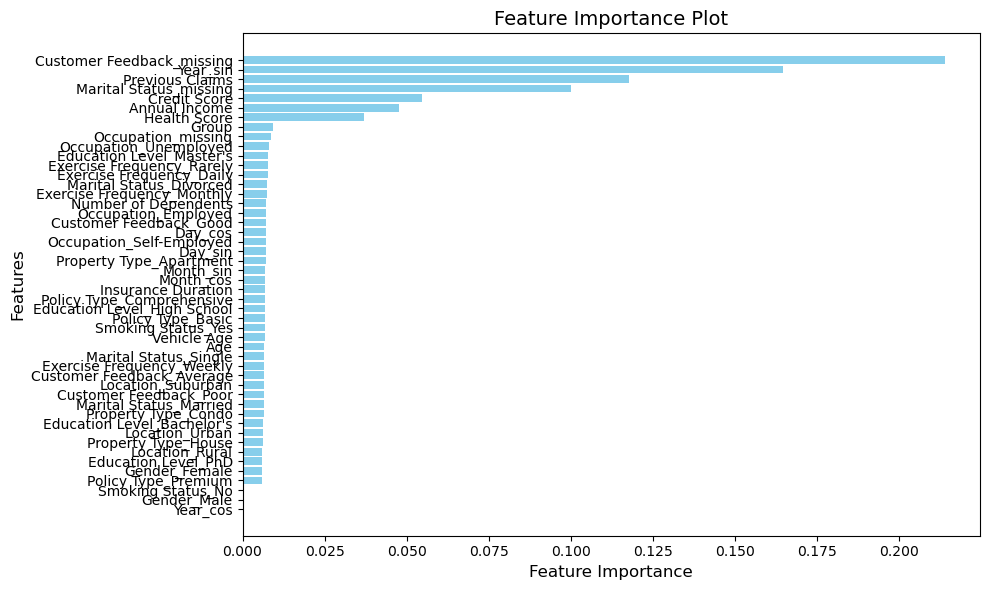

In [39]:
# Extract the XGBRegressor from the pipeline
xgb_model = transformed_pipeline_2.regressor_.named_steps['model']

# Retrieve feature importances
feature_importances = xgb_model.feature_importances_

# Create a dataframe for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_5.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance Plot', fontsize=14)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


## Model 9: Mixed Encoding Strategy
A combination of one-hot and ordinal encoding was used for different features. This aimed to capture both categorical and ordinal information.

In [40]:
onehot_encoding_vars = [
    "Gender",
    "Marital Status",
    "Occupation",
    "Location",
    "Customer Feedback",
    "Smoking Status",
    "Property Type",
]


ordinal_encoding_vars = [
    "Policy Type", 
    "Exercise Frequency",
    "Education Level"
]


float_vars = [
    "Age",
    "Annual Income",
    "Number of Dependents",
    "Health Score",
    "Previous Claims",
    "Vehicle Age",
    "Credit Score",
    "Insurance Duration",
    "Year_sin",
    "Year_cos",
    "Month_sin",
    "Month_cos",
    "Day_sin",
    "Day_cos"
]

In [41]:
df_pl_pre_6 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_3()), 
    ('imputer', imputation.CategoricalImputer(variables = onehot_encoding_vars + ordinal_encoding_vars, fill_value='missing')),
    ('cat', encoding.OneHotEncoder(variables=onehot_encoding_vars)),
    ('ord', encoding.OrdinalEncoder(variables=ordinal_encoding_vars))
])

X_train_6, y_train_6 = get_rawX_y(df_train, 'Premium Amount')
X_eval_6, y_eval_6 = get_rawX_y(df_eval, 'Premium Amount')

In [42]:
X_train_6 = df_pl_pre_6.fit_transform(X_train_6, y_train_6)
X_eval_6 = df_pl_pre_6.transform(X_eval_6)

In [43]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train_6, y_train_6)

# Predictions
y_pred_6 = transformed_pipeline_2.predict(X_eval_6)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_6, y_pred_6)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0470


## Model 10: Missing Value Indicators
Binary flags for missing values in float columns were added. This provided additional information about missing data patterns.

In [44]:
df_pl_pre_7 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_4()), 
    ('imputer_cat', imputation.CategoricalImputer(variables = onehot_encoding_vars + ordinal_encoding_vars, fill_value='missing')),
    ('imputer_float', imputation.ArbitraryNumberImputer(variables = float_vars, arbitrary_number= -1)),
    ('cat', encoding.OneHotEncoder(variables=onehot_encoding_vars)),
    ('ord', encoding.OrdinalEncoder(variables=ordinal_encoding_vars))
])

X_train_7, y_train_7 = get_rawX_y(df_train, 'Premium Amount')
X_eval_7, y_eval_7 = get_rawX_y(df_eval, 'Premium Amount')

In [45]:
X_train_7 = df_pl_pre_7.fit_transform(X_train_7, y_train_7)
X_eval_7 = df_pl_pre_7.transform(X_eval_7)

/Users/ric_carollo/opt/anaconda3/envs/taxi_project/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


In [46]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train_7, y_train_7)

# Predictions
y_pred_7 = transformed_pipeline_2.predict(X_eval_7)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_7, y_pred_7)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0500


## Model 11: Further NaN processing
Features for each NaN in float columns were created. This aimed to capture the presence of missing values as a feature.

In [47]:
def tweak_df_5(df_: pd.DataFrame) -> pd.DataFrame:
    # Date processing
    df_['Policy Start Date'] = pd.to_datetime(df_['Policy Start Date'])
    df_['Year'] = df_['Policy Start Date'].dt.year
    df_['Month'] = df_['Policy Start Date'].dt.month
    df_['Day'] = df_['Policy Start Date'].dt.day
    df_['Month_name'] = df_['Policy Start Date'].dt.month_name()
    df_['Day_of_week'] = df_['Policy Start Date'].dt.day_name()
    df_['Week'] = df_['Policy Start Date'].dt.isocalendar().week
    df_['Year_sin'] = np.sin(2 * np.pi * df_['Year'])
    df_['Year_cos'] = np.cos(2 * np.pi * df_['Year'])
    df_['Month_sin'] = np.sin(2 * np.pi * df_['Month'] / 12)
    df_['Month_cos'] = np.cos(2 * np.pi * df_['Month'] / 12)
    df_['Day_sin'] = np.sin(2 * np.pi * df_['Day'] / 31)
    df_['Day_cos'] = np.cos(2 * np.pi * df_['Day'] / 31)
    df_['Group'] = (df_['Year'] - 2020) * 48 + df_['Month'] * 4 + df_['Day'] // 7

    # Drop unnecessary columns
    df_ = df_.drop(['id', 'Policy Start Date', 'Month_name', 'Day_of_week', 'Year', 'Month', 'Day', 'Week'], axis=1)

    # Handle categorical columns
    categorical_columns = df_.select_dtypes(include='object').columns
    df_[categorical_columns] = df_[categorical_columns].astype('category')

    # Add isNan columns for float-type columns
    float_columns = df_.select_dtypes(include='float').columns.tolist()
    for col in float_columns + ordinal_encoding_vars:
        df_[f'isNan_{col}'] = df_[col].isna().astype(int)
    
    return df_


In [48]:
class TweakdfTransformer_5(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return tweak_df_5(X)

    def fit(self, X, y=None): 
        return self

In [49]:
df_pl_pre_8 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_5()), 
    ('imputer_cat', imputation.CategoricalImputer(variables = onehot_encoding_vars, fill_value='missing')),
    ('cat', encoding.OneHotEncoder(variables=onehot_encoding_vars)),
    ('ord', encoding.OrdinalEncoder(variables=ordinal_encoding_vars)), 
    ('threshold', selection.DropConstantFeatures(missing_values = 'include'))
])

X_train_8, y_train_8 = get_rawX_y(df_train, 'Premium Amount')
X_eval_8, y_eval_8 = get_rawX_y(df_eval, 'Premium Amount')

In [50]:
X_train_8 = df_pl_pre_8.fit_transform(X_train_8, y_train_8)
X_eval_8 = df_pl_pre_8.transform(X_eval_8)

/Users/ric_carollo/opt/anaconda3/envs/taxi_project/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


In [51]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train_8, y_train_8)

# Training predictions
y_train_pred_8 = transformed_pipeline_2.predict(X_train_8)
train_rmsle = root_mean_squared_log_error(y_train_8, y_train_pred_8)

# Evaluation predictions
y_pred_8 = transformed_pipeline_2.predict(X_eval_8)
eval_rmsle = root_mean_squared_log_error(y_eval_8, y_pred_8)

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Evaluation RMSLE: {eval_rmsle:.4f}")

Training RMSLE: 1.0333
Evaluation RMSLE: 1.0470


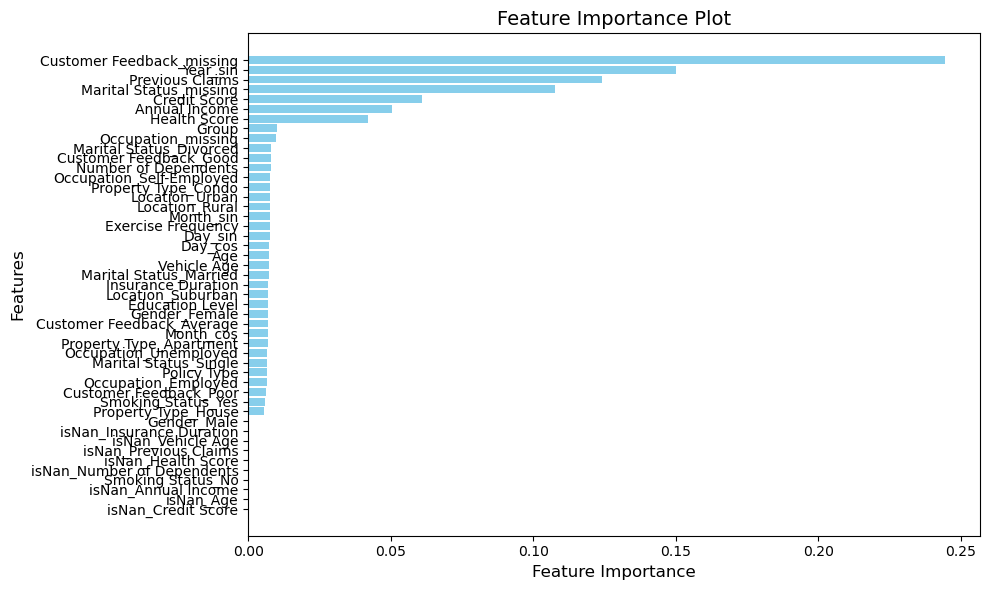

In [52]:
# Extract the XGBRegressor from the pipeline
xgb_model = transformed_pipeline_2.regressor_.named_steps['model']

# Retrieve feature importances
feature_importances = xgb_model.feature_importances_

# Create a dataframe for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_8.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance Plot', fontsize=14)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


In [53]:
feature_importance_df

,Feature,Importance
38,Customer Feedback_missing,0.244414
11,Year_sin,0.150033
6,Previous Claims,0.124068
30,Marital Status_missing,0.107759
8,Credit Score,0.060895
1,Annual Income,0.050332
4,Health Score,0.042012
16,Group,0.010038
33,Occupation_missing,0.009934
29,Marital Status_Divorced,0.007971


## Model 12: Advanced Feature Engineering
Domain-specific composite features and risk scores were created. This included health, financial, demographic, and property features.

In [54]:
def create_health_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create features related to health and lifestyle."""
    
    # Health risk score combining multiple factors
    df['health_risk_score'] = df['Health Score'] * (1 + 
        (df['Smoking Status'] == 'Yes').astype(int) * 0.5 -
        (df['Exercise Frequency'] == 'Daily').astype(int) * 0.2)
    
    # Exercise frequency numeric mapping
    exercise_map = {'Daily': 7, 'Weekly': 3, 'Monthly': 1, 'Never': 0}
    df['exercise_frequency_numeric'] = df['Exercise Frequency'].map(exercise_map)
    
    # Lifestyle score
    df['lifestyle_score'] = (df['exercise_frequency_numeric'] / 7 * 100 - 
                           (df['Smoking Status'] == 'Yes').astype(int) * 30)
    
    return df

def create_financial_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create features related to financial aspects."""
    
    # Income-based features
    df['income_per_dependent'] = df['Annual Income'] / (df['Number of Dependents'] + 1)
    df['income_to_credit_ratio'] = df['Annual Income'] / df['Credit Score']
    
    # Risk factors
    df['financial_risk_score'] = (
        (df['Previous Claims'] + 1) * 
        (1000 / df['Credit Score']) * 
        (df['Insurance Duration'] + 1)
    )
    
    return df

def create_demographic_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create features based on demographic information."""
    
    # Education and occupation combined risk
    education_map = {'High School': 1, "Bachelor's": 2, "Master's": 3, 'PhD': 4}
    df['education_level_numeric'] = df['Education Level'].map(education_map)
    
    # Socioeconomic score
    df['socioeconomic_score'] = (
        df['education_level_numeric'] * 25 +
        (df['Location'] == 'Urban').astype(int) * 10 +
        (df['Credit Score'] / 100)
    )
    
    return df.drop(['education_level_numeric'], axis = 1)

def create_property_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create features related to property and vehicle."""
    
    # Property type risk scoring
    property_risk_map = {'House': 3, 'Apartment': 2, 'Condo': 2, 'Mobile Home': 4}
    df['property_risk_score'] = df['Property Type'].map(property_risk_map)
    
    # Combined asset risk
    df['asset_risk_score'] = (
        df['property_risk_score'] * 
        (df['Vehicle Age'] + 1) * 
        (df['Previous Claims'] + 1)
    )
    
    return df.drop(['property_risk_score'], axis = 1)

def create_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create interaction features between different variables."""
    
    # Risk interaction scores
    df['health_financial_interaction'] = stats.zscore(df['Health Score']) * stats.zscore(df['Credit Score'])
    df['claims_duration_ratio'] = df['Previous Claims'] / (df['Insurance Duration'] + 1)
    
    # Composite risk score
    df['composite_risk_score'] = (
        stats.zscore(df['Health Score']) +
        stats.zscore(df['Credit Score']) -
        stats.zscore(df['Previous Claims']) +
        stats.zscore(df['Insurance Duration'])
    ) / 4
    
    return df

In [55]:
def tweak_df_6(df_: pd.DataFrame) -> pd.DataFrame:
    # Date processing
    df_['Policy Start Date'] = pd.to_datetime(df_['Policy Start Date'])
    df_['Year'] = df_['Policy Start Date'].dt.year
    df_['Month'] = df_['Policy Start Date'].dt.month
    df_['Day'] = df_['Policy Start Date'].dt.day
    df_['Month_name'] = df_['Policy Start Date'].dt.month_name()
    df_['Day_of_week'] = df_['Policy Start Date'].dt.day_name()
    df_['Week'] = df_['Policy Start Date'].dt.isocalendar().week
    df_['Year_sin'] = np.sin(2 * np.pi * df_['Year'])
    df_['Year_cos'] = np.cos(2 * np.pi * df_['Year'])
    df_['Month_sin'] = np.sin(2 * np.pi * df_['Month'] / 12)
    df_['Month_cos'] = np.cos(2 * np.pi * df_['Month'] / 12)
    df_['Day_sin'] = np.sin(2 * np.pi * df_['Day'] / 31)
    df_['Day_cos'] = np.cos(2 * np.pi * df_['Day'] / 31)
    df_['Group'] = (df_['Year'] - 2020) * 48 + df_['Month'] * 4 + df_['Day'] // 7

    # Drop unnecessary columns
    df_ = df_.drop(['id', 'Policy Start Date', 'Month_name', 'Day_of_week', 'Year', 'Month', 'Day', 'Week'], axis=1)

    df_ = (df_.pipe(create_health_features)
           .pipe(create_financial_features)
           .pipe(create_demographic_features)
           .pipe(create_property_features)
           .pipe(create_interaction_features))

    # Handle categorical columns
    categorical_columns = df_.select_dtypes(include='object').columns
    df_[categorical_columns] = df_[categorical_columns].astype('category')
    
    return df_


In [56]:
onehot_encoding_vars = [
    "Gender",
    "Marital Status",
    "Occupation",
    "Location",
    "Customer Feedback",
    "Smoking Status",
    "Property Type",
]

ordinal_encoding_vars = [
    "Policy Type", 
    "Exercise Frequency",
    "Education Level",
]

float_vars = [
    "Age",
    "Annual Income",
    "Number of Dependents",
    "Health Score",
    "Previous Claims",
    "Vehicle Age",
    "Credit Score",
    "Insurance Duration",
    "Year_sin",
    "Year_cos",
    "Month_sin",
    "Month_cos",
    "Day_sin",
    "Day_cos",
    "Group",
    "health_risk_score",
    "lifestyle_score",
    "income_per_dependent",
    "income_to_credit_ratio",
    "financial_risk_score",
    "socioeconomic_score",
    "asset_risk_score",
    "health_financial_interaction",
    "claims_duration_ratio",
    "composite_risk_score"
]

In [57]:
class TweakdfTransformer_6(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return tweak_df_6(X)

    def fit(self, X, y=None): 
        return self

In [58]:
df_pl_pre_6 = pipeline.Pipeline([
    ('tweak', TweakdfTransformer_6()), 
    ('imputer_cat', imputation.CategoricalImputer(variables = onehot_encoding_vars, fill_value='missing')),
    ('imputer_float', imputation.ArbitraryNumberImputer(variables = float_vars, arbitrary_number= -1)),
    ('cat', encoding.OneHotEncoder(variables=onehot_encoding_vars)),
    ('ord', encoding.OrdinalEncoder(variables=ordinal_encoding_vars)), 
    ('threshold', selection.DropConstantFeatures(missing_values = 'include'))
])

X_train_9, y_train_9 = get_rawX_y(df_train, 'Premium Amount')
X_eval_9, y_eval_9 = get_rawX_y(df_eval, 'Premium Amount')

In [59]:
X_train_9 = df_pl_pre_6.fit_transform(X_train_9, y_train_9)
X_eval_9 = df_pl_pre_6.transform(X_eval_9)

/Users/ric_carollo/opt/anaconda3/envs/taxi_project/lib/python3.11/site-packages/feature_engine/encoding/ordinal.py:208: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = y.groupby(X[var]).mean()  # type: ignore


In [60]:
# Fit the pipeline
transformed_pipeline_2.fit(X_train_9, y_train_9)

# Training predictions
y_train_pred_9 = transformed_pipeline_2.predict(X_train_9)
train_rmsle = root_mean_squared_log_error(y_train_9, y_train_pred_9)

# Evaluation predictions
y_pred_9 = transformed_pipeline_2.predict(X_eval_9)
eval_rmsle = root_mean_squared_log_error(y_eval_9, y_pred_9)

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Evaluation RMSLE: {eval_rmsle:.4f}")

Training RMSLE: 1.0350
Evaluation RMSLE: 1.0491


In [61]:
final_model = xgb.XGBRegressor(objective = "reg:squaredlogerror")

# Fit the pipeline
final_model.fit(X_train_9, y_train_9)

# Training predictions
y_train_pred_9 = final_model.predict(X_train_9)
train_rmsle = root_mean_squared_log_error(y_train_9, y_train_pred_9)

# Evaluation predictions
y_pred_9 = final_model.predict(X_eval_9)
eval_rmsle = root_mean_squared_log_error(y_eval_9, y_pred_9)

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Evaluation RMSLE: {eval_rmsle:.4f}")

Training RMSLE: 1.0853
Evaluation RMSLE: 1.0850


## Model 12: CatBoost Implementation
CatBoost was tested with transformed target and hyperparameter optimisation.

In [113]:
df_pl_model_5 = pipeline.Pipeline([
    ('model', CatBoostRegressor(
        n_estimators=1000,  # Increased number of estimators
        early_stopping_rounds=50,
        verbose=3,  # This is equivalent to silent=True
        eval_metric='MSLE',  # You can change this to match your needs
    ))
])

# Add target transformation
transformed_pipeline_4 = TransformedTargetRegressor(
    regressor=df_pl_model_5,
    func=np.log1p,   # Transform target: log(1 + y)
    inverse_func=np.expm1  # Inverse transform: exp(y) - 1
)

In [111]:
# When fitting, you'll need to provide an evaluation set 
transformed_pipeline_4.fit(X_train_9, y_train_9,
                         model__eval_set=[(X_eval_9, y_eval_9)])

Learning rate set to 0.149662
0:	learn: 0.0269563	test: 22.0400287	best: 22.0400287 (0)	total: 156ms	remaining: 2m 35s
3:	learn: 0.0262433	test: 22.0346427	best: 22.0346427 (3)	total: 359ms	remaining: 1m 29s
6:	learn: 0.0258747	test: 22.0318153	best: 22.0318153 (6)	total: 514ms	remaining: 1m 12s
9:	learn: 0.0256709	test: 22.0301189	best: 22.0301189 (9)	total: 663ms	remaining: 1m 5s
12:	learn: 0.0255337	test: 22.0289817	best: 22.0289817 (12)	total: 800ms	remaining: 1m
15:	learn: 0.0254375	test: 22.0279797	best: 22.0279797 (15)	total: 958ms	remaining: 58.9s
18:	learn: 0.0253625	test: 22.0273610	best: 22.0273610 (18)	total: 1.18s	remaining: 1m
21:	learn: 0.0253237	test: 22.0269772	best: 22.0269772 (21)	total: 1.32s	remaining: 58.6s
24:	learn: 0.0252826	test: 22.0265773	best: 22.0265773 (24)	total: 1.46s	remaining: 57s
27:	learn: 0.0252605	test: 22.0263531	best: 22.0263531 (27)	total: 1.64s	remaining: 57s
30:	learn: 0.0252458	test: 22.0262075	best: 22.0262075 (30)	total: 1.81s	remaining: 5

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('model',
                                                      <catboost.core.CatBoostRegressor object at 0x150e31090>)]))

In [112]:
y_pred = transformed_pipeline_4.predict(X_eval_9)

# Evaluate RMSLE
rmsle = root_mean_squared_log_error(y_eval_9, y_pred)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0471


In [114]:
model = transformed_pipeline_4.regressor_.named_steps['model']
scores = model.get_feature_importance()

AttributeError: 'TransformedTargetRegressor' object has no attribute 'regressor_'

In [118]:
def objective(trial):
    params = {
        "iterations": 500,  
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "early_stopping_rounds": 50,  # Early stopping for overfitting control
        "eval_metric": 'MSLE'
    }

    model = CatBoostRegressor(**params, silent=False)
    transformed_pipeline_4 = TransformedTargetRegressor(
        regressor=model,
        func=np.log1p,   # Transform target: log(1 + y)
        inverse_func=np.expm1  # Inverse transform: exp(y) - 1)
    )
    transformed_pipeline_4.fit(
        X_train_9, 
        y_train_9, 
        eval_set=(X_eval_9, y_eval_9),  # Validation set for early stopping
        verbose=100  # Print progress every 100 iterations
    )
    
    predictions = transformed_pipeline_4.predict(X_eval_9)
    rmse = root_mean_squared_log_error(y_eval_9, predictions)
    return rmse

In [119]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=2 * 60 * 60)

[I 2024-12-27 09:28:29,527] A new study created in memory with name: no-name-b227bfd3-7254-4f90-ad14-6ef0da830ceb


0:	learn: 0.0271653	test: 22.0414690	best: 22.0414690 (0)	total: 233ms	remaining: 1m 56s
100:	learn: 0.0250421	test: 22.0250951	best: 22.0250951 (100)	total: 5.82s	remaining: 23s
200:	learn: 0.0248479	test: 22.0248323	best: 22.0248289 (170)	total: 11.3s	remaining: 16.9s
300:	learn: 0.0246808	test: 22.0246237	best: 22.0246237 (300)	total: 17.1s	remaining: 11.3s
400:	learn: 0.0245209	test: 22.0245136	best: 22.0245062 (383)	total: 22.6s	remaining: 5.58s
499:	learn: 0.0243600	test: 22.0244738	best: 22.0244711 (494)	total: 28.1s	remaining: 0us

bestTest = 22.02447114
bestIteration = 494

Shrink model to first 495 iterations.


[I 2024-12-27 09:28:58,710] Trial 0 finished with value: 1.0474138358067684 and parameters: {'learning_rate': 0.05332035115750677, 'depth': 10, 'subsample': 0.16436639922394541, 'colsample_bylevel': 0.7048898349873166, 'min_data_in_leaf': 72}. Best is trial 0 with value: 1.0474138358067684.


0:	learn: 0.0271534	test: 22.0413543	best: 22.0413543 (0)	total: 105ms	remaining: 52.6s
100:	learn: 0.0250826	test: 22.0248787	best: 22.0248734 (98)	total: 4.99s	remaining: 19.7s
200:	learn: 0.0249553	test: 22.0246602	best: 22.0246602 (200)	total: 9.92s	remaining: 14.8s
300:	learn: 0.0248334	test: 22.0244899	best: 22.0244842 (278)	total: 15.2s	remaining: 10.1s


[I 2024-12-27 09:29:17,717] Trial 1 finished with value: 1.0472023658690488 and parameters: {'learning_rate': 0.05931251073962426, 'depth': 9, 'subsample': 0.1977699313825344, 'colsample_bylevel': 0.7959360384182924, 'min_data_in_leaf': 97}. Best is trial 1 with value: 1.0472023658690488.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02447569
bestIteration = 301

Shrink model to first 302 iterations.
0:	learn: 0.0273575	test: 22.0428049	best: 22.0428049 (0)	total: 44.7ms	remaining: 22.3s
100:	learn: 0.0270140	test: 22.0404196	best: 22.0404196 (100)	total: 3.04s	remaining: 12s
200:	learn: 0.0267384	test: 22.0384602	best: 22.0384602 (200)	total: 5.99s	remaining: 8.91s
300:	learn: 0.0265197	test: 22.0368713	best: 22.0368713 (300)	total: 8.89s	remaining: 5.88s
400:	learn: 0.0263369	test: 22.0355135	best: 22.0355135 (400)	total: 11.8s	remaining: 2.92s


[I 2024-12-27 09:29:33,526] Trial 2 finished with value: 1.0692786520306738 and parameters: {'learning_rate': 0.001512499642916839, 'depth': 6, 'subsample': 0.12047327236446612, 'colsample_bylevel': 0.6479016841509465, 'min_data_in_leaf': 29}. Best is trial 1 with value: 1.0472023658690488.


499:	learn: 0.0261897	test: 22.0343858	best: 22.0343858 (499)	total: 15s	remaining: 0us

bestTest = 22.0343858
bestIteration = 499

0:	learn: 0.0273521	test: 22.0427721	best: 22.0427721 (0)	total: 53.1ms	remaining: 26.5s
100:	learn: 0.0267838	test: 22.0389567	best: 22.0389567 (100)	total: 4.44s	remaining: 17.5s
200:	learn: 0.0264899	test: 22.0368729	best: 22.0368729 (200)	total: 8.33s	remaining: 12.4s
300:	learn: 0.0263197	test: 22.0356317	best: 22.0356317 (300)	total: 12.3s	remaining: 8.16s
400:	learn: 0.0261938	test: 22.0346849	best: 22.0346849 (400)	total: 17s	remaining: 4.18s


[I 2024-12-27 09:29:55,259] Trial 3 finished with value: 1.068902742082095 and parameters: {'learning_rate': 0.005626396439843264, 'depth': 3, 'subsample': 0.7712392745906247, 'colsample_bylevel': 0.5672196921404895, 'min_data_in_leaf': 54}. Best is trial 1 with value: 1.0472023658690488.


499:	learn: 0.0260889	test: 22.0338622	best: 22.0338622 (499)	total: 21s	remaining: 0us

bestTest = 22.03386221
bestIteration = 499

0:	learn: 0.0273573	test: 22.0428057	best: 22.0428057 (0)	total: 92.8ms	remaining: 46.3s
100:	learn: 0.0269821	test: 22.0402064	best: 22.0402064 (100)	total: 6.59s	remaining: 26s
200:	learn: 0.0266923	test: 22.0381602	best: 22.0381602 (200)	total: 15.3s	remaining: 22.8s
300:	learn: 0.0264630	test: 22.0365007	best: 22.0365007 (300)	total: 34.1s	remaining: 22.6s
400:	learn: 0.0262784	test: 22.0351337	best: 22.0351337 (400)	total: 45.1s	remaining: 11.1s
499:	learn: 0.0261236	test: 22.0339486	best: 22.0339486 (499)	total: 52.2s	remaining: 0us

bestTest = 22.03394855
bestIteration = 499



[I 2024-12-27 09:30:48,633] Trial 4 finished with value: 1.0680393055348087 and parameters: {'learning_rate': 0.0018292657856980147, 'depth': 6, 'subsample': 0.9904481996795564, 'colsample_bylevel': 0.4324303669569306, 'min_data_in_leaf': 49}. Best is trial 1 with value: 1.0472023658690488.


0:	learn: 0.0273571	test: 22.0428032	best: 22.0428032 (0)	total: 210ms	remaining: 1m 44s
100:	learn: 0.0269726	test: 22.0401342	best: 22.0401342 (100)	total: 9.1s	remaining: 36s
200:	learn: 0.0266571	test: 22.0378930	best: 22.0378930 (200)	total: 20s	remaining: 29.7s
300:	learn: 0.0263951	test: 22.0359934	best: 22.0359934 (300)	total: 29.4s	remaining: 19.4s
400:	learn: 0.0261853	test: 22.0344328	best: 22.0344328 (400)	total: 37.9s	remaining: 9.35s
499:	learn: 0.0260144	test: 22.0331380	best: 22.0331380 (499)	total: 47s	remaining: 0us

bestTest = 22.03313799
bestIteration = 499



[I 2024-12-27 09:31:37,762] Trial 5 finished with value: 1.0651655911493993 and parameters: {'learning_rate': 0.0014382417656100136, 'depth': 10, 'subsample': 0.6903233020621022, 'colsample_bylevel': 0.28118296833014295, 'min_data_in_leaf': 6}. Best is trial 1 with value: 1.0472023658690488.


0:	learn: 0.0273442	test: 22.0427117	best: 22.0427117 (0)	total: 129ms	remaining: 1m 4s
100:	learn: 0.0261922	test: 22.0343864	best: 22.0343864 (100)	total: 7.2s	remaining: 28.5s
200:	learn: 0.0256701	test: 22.0302144	best: 22.0302144 (200)	total: 13.1s	remaining: 19.6s
300:	learn: 0.0254241	test: 22.0280700	best: 22.0280700 (300)	total: 20s	remaining: 13.2s
400:	learn: 0.0252987	test: 22.0269215	best: 22.0269215 (400)	total: 25.9s	remaining: 6.41s
499:	learn: 0.0252257	test: 22.0262707	best: 22.0262707 (499)	total: 31.5s	remaining: 0us

bestTest = 22.02627074
bestIteration = 499



[I 2024-12-27 09:32:10,979] Trial 6 finished with value: 1.0496395953317903 and parameters: {'learning_rate': 0.004635635193521593, 'depth': 10, 'subsample': 0.09183926771254274, 'colsample_bylevel': 0.8436201485410149, 'min_data_in_leaf': 81}. Best is trial 1 with value: 1.0472023658690488.


0:	learn: 0.0273578	test: 22.0428090	best: 22.0428090 (0)	total: 65.9ms	remaining: 32.9s
100:	learn: 0.0270682	test: 22.0408973	best: 22.0408973 (100)	total: 5.14s	remaining: 20.3s
200:	learn: 0.0268605	test: 22.0394865	best: 22.0394865 (200)	total: 10.9s	remaining: 16.3s
300:	learn: 0.0267116	test: 22.0384397	best: 22.0384397 (300)	total: 16.9s	remaining: 11.2s
400:	learn: 0.0265999	test: 22.0376482	best: 22.0376482 (400)	total: 22.3s	remaining: 5.5s


[I 2024-12-27 09:32:41,452] Trial 7 finished with value: 1.0774483342528167 and parameters: {'learning_rate': 0.0019313251835356468, 'depth': 3, 'subsample': 0.7190204106793161, 'colsample_bylevel': 0.9575036126641135, 'min_data_in_leaf': 83}. Best is trial 1 with value: 1.0472023658690488.


499:	learn: 0.0265113	test: 22.0370226	best: 22.0370226 (499)	total: 29.4s	remaining: 0us

bestTest = 22.03702263
bestIteration = 499

0:	learn: 0.0273504	test: 22.0427562	best: 22.0427562 (0)	total: 129ms	remaining: 1m 4s
100:	learn: 0.0265619	test: 22.0371645	best: 22.0371645 (100)	total: 4.83s	remaining: 19.1s
200:	learn: 0.0261227	test: 22.0338594	best: 22.0338594 (200)	total: 9.49s	remaining: 14.1s
300:	learn: 0.0258525	test: 22.0317079	best: 22.0317079 (300)	total: 15s	remaining: 9.93s
400:	learn: 0.0256785	test: 22.0302705	best: 22.0302705 (400)	total: 20.1s	remaining: 4.97s


[I 2024-12-27 09:33:08,761] Trial 8 finished with value: 1.056589824272284 and parameters: {'learning_rate': 0.004138596794201563, 'depth': 6, 'subsample': 0.33327467589405146, 'colsample_bylevel': 0.663581847476672, 'min_data_in_leaf': 20}. Best is trial 1 with value: 1.0472023658690488.


499:	learn: 0.0255591	test: 22.0292550	best: 22.0292550 (499)	total: 25.3s	remaining: 0us

bestTest = 22.02925505
bestIteration = 499

0:	learn: 0.0273581	test: 22.0428124	best: 22.0428124 (0)	total: 191ms	remaining: 1m 35s
100:	learn: 0.0271896	test: 22.0417792	best: 22.0417792 (100)	total: 4.95s	remaining: 19.5s
200:	learn: 0.0270743	test: 22.0410310	best: 22.0410310 (200)	total: 9.3s	remaining: 13.8s
300:	learn: 0.0269844	test: 22.0404370	best: 22.0404370 (300)	total: 13.2s	remaining: 8.7s
400:	learn: 0.0269142	test: 22.0399621	best: 22.0399621 (400)	total: 16.5s	remaining: 4.08s


[I 2024-12-27 09:33:30,082] Trial 9 finished with value: 1.0852428028496988 and parameters: {'learning_rate': 0.00535090351378207, 'depth': 1, 'subsample': 0.8601682827291186, 'colsample_bylevel': 0.6544518650039939, 'min_data_in_leaf': 17}. Best is trial 1 with value: 1.0472023658690488.


499:	learn: 0.0268550	test: 22.0395567	best: 22.0395567 (499)	total: 20.1s	remaining: 0us

bestTest = 22.03955669
bestIteration = 499

0:	learn: 0.0272537	test: 22.0420810	best: 22.0420810 (0)	total: 149ms	remaining: 1m 14s
100:	learn: 0.0251699	test: 22.0261936	best: 22.0261936 (100)	total: 6.18s	remaining: 24.4s
200:	learn: 0.0250190	test: 22.0250885	best: 22.0250789 (199)	total: 11.6s	remaining: 17.2s
300:	learn: 0.0249149	test: 22.0247470	best: 22.0247470 (300)	total: 17s	remaining: 11.3s
400:	learn: 0.0248185	test: 22.0246095	best: 22.0245957 (390)	total: 22.3s	remaining: 5.5s


[I 2024-12-27 09:33:58,841] Trial 10 finished with value: 1.047757422835683 and parameters: {'learning_rate': 0.08291779395226803, 'depth': 8, 'subsample': 0.42765956116073056, 'colsample_bylevel': 0.17224856142431705, 'min_data_in_leaf': 95}. Best is trial 1 with value: 1.0472023658690488.


499:	learn: 0.0247303	test: 22.0245453	best: 22.0245368 (457)	total: 27s	remaining: 0us

bestTest = 22.02453685
bestIteration = 457

Shrink model to first 458 iterations.
0:	learn: 0.0271830	test: 22.0415854	best: 22.0415854 (0)	total: 91.7ms	remaining: 45.8s
100:	learn: 0.0251350	test: 22.0250426	best: 22.0250426 (100)	total: 5.08s	remaining: 20.1s
200:	learn: 0.0250528	test: 22.0246987	best: 22.0246987 (200)	total: 10.1s	remaining: 15s
300:	learn: 0.0249847	test: 22.0244841	best: 22.0244756 (293)	total: 15s	remaining: 9.94s
400:	learn: 0.0249129	test: 22.0243278	best: 22.0243251 (394)	total: 19.9s	remaining: 4.91s


[I 2024-12-27 09:34:24,818] Trial 11 finished with value: 1.0469133902980863 and parameters: {'learning_rate': 0.05461474238969221, 'depth': 8, 'subsample': 0.24711689500089598, 'colsample_bylevel': 0.8544729865489936, 'min_data_in_leaf': 69}. Best is trial 11 with value: 1.0469133902980863.


499:	learn: 0.0248519	test: 22.0242533	best: 22.0242491 (490)	total: 24.8s	remaining: 0us

bestTest = 22.02424906
bestIteration = 490

Shrink model to first 491 iterations.
0:	learn: 0.0272748	test: 22.0422163	best: 22.0422163 (0)	total: 65.9ms	remaining: 32.9s
100:	learn: 0.0252557	test: 22.0262572	best: 22.0262572 (100)	total: 5.09s	remaining: 20.1s
200:	learn: 0.0251416	test: 22.0251288	best: 22.0251288 (200)	total: 10.5s	remaining: 15.6s
300:	learn: 0.0250947	test: 22.0248506	best: 22.0248506 (300)	total: 15.5s	remaining: 10.3s
400:	learn: 0.0250593	test: 22.0247162	best: 22.0247162 (400)	total: 20.6s	remaining: 5.08s


[I 2024-12-27 09:34:51,684] Trial 12 finished with value: 1.0474330096251112 and parameters: {'learning_rate': 0.025443373698051087, 'depth': 8, 'subsample': 0.29610840767892066, 'colsample_bylevel': 0.9834063747518242, 'min_data_in_leaf': 98}. Best is trial 11 with value: 1.0469133902980863.


499:	learn: 0.0250268	test: 22.0246105	best: 22.0246105 (499)	total: 26s	remaining: 0us

bestTest = 22.02461048
bestIteration = 499

0:	learn: 0.0272815	test: 22.0422832	best: 22.0422832 (0)	total: 139ms	remaining: 1m 9s
100:	learn: 0.0252671	test: 22.0264058	best: 22.0264058 (100)	total: 7.08s	remaining: 28s
200:	learn: 0.0251376	test: 22.0250867	best: 22.0250867 (200)	total: 13.9s	remaining: 20.7s
300:	learn: 0.0250921	test: 22.0248306	best: 22.0248306 (300)	total: 20.5s	remaining: 13.6s
400:	learn: 0.0250566	test: 22.0246537	best: 22.0246521 (398)	total: 26.7s	remaining: 6.6s


[I 2024-12-27 09:35:25,539] Trial 13 finished with value: 1.0473803390703678 and parameters: {'learning_rate': 0.02523578252651638, 'depth': 8, 'subsample': 0.5236181406695197, 'colsample_bylevel': 0.7963961368071658, 'min_data_in_leaf': 61}. Best is trial 11 with value: 1.0469133902980863.


499:	learn: 0.0250225	test: 22.0245351	best: 22.0245351 (499)	total: 32.8s	remaining: 0us

bestTest = 22.02453515
bestIteration = 499

0:	learn: 0.0272772	test: 22.0422483	best: 22.0422483 (0)	total: 62.2ms	remaining: 31s
100:	learn: 0.0252571	test: 22.0262617	best: 22.0262617 (100)	total: 4.92s	remaining: 19.4s
200:	learn: 0.0251388	test: 22.0251412	best: 22.0251412 (200)	total: 9.79s	remaining: 14.6s
300:	learn: 0.0250952	test: 22.0249242	best: 22.0249242 (300)	total: 15.1s	remaining: 9.98s
400:	learn: 0.0250580	test: 22.0247719	best: 22.0247708 (399)	total: 20s	remaining: 4.93s


[I 2024-12-27 09:35:51,618] Trial 14 finished with value: 1.0474906624991358 and parameters: {'learning_rate': 0.025977893198086712, 'depth': 8, 'subsample': 0.2544178472586879, 'colsample_bylevel': 0.8368155872803674, 'min_data_in_leaf': 41}. Best is trial 11 with value: 1.0469133902980863.


499:	learn: 0.0250260	test: 22.0246915	best: 22.0246915 (499)	total: 25.2s	remaining: 0us

bestTest = 22.02469148
bestIteration = 499

0:	learn: 0.0272108	test: 22.0417757	best: 22.0417757 (0)	total: 98.3ms	remaining: 49.1s
100:	learn: 0.0251121	test: 22.0251158	best: 22.0251158 (100)	total: 7.17s	remaining: 28.3s
200:	learn: 0.0249978	test: 22.0246707	best: 22.0246696 (190)	total: 13.7s	remaining: 20.3s
300:	learn: 0.0248927	test: 22.0244552	best: 22.0244552 (300)	total: 20.8s	remaining: 13.7s
400:	learn: 0.0247919	test: 22.0242502	best: 22.0242423 (386)	total: 27.8s	remaining: 6.87s


[I 2024-12-27 09:36:27,026] Trial 15 finished with value: 1.0468733351127715 and parameters: {'learning_rate': 0.04910361007666726, 'depth': 9, 'subsample': 0.4472007366391083, 'colsample_bylevel': 0.4468497857918529, 'min_data_in_leaf': 69}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0247017	test: 22.0241805	best: 22.0241688 (491)	total: 34.3s	remaining: 0us

bestTest = 22.02416884
bestIteration = 491

Shrink model to first 492 iterations.
0:	learn: 0.0273287	test: 22.0426076	best: 22.0426076 (0)	total: 133ms	remaining: 1m 6s
100:	learn: 0.0257640	test: 22.0310299	best: 22.0310299 (100)	total: 6.27s	remaining: 24.8s
200:	learn: 0.0253759	test: 22.0275891	best: 22.0275891 (200)	total: 11.9s	remaining: 17.6s
300:	learn: 0.0252591	test: 22.0264472	best: 22.0264472 (300)	total: 18.1s	remaining: 11.9s
400:	learn: 0.0252078	test: 22.0259008	best: 22.0259008 (400)	total: 23.4s	remaining: 5.78s


[I 2024-12-27 09:36:57,282] Trial 16 finished with value: 1.0491017557097781 and parameters: {'learning_rate': 0.012611726502454044, 'depth': 7, 'subsample': 0.526142826508266, 'colsample_bylevel': 0.41515890219458174, 'min_data_in_leaf': 67}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0251771	test: 22.0255958	best: 22.0255958 (499)	total: 29.1s	remaining: 0us

bestTest = 22.02559577
bestIteration = 499

0:	learn: 0.0271632	test: 22.0414657	best: 22.0414657 (0)	total: 46.9ms	remaining: 23.4s
100:	learn: 0.0253741	test: 22.0276022	best: 22.0276022 (100)	total: 4.01s	remaining: 15.9s
200:	learn: 0.0252541	test: 22.0264366	best: 22.0264366 (200)	total: 7.63s	remaining: 11.4s
300:	learn: 0.0252039	test: 22.0260264	best: 22.0260243 (299)	total: 10.9s	remaining: 7.24s
400:	learn: 0.0251718	test: 22.0257883	best: 22.0257850 (394)	total: 14.6s	remaining: 3.61s


[I 2024-12-27 09:37:16,514] Trial 17 finished with value: 1.0499197674750027 and parameters: {'learning_rate': 0.09890893161642285, 'depth': 4, 'subsample': 0.412486716361786, 'colsample_bylevel': 0.45700832316224466, 'min_data_in_leaf': 79}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0251433	test: 22.0256276	best: 22.0256276 (499)	total: 18.3s	remaining: 0us

bestTest = 22.02562757
bestIteration = 499

0:	learn: 0.0272556	test: 22.0420982	best: 22.0420982 (0)	total: 119ms	remaining: 59.5s
100:	learn: 0.0258805	test: 22.0324176	best: 22.0324176 (100)	total: 5.84s	remaining: 23.1s
200:	learn: 0.0255244	test: 22.0297027	best: 22.0297027 (200)	total: 11s	remaining: 16.4s
300:	learn: 0.0253373	test: 22.0282858	best: 22.0282858 (300)	total: 15.7s	remaining: 10.4s
400:	learn: 0.0252117	test: 22.0274595	best: 22.0274595 (400)	total: 20.3s	remaining: 5s


[I 2024-12-27 09:37:42,110] Trial 18 finished with value: 1.0522125314476438 and parameters: {'learning_rate': 0.04125847971080204, 'depth': 9, 'subsample': 0.5905055381421813, 'colsample_bylevel': 0.05891243575495042, 'min_data_in_leaf': 45}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0251066	test: 22.0267665	best: 22.0267665 (499)	total: 24.7s	remaining: 0us

bestTest = 22.0267665
bestIteration = 499

0:	learn: 0.0273356	test: 22.0426571	best: 22.0426571 (0)	total: 65.3ms	remaining: 32.6s
100:	learn: 0.0261692	test: 22.0343987	best: 22.0343987 (100)	total: 3.63s	remaining: 14.3s
200:	learn: 0.0257581	test: 22.0311552	best: 22.0311552 (200)	total: 6.9s	remaining: 10.3s
300:	learn: 0.0255628	test: 22.0294720	best: 22.0294720 (300)	total: 10.5s	remaining: 6.93s
400:	learn: 0.0254487	test: 22.0284510	best: 22.0284510 (400)	total: 13.6s	remaining: 3.37s


[I 2024-12-27 09:38:00,002] Trial 19 finished with value: 1.0537832264469689 and parameters: {'learning_rate': 0.011864765741648598, 'depth': 5, 'subsample': 0.387032360118494, 'colsample_bylevel': 0.32360384813168985, 'min_data_in_leaf': 60}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0253825	test: 22.0278231	best: 22.0278231 (499)	total: 16.9s	remaining: 0us

bestTest = 22.0278231
bestIteration = 499

0:	learn: 0.0272572	test: 22.0421003	best: 22.0421003 (0)	total: 161ms	remaining: 1m 20s
100:	learn: 0.0252569	test: 22.0263086	best: 22.0263086 (100)	total: 5.49s	remaining: 21.7s
200:	learn: 0.0251525	test: 22.0253001	best: 22.0253001 (200)	total: 10.7s	remaining: 15.9s
300:	learn: 0.0251088	test: 22.0249710	best: 22.0249710 (300)	total: 15.7s	remaining: 10.4s
400:	learn: 0.0250772	test: 22.0248576	best: 22.0248576 (400)	total: 20.9s	remaining: 5.16s


[I 2024-12-27 09:38:26,534] Trial 20 finished with value: 1.047417227180017 and parameters: {'learning_rate': 0.03473746925915655, 'depth': 7, 'subsample': 0.5013935906666482, 'colsample_bylevel': 0.5429587343053607, 'min_data_in_leaf': 35}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0250342	test: 22.0245540	best: 22.0245540 (499)	total: 25.8s	remaining: 0us

bestTest = 22.02455403
bestIteration = 499

0:	learn: 0.0271550	test: 22.0413713	best: 22.0413713 (0)	total: 112ms	remaining: 55.9s
100:	learn: 0.0250941	test: 22.0250091	best: 22.0250086 (99)	total: 5.32s	remaining: 21s
200:	learn: 0.0249698	test: 22.0247420	best: 22.0247247 (182)	total: 10.7s	remaining: 15.9s
300:	learn: 0.0248532	test: 22.0245436	best: 22.0245436 (300)	total: 15.7s	remaining: 10.4s


[I 2024-12-27 09:38:46,431] Trial 21 finished with value: 1.04732312332658 and parameters: {'learning_rate': 0.05842518896420664, 'depth': 9, 'subsample': 0.18320617049246618, 'colsample_bylevel': 0.9129093665576192, 'min_data_in_leaf': 91}. Best is trial 15 with value: 1.0468733351127715.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02445568
bestIteration = 321

Shrink model to first 322 iterations.
0:	learn: 0.0272963	test: 22.0423713	best: 22.0423713 (0)	total: 90.5ms	remaining: 45.2s
100:	learn: 0.0253229	test: 22.0270074	best: 22.0270074 (100)	total: 5.34s	remaining: 21.1s
200:	learn: 0.0251506	test: 22.0253756	best: 22.0253756 (200)	total: 10.6s	remaining: 15.8s
300:	learn: 0.0250924	test: 22.0250110	best: 22.0250108 (299)	total: 15.7s	remaining: 10.4s
400:	learn: 0.0250487	test: 22.0248364	best: 22.0248364 (400)	total: 21.2s	remaining: 5.24s


[I 2024-12-27 09:39:13,773] Trial 22 finished with value: 1.047494821203954 and parameters: {'learning_rate': 0.018566649809594268, 'depth': 9, 'subsample': 0.24174731566252358, 'colsample_bylevel': 0.7616631445848085, 'min_data_in_leaf': 69}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0250096	test: 22.0247415	best: 22.0247415 (499)	total: 26.6s	remaining: 0us

bestTest = 22.02474147
bestIteration = 499

0:	learn: 0.0271809	test: 22.0415757	best: 22.0415757 (0)	total: 70.6ms	remaining: 35.2s
100:	learn: 0.0251664	test: 22.0252993	best: 22.0252993 (100)	total: 3.81s	remaining: 15s
200:	learn: 0.0250957	test: 22.0247882	best: 22.0247882 (200)	total: 7.42s	remaining: 11s
300:	learn: 0.0250436	test: 22.0245877	best: 22.0245827 (297)	total: 11s	remaining: 7.26s
400:	learn: 0.0250004	test: 22.0245062	best: 22.0244940 (387)	total: 14.8s	remaining: 3.64s


[I 2024-12-27 09:39:32,866] Trial 23 finished with value: 1.0473893224957782 and parameters: {'learning_rate': 0.05918188443054318, 'depth': 7, 'subsample': 0.22026838100789775, 'colsample_bylevel': 0.8864048498563748, 'min_data_in_leaf': 87}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0249585	test: 22.0244187	best: 22.0244146 (495)	total: 18.3s	remaining: 0us

bestTest = 22.02441463
bestIteration = 495

Shrink model to first 496 iterations.
0:	learn: 0.0270936	test: 22.0409290	best: 22.0409290 (0)	total: 66.9ms	remaining: 33.4s
100:	learn: 0.0250648	test: 22.0252249	best: 22.0252249 (100)	total: 4.73s	remaining: 18.7s
200:	learn: 0.0249211	test: 22.0250504	best: 22.0250430 (178)	total: 9.24s	remaining: 13.7s
300:	learn: 0.0247773	test: 22.0248754	best: 22.0248507 (281)	total: 13.4s	remaining: 8.87s
400:	learn: 0.0246378	test: 22.0247360	best: 22.0247360 (400)	total: 17.8s	remaining: 4.4s


[I 2024-12-27 09:39:55,017] Trial 24 finished with value: 1.0482559037346841 and parameters: {'learning_rate': 0.07695033962344748, 'depth': 9, 'subsample': 0.07143118164861761, 'colsample_bylevel': 0.7320546191440847, 'min_data_in_leaf': 74}. Best is trial 15 with value: 1.0468733351127715.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.0246881
bestIteration = 432

Shrink model to first 433 iterations.
0:	learn: 0.0272239	test: 22.0418573	best: 22.0418573 (0)	total: 84.9ms	remaining: 42.4s
100:	learn: 0.0250999	test: 22.0251022	best: 22.0251022 (100)	total: 7.44s	remaining: 29.4s
200:	learn: 0.0249447	test: 22.0246826	best: 22.0246826 (200)	total: 15.3s	remaining: 22.8s
300:	learn: 0.0248073	test: 22.0245120	best: 22.0245120 (300)	total: 22.9s	remaining: 15.1s
400:	learn: 0.0246831	test: 22.0243473	best: 22.0243448 (395)	total: 30.2s	remaining: 7.46s


[I 2024-12-27 09:40:33,148] Trial 25 finished with value: 1.046888611555987 and parameters: {'learning_rate': 0.03902287482195469, 'depth': 10, 'subsample': 0.3732482471046198, 'colsample_bylevel': 0.5774332997748313, 'min_data_in_leaf': 58}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0245671	test: 22.0242027	best: 22.0242011 (485)	total: 37.2s	remaining: 0us

bestTest = 22.02420106
bestIteration = 485

Shrink model to first 486 iterations.
0:	learn: 0.0272587	test: 22.0421117	best: 22.0421117 (0)	total: 76.9ms	remaining: 38.4s
100:	learn: 0.0251337	test: 22.0256103	best: 22.0256103 (100)	total: 5.62s	remaining: 22.2s
200:	learn: 0.0249753	test: 22.0250325	best: 22.0250227 (198)	total: 11.4s	remaining: 17s
300:	learn: 0.0248410	test: 22.0248126	best: 22.0248126 (300)	total: 17.5s	remaining: 11.6s
400:	learn: 0.0247133	test: 22.0245904	best: 22.0245904 (400)	total: 23s	remaining: 5.67s
499:	learn: 0.0245941	test: 22.0243919	best: 22.0243887 (489)	total: 28.3s	remaining: 0us

bestTest = 22.02438873
bestIteration = 489

Shrink model to first 490 iterations.


[I 2024-12-27 09:41:02,509] Trial 26 finished with value: 1.0472999303147663 and parameters: {'learning_rate': 0.03736341875257424, 'depth': 10, 'subsample': 0.3433940438732855, 'colsample_bylevel': 0.3147986445320502, 'min_data_in_leaf': 56}. Best is trial 15 with value: 1.0468733351127715.


0:	learn: 0.0272963	test: 22.0423743	best: 22.0423743 (0)	total: 125ms	remaining: 1m 2s
100:	learn: 0.0253027	test: 22.0269013	best: 22.0269013 (100)	total: 8.54s	remaining: 33.7s
200:	learn: 0.0251136	test: 22.0251596	best: 22.0251596 (200)	total: 16.6s	remaining: 24.6s
300:	learn: 0.0250385	test: 22.0248658	best: 22.0248658 (300)	total: 24.5s	remaining: 16.2s
400:	learn: 0.0249733	test: 22.0246952	best: 22.0246952 (400)	total: 32.5s	remaining: 8.03s


[I 2024-12-27 09:41:43,941] Trial 27 finished with value: 1.0472201071673357 and parameters: {'learning_rate': 0.0178316722676344, 'depth': 10, 'subsample': 0.46050130682093643, 'colsample_bylevel': 0.5865420892880093, 'min_data_in_leaf': 63}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0249085	test: 22.0246133	best: 22.0246133 (499)	total: 40.5s	remaining: 0us

bestTest = 22.0246133
bestIteration = 499

0:	learn: 0.0273372	test: 22.0426623	best: 22.0426623 (0)	total: 70.6ms	remaining: 35.2s
100:	learn: 0.0258937	test: 22.0320113	best: 22.0320113 (100)	total: 5.83s	remaining: 23s
200:	learn: 0.0254477	test: 22.0282205	best: 22.0282205 (200)	total: 11.6s	remaining: 17.3s
300:	learn: 0.0252800	test: 22.0266042	best: 22.0266042 (300)	total: 17.2s	remaining: 11.4s
400:	learn: 0.0252067	test: 22.0258461	best: 22.0258461 (400)	total: 22.8s	remaining: 5.63s


[I 2024-12-27 09:42:13,250] Trial 28 finished with value: 1.0487168170489902 and parameters: {'learning_rate': 0.008708759848805255, 'depth': 8, 'subsample': 0.5738213564325533, 'colsample_bylevel': 0.4951905350161154, 'min_data_in_leaf': 75}. Best is trial 15 with value: 1.0468733351127715.


499:	learn: 0.0251717	test: 22.0254753	best: 22.0254753 (499)	total: 28.6s	remaining: 0us

bestTest = 22.02547533
bestIteration = 499

0:	learn: 0.0272047	test: 22.0417476	best: 22.0417476 (0)	total: 98.3ms	remaining: 49.1s
100:	learn: 0.0250715	test: 22.0250055	best: 22.0250050 (98)	total: 8.06s	remaining: 31.9s
200:	learn: 0.0248870	test: 22.0245951	best: 22.0245951 (200)	total: 16.3s	remaining: 24.3s
300:	learn: 0.0247225	test: 22.0242857	best: 22.0242857 (300)	total: 24.6s	remaining: 16.3s
400:	learn: 0.0245727	test: 22.0240180	best: 22.0240180 (400)	total: 32.7s	remaining: 8.07s


[I 2024-12-27 09:42:54,675] Trial 29 finished with value: 1.0468063246232957 and parameters: {'learning_rate': 0.04781815078348751, 'depth': 10, 'subsample': 0.6225421011001938, 'colsample_bylevel': 0.37698295007223914, 'min_data_in_leaf': 50}. Best is trial 29 with value: 1.0468063246232957.


499:	learn: 0.0244398	test: 22.0239840	best: 22.0239407 (472)	total: 40.6s	remaining: 0us

bestTest = 22.02394068
bestIteration = 472

Shrink model to first 473 iterations.
0:	learn: 0.0272305	test: 22.0419263	best: 22.0419263 (0)	total: 93.3ms	remaining: 46.5s
100:	learn: 0.0251066	test: 22.0252257	best: 22.0252257 (100)	total: 7.81s	remaining: 30.9s
200:	learn: 0.0249547	test: 22.0247758	best: 22.0247758 (200)	total: 15.7s	remaining: 23.4s
300:	learn: 0.0248186	test: 22.0246040	best: 22.0246009 (295)	total: 23.7s	remaining: 15.6s
400:	learn: 0.0246827	test: 22.0242946	best: 22.0242946 (400)	total: 31.9s	remaining: 7.87s


[I 2024-12-27 09:43:35,721] Trial 30 finished with value: 1.0467934633395823 and parameters: {'learning_rate': 0.03984248467512407, 'depth': 10, 'subsample': 0.6003749126369917, 'colsample_bylevel': 0.3794962241359114, 'min_data_in_leaf': 49}. Best is trial 30 with value: 1.0467934633395823.


499:	learn: 0.0245670	test: 22.0241735	best: 22.0241620 (471)	total: 40.2s	remaining: 0us

bestTest = 22.02416202
bestIteration = 471

Shrink model to first 472 iterations.
0:	learn: 0.0272276	test: 22.0419066	best: 22.0419066 (0)	total: 128ms	remaining: 1m 3s
100:	learn: 0.0250942	test: 22.0251780	best: 22.0251780 (100)	total: 8.45s	remaining: 33.4s
200:	learn: 0.0249396	test: 22.0247145	best: 22.0247145 (200)	total: 16.5s	remaining: 24.6s
300:	learn: 0.0247926	test: 22.0246059	best: 22.0245994 (296)	total: 25.8s	remaining: 17.1s
400:	learn: 0.0246634	test: 22.0243930	best: 22.0243930 (400)	total: 34.9s	remaining: 8.61s
499:	learn: 0.0245443	test: 22.0241815	best: 22.0241769 (489)	total: 44.6s	remaining: 0us

bestTest = 22.02417694
bestIteration = 489

Shrink model to first 490 iterations.


[I 2024-12-27 09:44:21,596] Trial 31 finished with value: 1.0468382825266382 and parameters: {'learning_rate': 0.040721284233022306, 'depth': 10, 'subsample': 0.6322242427402036, 'colsample_bylevel': 0.37454048372602294, 'min_data_in_leaf': 40}. Best is trial 30 with value: 1.0467934633395823.


0:	learn: 0.0272121	test: 22.0417985	best: 22.0417985 (0)	total: 181ms	remaining: 1m 30s
100:	learn: 0.0250813	test: 22.0251786	best: 22.0251786 (100)	total: 11.1s	remaining: 43.7s
200:	learn: 0.0249178	test: 22.0247498	best: 22.0247498 (200)	total: 22.8s	remaining: 34s
300:	learn: 0.0247592	test: 22.0244983	best: 22.0244945 (297)	total: 33.9s	remaining: 22.4s
400:	learn: 0.0246212	test: 22.0241949	best: 22.0241784 (387)	total: 45.8s	remaining: 11.3s
499:	learn: 0.0244937	test: 22.0240099	best: 22.0240027 (498)	total: 59.6s	remaining: 0us

bestTest = 22.02400268
bestIteration = 498

Shrink model to first 499 iterations.


[I 2024-12-27 09:45:22,852] Trial 32 finished with value: 1.0467356476392013 and parameters: {'learning_rate': 0.0455426325947705, 'depth': 10, 'subsample': 0.6461392683904335, 'colsample_bylevel': 0.37239320488421085, 'min_data_in_leaf': 37}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0272976	test: 22.0423919	best: 22.0423919 (0)	total: 185ms	remaining: 1m 32s
100:	learn: 0.0253047	test: 22.0269886	best: 22.0269886 (100)	total: 9.68s	remaining: 38.2s
200:	learn: 0.0251186	test: 22.0253200	best: 22.0253200 (200)	total: 18.5s	remaining: 27.6s
300:	learn: 0.0250333	test: 22.0249228	best: 22.0249227 (298)	total: 27.5s	remaining: 18.2s
400:	learn: 0.0249627	test: 22.0247640	best: 22.0247640 (400)	total: 35.8s	remaining: 8.84s
499:	learn: 0.0248913	test: 22.0246555	best: 22.0246555 (499)	total: 44.5s	remaining: 0us

bestTest = 22.02465546
bestIteration = 499



[I 2024-12-27 09:46:09,077] Trial 33 finished with value: 1.0473938582159517 and parameters: {'learning_rate': 0.019241319701787326, 'depth': 10, 'subsample': 0.6427735512401923, 'colsample_bylevel': 0.3750042347104288, 'min_data_in_leaf': 35}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0273019	test: 22.0424305	best: 22.0424305 (0)	total: 124ms	remaining: 1m 2s
100:	learn: 0.0252394	test: 22.0264822	best: 22.0264822 (100)	total: 7.88s	remaining: 31.1s
200:	learn: 0.0251005	test: 22.0253025	best: 22.0253025 (200)	total: 16.4s	remaining: 24.4s
300:	learn: 0.0250272	test: 22.0250021	best: 22.0250021 (300)	total: 25.8s	remaining: 17.1s
400:	learn: 0.0249610	test: 22.0248491	best: 22.0248491 (400)	total: 36.2s	remaining: 8.93s
499:	learn: 0.0248926	test: 22.0246166	best: 22.0246166 (499)	total: 43.8s	remaining: 0us

bestTest = 22.0246166
bestIteration = 499



[I 2024-12-27 09:46:54,180] Trial 34 finished with value: 1.0475962010645135 and parameters: {'learning_rate': 0.031136846868478465, 'depth': 9, 'subsample': 0.744553962228325, 'colsample_bylevel': 0.23556629186196432, 'min_data_in_leaf': 27}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0272402	test: 22.0419698	best: 22.0419698 (0)	total: 257ms	remaining: 2m 8s
100:	learn: 0.0249837	test: 22.0252982	best: 22.0252982 (100)	total: 8.41s	remaining: 33.2s
200:	learn: 0.0247036	test: 22.0247855	best: 22.0247628 (193)	total: 16.3s	remaining: 24.3s
300:	learn: 0.0244537	test: 22.0244672	best: 22.0244660 (287)	total: 24s	remaining: 15.9s
400:	learn: 0.0242005	test: 22.0244241	best: 22.0243872 (382)	total: 32.2s	remaining: 7.96s


[I 2024-12-27 09:47:30,508] Trial 35 finished with value: 1.0478390149721648 and parameters: {'learning_rate': 0.08168363559023763, 'depth': 10, 'subsample': 0.8331455511527235, 'colsample_bylevel': 0.18802347139588363, 'min_data_in_leaf': 50}. Best is trial 32 with value: 1.0467356476392013.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02438722
bestIteration = 382

Shrink model to first 383 iterations.
0:	learn: 0.0272257	test: 22.0418978	best: 22.0418978 (0)	total: 173ms	remaining: 1m 26s
100:	learn: 0.0251351	test: 22.0254292	best: 22.0254292 (100)	total: 7.66s	remaining: 30.3s
200:	learn: 0.0250206	test: 22.0248830	best: 22.0248830 (200)	total: 16s	remaining: 23.8s
300:	learn: 0.0249240	test: 22.0245971	best: 22.0245970 (298)	total: 25s	remaining: 16.5s
400:	learn: 0.0248270	test: 22.0242506	best: 22.0242473 (399)	total: 35.1s	remaining: 8.66s
499:	learn: 0.0247432	test: 22.0241637	best: 22.0241459 (493)	total: 43.4s	remaining: 0us

bestTest = 22.02414587
bestIteration = 493

Shrink model to first 494 iterations.


[I 2024-12-27 09:48:15,456] Trial 36 finished with value: 1.0467570603789844 and parameters: {'learning_rate': 0.04547012874157977, 'depth': 9, 'subsample': 0.645407652909504, 'colsample_bylevel': 0.35772756818340984, 'min_data_in_leaf': 41}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0272236	test: 22.0419146	best: 22.0419146 (0)	total: 137ms	remaining: 1m 8s
100:	learn: 0.0250895	test: 22.0253473	best: 22.0253473 (100)	total: 7.72s	remaining: 30.5s
200:	learn: 0.0249325	test: 22.0248790	best: 22.0248718 (198)	total: 15.3s	remaining: 22.8s
300:	learn: 0.0247777	test: 22.0243907	best: 22.0243801 (299)	total: 23.9s	remaining: 15.8s


[I 2024-12-27 09:48:48,032] Trial 37 finished with value: 1.0472498205797984 and parameters: {'learning_rate': 0.07122397935035757, 'depth': 9, 'subsample': 0.6718912815990881, 'colsample_bylevel': 0.2524469921115344, 'min_data_in_leaf': 28}. Best is trial 32 with value: 1.0467356476392013.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.0242934
bestIteration = 328

Shrink model to first 329 iterations.
0:	learn: 0.0273329	test: 22.0426612	best: 22.0426612 (0)	total: 165ms	remaining: 1m 22s
100:	learn: 0.0267260	test: 22.0385668	best: 22.0385668 (100)	total: 2.95s	remaining: 11.7s
200:	learn: 0.0264809	test: 22.0367688	best: 22.0367688 (200)	total: 6.08s	remaining: 9.05s
300:	learn: 0.0263445	test: 22.0357701	best: 22.0357701 (300)	total: 9.99s	remaining: 6.6s
400:	learn: 0.0262478	test: 22.0350355	best: 22.0350355 (400)	total: 13.5s	remaining: 3.34s


[I 2024-12-27 09:49:05,942] Trial 38 finished with value: 1.072071303665568 and parameters: {'learning_rate': 0.047292712939945004, 'depth': 1, 'subsample': 0.8591029148991502, 'colsample_bylevel': 0.3572459945271068, 'min_data_in_leaf': 47}. Best is trial 32 with value: 1.0467356476392013.


499:	learn: 0.0261809	test: 22.0345154	best: 22.0345154 (499)	total: 16.6s	remaining: 0us

bestTest = 22.03451544
bestIteration = 499

0:	learn: 0.0272966	test: 22.0423881	best: 22.0423881 (0)	total: 203ms	remaining: 1m 41s
100:	learn: 0.0253568	test: 22.0279931	best: 22.0279931 (100)	total: 7.39s	remaining: 29.2s
200:	learn: 0.0251157	test: 22.0260685	best: 22.0260673 (199)	total: 14.2s	remaining: 21.1s
300:	learn: 0.0249919	test: 22.0255326	best: 22.0255326 (300)	total: 20.5s	remaining: 13.5s
400:	learn: 0.0248865	test: 22.0253143	best: 22.0253143 (400)	total: 26.7s	remaining: 6.58s
499:	learn: 0.0247871	test: 22.0251018	best: 22.0251018 (499)	total: 32.5s	remaining: 0us

bestTest = 22.02510177
bestIteration = 499



[I 2024-12-27 09:49:40,479] Trial 39 finished with value: 1.0485365845316852 and parameters: {'learning_rate': 0.027963192656366508, 'depth': 10, 'subsample': 0.6024929990578034, 'colsample_bylevel': 0.13450124504124705, 'min_data_in_leaf': 53}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0273448	test: 22.0427258	best: 22.0427258 (0)	total: 90.1ms	remaining: 45s
100:	learn: 0.0266932	test: 22.0383486	best: 22.0383486 (100)	total: 3.62s	remaining: 14.3s
200:	learn: 0.0264177	test: 22.0363519	best: 22.0363519 (200)	total: 7.82s	remaining: 11.6s
300:	learn: 0.0262500	test: 22.0350683	best: 22.0350683 (300)	total: 11.3s	remaining: 7.45s
400:	learn: 0.0261333	test: 22.0341451	best: 22.0341451 (400)	total: 15s	remaining: 3.71s


[I 2024-12-27 09:49:59,718] Trial 40 finished with value: 1.0684566069148438 and parameters: {'learning_rate': 0.014728410924979719, 'depth': 2, 'subsample': 0.7863807488532712, 'colsample_bylevel': 0.5031839550211157, 'min_data_in_leaf': 34}. Best is trial 32 with value: 1.0467356476392013.


499:	learn: 0.0260454	test: 22.0334908	best: 22.0334908 (499)	total: 18.3s	remaining: 0us

bestTest = 22.0334908
bestIteration = 499

0:	learn: 0.0272249	test: 22.0418984	best: 22.0418984 (0)	total: 154ms	remaining: 1m 16s
100:	learn: 0.0250672	test: 22.0251285	best: 22.0251285 (100)	total: 9.53s	remaining: 37.7s
200:	learn: 0.0248976	test: 22.0247502	best: 22.0247366 (195)	total: 20.5s	remaining: 30.5s
300:	learn: 0.0247348	test: 22.0245896	best: 22.0245896 (300)	total: 33.3s	remaining: 22s
400:	learn: 0.0245988	test: 22.0243878	best: 22.0243878 (400)	total: 43.6s	remaining: 10.8s
499:	learn: 0.0244633	test: 22.0243589	best: 22.0243572 (490)	total: 55s	remaining: 0us

bestTest = 22.02435718
bestIteration = 490

Shrink model to first 491 iterations.


[I 2024-12-27 09:50:56,351] Trial 41 finished with value: 1.04693368741176 and parameters: {'learning_rate': 0.04663750584263779, 'depth': 10, 'subsample': 0.6324549293126592, 'colsample_bylevel': 0.3875024486677596, 'min_data_in_leaf': 40}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0273393	test: 22.0426792	best: 22.0426792 (0)	total: 263ms	remaining: 2m 11s
100:	learn: 0.0258285	test: 22.0316678	best: 22.0316678 (100)	total: 10.4s	remaining: 41.1s
200:	learn: 0.0253709	test: 22.0277511	best: 22.0277511 (200)	total: 19.2s	remaining: 28.5s
300:	learn: 0.0252097	test: 22.0261952	best: 22.0261952 (300)	total: 28.1s	remaining: 18.5s
400:	learn: 0.0251407	test: 22.0255910	best: 22.0255910 (400)	total: 36.6s	remaining: 9.05s
499:	learn: 0.0250966	test: 22.0253315	best: 22.0253315 (499)	total: 46.1s	remaining: 0us

bestTest = 22.02533154
bestIteration = 499



[I 2024-12-27 09:51:44,161] Trial 42 finished with value: 1.0482640357536366 and parameters: {'learning_rate': 0.008824811912952337, 'depth': 10, 'subsample': 0.7136778826821853, 'colsample_bylevel': 0.30914786855130694, 'min_data_in_leaf': 42}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0271591	test: 22.0414360	best: 22.0414360 (0)	total: 142ms	remaining: 1m 10s
100:	learn: 0.0250765	test: 22.0250412	best: 22.0250412 (100)	total: 8.58s	remaining: 33.9s
200:	learn: 0.0249297	test: 22.0247408	best: 22.0247408 (200)	total: 17.1s	remaining: 25.4s
300:	learn: 0.0247872	test: 22.0243694	best: 22.0243694 (300)	total: 23.9s	remaining: 15.8s
400:	learn: 0.0246619	test: 22.0242865	best: 22.0242700 (396)	total: 31.7s	remaining: 7.83s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02427002
bestIteration = 396

Shrink model to first 397 iterations.


[I 2024-12-27 09:52:20,350] Trial 43 finished with value: 1.0470296634001997 and parameters: {'learning_rate': 0.06842434512077837, 'depth': 9, 'subsample': 0.558573406952053, 'colsample_bylevel': 0.3488946028074177, 'min_data_in_leaf': 20}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0273539	test: 22.0427803	best: 22.0427803 (0)	total: 251ms	remaining: 2m 5s
100:	learn: 0.0265695	test: 22.0372646	best: 22.0372646 (100)	total: 8.28s	remaining: 32.7s
200:	learn: 0.0260769	test: 22.0336369	best: 22.0336369 (200)	total: 15.8s	remaining: 23.5s
300:	learn: 0.0257523	test: 22.0310884	best: 22.0310884 (300)	total: 24s	remaining: 15.9s
400:	learn: 0.0255496	test: 22.0293941	best: 22.0293941 (400)	total: 32s	remaining: 7.91s
499:	learn: 0.0254183	test: 22.0282470	best: 22.0282470 (499)	total: 40.6s	remaining: 0us

bestTest = 22.02824696
bestIteration = 499



[I 2024-12-27 09:53:02,500] Trial 44 finished with value: 1.053282012074458 and parameters: {'learning_rate': 0.0034291742811852167, 'depth': 10, 'subsample': 0.656888903361059, 'colsample_bylevel': 0.26633085141262414, 'min_data_in_leaf': 38}. Best is trial 32 with value: 1.0467356476392013.


0:	learn: 0.0270748	test: 22.0407707	best: 22.0407707 (0)	total: 299ms	remaining: 2m 29s
100:	learn: 0.0250065	test: 22.0247657	best: 22.0247657 (100)	total: 10.7s	remaining: 42.1s
200:	learn: 0.0248040	test: 22.0243496	best: 22.0243369 (195)	total: 20.2s	remaining: 30.1s
300:	learn: 0.0246157	test: 22.0240467	best: 22.0240467 (300)	total: 30.8s	remaining: 20.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02403373
bestIteration = 313

Shrink model to first 314 iterations.


[I 2024-12-27 09:53:43,226] Trial 45 finished with value: 1.046722492626165 and parameters: {'learning_rate': 0.09827511668474831, 'depth': 9, 'subsample': 0.9592375969522167, 'colsample_bylevel': 0.4148339354860508, 'min_data_in_leaf': 46}. Best is trial 45 with value: 1.046722492626165.


0:	learn: 0.0271247	test: 22.0411888	best: 22.0411888 (0)	total: 241ms	remaining: 2m
100:	learn: 0.0250964	test: 22.0250392	best: 22.0250392 (100)	total: 9.04s	remaining: 35.7s
200:	learn: 0.0249587	test: 22.0243293	best: 22.0243239 (199)	total: 17.1s	remaining: 25.4s
300:	learn: 0.0248475	test: 22.0241575	best: 22.0241537 (254)	total: 25.7s	remaining: 17s


[I 2024-12-27 09:54:10,516] Trial 46 finished with value: 1.0468271037844576 and parameters: {'learning_rate': 0.08643457809551193, 'depth': 8, 'subsample': 0.8880091921318118, 'colsample_bylevel': 0.4210791678080411, 'min_data_in_leaf': 51}. Best is trial 45 with value: 1.046722492626165.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02415367
bestIteration = 254

Shrink model to first 255 iterations.
0:	learn: 0.0270598	test: 22.0407235	best: 22.0407235 (0)	total: 167ms	remaining: 1m 23s
100:	learn: 0.0249945	test: 22.0246508	best: 22.0246460 (89)	total: 9.88s	remaining: 39s
200:	learn: 0.0247876	test: 22.0241142	best: 22.0241142 (200)	total: 19.5s	remaining: 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02407499
bestIteration = 205

Shrink model to first 206 iterations.


[I 2024-12-27 09:54:38,454] Trial 47 finished with value: 1.0466615885636295 and parameters: {'learning_rate': 0.09864517364656171, 'depth': 9, 'subsample': 0.7872828255710418, 'colsample_bylevel': 0.4945628555130796, 'min_data_in_leaf': 45}. Best is trial 47 with value: 1.0466615885636295.


0:	learn: 0.0271349	test: 22.0412806	best: 22.0412806 (0)	total: 155ms	remaining: 1m 17s
100:	learn: 0.0251250	test: 22.0249789	best: 22.0249789 (100)	total: 8.7s	remaining: 34.4s
200:	learn: 0.0250170	test: 22.0243399	best: 22.0243399 (200)	total: 17.7s	remaining: 26.3s
300:	learn: 0.0249372	test: 22.0241626	best: 22.0241626 (300)	total: 28.7s	remaining: 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02416258
bestIteration = 300

Shrink model to first 301 iterations.


[I 2024-12-27 09:55:12,936] Trial 48 finished with value: 1.046770299353711 and parameters: {'learning_rate': 0.09398124666385542, 'depth': 7, 'subsample': 0.9770022570216801, 'colsample_bylevel': 0.6083992922409308, 'min_data_in_leaf': 31}. Best is trial 47 with value: 1.0466615885636295.


0:	learn: 0.0271058	test: 22.0410162	best: 22.0410162 (0)	total: 164ms	remaining: 1m 21s
100:	learn: 0.0251242	test: 22.0251032	best: 22.0251032 (100)	total: 8.4s	remaining: 33.2s
200:	learn: 0.0250167	test: 22.0243924	best: 22.0243851 (199)	total: 17.2s	remaining: 25.5s
300:	learn: 0.0249359	test: 22.0242255	best: 22.0242239 (297)	total: 25.7s	remaining: 17s
400:	learn: 0.0248631	test: 22.0242114	best: 22.0242013 (385)	total: 35.3s	remaining: 8.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02416934
bestIteration = 418

Shrink model to first 419 iterations.


[I 2024-12-27 09:55:57,127] Trial 49 finished with value: 1.0468278279303498 and parameters: {'learning_rate': 0.09620264505747775, 'depth': 7, 'subsample': 0.9863913151628683, 'colsample_bylevel': 0.4898104019555321, 'min_data_in_leaf': 6}. Best is trial 47 with value: 1.0466615885636295.


0:	learn: 0.0272097	test: 22.0418365	best: 22.0418365 (0)	total: 148ms	remaining: 1m 13s
100:	learn: 0.0252129	test: 22.0259589	best: 22.0259589 (100)	total: 7.26s	remaining: 28.7s
200:	learn: 0.0251344	test: 22.0252564	best: 22.0252564 (200)	total: 16.7s	remaining: 24.8s
300:	learn: 0.0250688	test: 22.0247586	best: 22.0247569 (299)	total: 24.2s	remaining: 16s
400:	learn: 0.0250289	test: 22.0246318	best: 22.0246283 (398)	total: 31.4s	remaining: 7.74s


[I 2024-12-27 09:56:36,740] Trial 50 finished with value: 1.0473425813279948 and parameters: {'learning_rate': 0.06796109665766899, 'depth': 6, 'subsample': 0.9419981850184703, 'colsample_bylevel': 0.6099814737917237, 'min_data_in_leaf': 26}. Best is trial 47 with value: 1.0466615885636295.


499:	learn: 0.0249904	test: 22.0245039	best: 22.0244988 (498)	total: 38s	remaining: 0us

bestTest = 22.02449876
bestIteration = 498

Shrink model to first 499 iterations.
0:	learn: 0.0272175	test: 22.0418481	best: 22.0418481 (0)	total: 141ms	remaining: 1m 10s
100:	learn: 0.0253315	test: 22.0272694	best: 22.0272694 (100)	total: 6.14s	remaining: 24.3s
200:	learn: 0.0252153	test: 22.0260561	best: 22.0260561 (200)	total: 12.7s	remaining: 18.9s
300:	learn: 0.0251588	test: 22.0255757	best: 22.0255757 (300)	total: 18.5s	remaining: 12.2s
400:	learn: 0.0251216	test: 22.0252679	best: 22.0252679 (400)	total: 24.2s	remaining: 5.96s
499:	learn: 0.0250885	test: 22.0249764	best: 22.0249764 (499)	total: 29.8s	remaining: 0us

bestTest = 22.02497636
bestIteration = 499



[I 2024-12-27 09:57:07,550] Trial 51 finished with value: 1.0485404867624806 and parameters: {'learning_rate': 0.06255059088110619, 'depth': 5, 'subsample': 0.9211176906123476, 'colsample_bylevel': 0.4641894675930348, 'min_data_in_leaf': 33}. Best is trial 47 with value: 1.0466615885636295.


0:	learn: 0.0270541	test: 22.0406468	best: 22.0406468 (0)	total: 241ms	remaining: 2m
100:	learn: 0.0250099	test: 22.0246951	best: 22.0246759 (96)	total: 10.5s	remaining: 41.5s
200:	learn: 0.0248155	test: 22.0241245	best: 22.0241245 (200)	total: 20.4s	remaining: 30.4s
300:	learn: 0.0246405	test: 22.0240233	best: 22.0239853 (280)	total: 31s	remaining: 20.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02398533
bestIteration = 280

Shrink model to first 281 iterations.


[I 2024-12-27 09:57:43,296] Trial 52 finished with value: 1.0467662267940945 and parameters: {'learning_rate': 0.09306148350927268, 'depth': 9, 'subsample': 0.7973441651419588, 'colsample_bylevel': 0.6262277056775346, 'min_data_in_leaf': 43}. Best is trial 47 with value: 1.0466615885636295.


0:	learn: 0.0270643	test: 22.0407329	best: 22.0407329 (0)	total: 182ms	remaining: 1m 30s
100:	learn: 0.0250762	test: 22.0247641	best: 22.0247630 (99)	total: 10.1s	remaining: 39.8s
200:	learn: 0.0249344	test: 22.0241955	best: 22.0241935 (197)	total: 19.4s	remaining: 28.8s
300:	learn: 0.0248157	test: 22.0240478	best: 22.0240432 (275)	total: 29.3s	remaining: 19.3s
400:	learn: 0.0247081	test: 22.0239359	best: 22.0239299 (399)	total: 38.2s	remaining: 9.44s
499:	learn: 0.0245973	test: 22.0238949	best: 22.0238469 (459)	total: 46.5s	remaining: 0us

bestTest = 22.02384686
bestIteration = 459

Shrink model to first 460 iterations.


[I 2024-12-27 09:58:31,086] Trial 53 finished with value: 1.0465631428274964 and parameters: {'learning_rate': 0.0936506474613943, 'depth': 8, 'subsample': 0.8046713585607443, 'colsample_bylevel': 0.6701402720931569, 'min_data_in_leaf': 44}. Best is trial 53 with value: 1.0465631428274964.


0:	learn: 0.0271070	test: 22.0410372	best: 22.0410372 (0)	total: 148ms	remaining: 1m 13s
100:	learn: 0.0250948	test: 22.0248948	best: 22.0248948 (100)	total: 8.7s	remaining: 34.4s
200:	learn: 0.0249740	test: 22.0242749	best: 22.0242749 (200)	total: 17.1s	remaining: 25.4s
300:	learn: 0.0248710	test: 22.0240498	best: 22.0240498 (300)	total: 25.7s	remaining: 17s


[I 2024-12-27 09:59:06,844] Trial 54 finished with value: 1.0465488057567973 and parameters: {'learning_rate': 0.07933067655255979, 'depth': 8, 'subsample': 0.800883421292014, 'colsample_bylevel': 0.649855031959298, 'min_data_in_leaf': 44}. Best is trial 54 with value: 1.0465488057567973.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02397458
bestIteration = 349

Shrink model to first 350 iterations.
0:	learn: 0.0271169	test: 22.0411075	best: 22.0411075 (0)	total: 194ms	remaining: 1m 36s
100:	learn: 0.0250918	test: 22.0248678	best: 22.0248678 (100)	total: 9.33s	remaining: 36.9s
200:	learn: 0.0249815	test: 22.0244769	best: 22.0244743 (199)	total: 18.9s	remaining: 28.2s
300:	learn: 0.0248803	test: 22.0241884	best: 22.0241813 (288)	total: 27.1s	remaining: 17.9s
400:	learn: 0.0247889	test: 22.0241126	best: 22.0240979 (371)	total: 35.7s	remaining: 8.81s


[I 2024-12-27 09:59:52,036] Trial 55 finished with value: 1.0466019963312139 and parameters: {'learning_rate': 0.07654276742920983, 'depth': 8, 'subsample': 0.7416206519311355, 'colsample_bylevel': 0.6682004501617709, 'min_data_in_leaf': 45}. Best is trial 54 with value: 1.0465488057567973.


499:	learn: 0.0247030	test: 22.0240634	best: 22.0240634 (499)	total: 44.1s	remaining: 0us

bestTest = 22.02406342
bestIteration = 499

0:	learn: 0.0271341	test: 22.0412385	best: 22.0412385 (0)	total: 198ms	remaining: 1m 38s
100:	learn: 0.0251011	test: 22.0248714	best: 22.0248714 (100)	total: 9.17s	remaining: 36.2s
200:	learn: 0.0249894	test: 22.0243934	best: 22.0243934 (200)	total: 18.2s	remaining: 27s
300:	learn: 0.0248869	test: 22.0240460	best: 22.0240460 (300)	total: 27.1s	remaining: 17.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02399211
bestIteration = 343

Shrink model to first 344 iterations.


[I 2024-12-27 10:00:31,194] Trial 56 finished with value: 1.0465266511716205 and parameters: {'learning_rate': 0.07633991454885136, 'depth': 8, 'subsample': 0.7513727946999244, 'colsample_bylevel': 0.6941544773927792, 'min_data_in_leaf': 46}. Best is trial 56 with value: 1.0465266511716205.


0:	learn: 0.0271179	test: 22.0411213	best: 22.0411213 (0)	total: 587ms	remaining: 4m 52s
100:	learn: 0.0250990	test: 22.0248706	best: 22.0248706 (100)	total: 11.1s	remaining: 43.7s
200:	learn: 0.0249887	test: 22.0243660	best: 22.0243636 (199)	total: 22.8s	remaining: 33.9s
300:	learn: 0.0248837	test: 22.0240415	best: 22.0240272 (293)	total: 31.7s	remaining: 21s
400:	learn: 0.0247937	test: 22.0239313	best: 22.0239092 (374)	total: 39.8s	remaining: 9.83s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02390919
bestIteration = 374

Shrink model to first 375 iterations.


[I 2024-12-27 10:01:15,320] Trial 57 finished with value: 1.0465323128747557 and parameters: {'learning_rate': 0.07578181332961839, 'depth': 8, 'subsample': 0.8194610617745257, 'colsample_bylevel': 0.6875794106577643, 'min_data_in_leaf': 46}. Best is trial 56 with value: 1.0465266511716205.


0:	learn: 0.0271792	test: 22.0415542	best: 22.0415542 (0)	total: 239ms	remaining: 1m 59s
100:	learn: 0.0251251	test: 22.0250062	best: 22.0250062 (100)	total: 10.1s	remaining: 40s
200:	learn: 0.0250404	test: 22.0246437	best: 22.0246420 (199)	total: 18.7s	remaining: 27.8s
300:	learn: 0.0249540	test: 22.0242509	best: 22.0242509 (300)	total: 28.2s	remaining: 18.7s
400:	learn: 0.0248831	test: 22.0240721	best: 22.0240681 (397)	total: 37.3s	remaining: 9.2s
499:	learn: 0.0248177	test: 22.0240323	best: 22.0240273 (453)	total: 45.3s	remaining: 0us

bestTest = 22.02402734
bestIteration = 453

Shrink model to first 454 iterations.


[I 2024-12-27 10:02:02,736] Trial 58 finished with value: 1.0465339232895445 and parameters: {'learning_rate': 0.05627348381633978, 'depth': 8, 'subsample': 0.8224634406886899, 'colsample_bylevel': 0.686206404788892, 'min_data_in_leaf': 55}. Best is trial 56 with value: 1.0465266511716205.


0:	learn: 0.0271821	test: 22.0415703	best: 22.0415703 (0)	total: 188ms	remaining: 1m 33s
100:	learn: 0.0251282	test: 22.0250117	best: 22.0250117 (100)	total: 8.91s	remaining: 35.2s
200:	learn: 0.0250442	test: 22.0245908	best: 22.0245908 (200)	total: 17.9s	remaining: 26.6s
300:	learn: 0.0249569	test: 22.0242303	best: 22.0242275 (298)	total: 27s	remaining: 17.9s
400:	learn: 0.0248871	test: 22.0239978	best: 22.0239902 (397)	total: 37.3s	remaining: 9.21s
499:	learn: 0.0248209	test: 22.0239343	best: 22.0239339 (494)	total: 47s	remaining: 0us

bestTest = 22.02393392
bestIteration = 494

Shrink model to first 495 iterations.


[I 2024-12-27 10:02:51,322] Trial 59 finished with value: 1.0464343696446763 and parameters: {'learning_rate': 0.055649738183299845, 'depth': 8, 'subsample': 0.8263159469806522, 'colsample_bylevel': 0.6736171743917011, 'min_data_in_leaf': 54}. Best is trial 59 with value: 1.0464343696446763.


0:	learn: 0.0272061	test: 22.0417264	best: 22.0417264 (0)	total: 518ms	remaining: 4m 18s
100:	learn: 0.0251765	test: 22.0254176	best: 22.0254176 (100)	total: 10.8s	remaining: 42.5s
200:	learn: 0.0251032	test: 22.0248859	best: 22.0248839 (199)	total: 18.7s	remaining: 27.9s
300:	learn: 0.0250395	test: 22.0245003	best: 22.0244989 (299)	total: 26.2s	remaining: 17.3s
400:	learn: 0.0249881	test: 22.0243563	best: 22.0243526 (398)	total: 35s	remaining: 8.65s
499:	learn: 0.0249441	test: 22.0243044	best: 22.0243028 (497)	total: 43.4s	remaining: 0us

bestTest = 22.02430279
bestIteration = 497

Shrink model to first 498 iterations.


[I 2024-12-27 10:03:37,550] Trial 60 finished with value: 1.046859370010873 and parameters: {'learning_rate': 0.05529790567460707, 'depth': 7, 'subsample': 0.8245582272290529, 'colsample_bylevel': 0.6810657334400737, 'min_data_in_leaf': 55}. Best is trial 59 with value: 1.0464343696446763.


0:	learn: 0.0273577	test: 22.0428065	best: 22.0428065 (0)	total: 187ms	remaining: 1m 33s
100:	learn: 0.0270512	test: 22.0406471	best: 22.0406471 (100)	total: 8.67s	remaining: 34.3s
200:	learn: 0.0267941	test: 22.0388115	best: 22.0388115 (200)	total: 17.3s	remaining: 25.7s
300:	learn: 0.0265753	test: 22.0372108	best: 22.0372108 (300)	total: 25.4s	remaining: 16.8s
400:	learn: 0.0263910	test: 22.0358356	best: 22.0358356 (400)	total: 34.8s	remaining: 8.59s
499:	learn: 0.0262369	test: 22.0346603	best: 22.0346603 (499)	total: 42.6s	remaining: 0us

bestTest = 22.03466032
bestIteration = 499



[I 2024-12-27 10:04:22,131] Trial 61 finished with value: 1.0697434264181993 and parameters: {'learning_rate': 0.0010513112901670916, 'depth': 8, 'subsample': 0.7554788496325152, 'colsample_bylevel': 0.7057762250575617, 'min_data_in_leaf': 63}. Best is trial 59 with value: 1.0464343696446763.


0:	learn: 0.0271322	test: 22.0412265	best: 22.0412265 (0)	total: 398ms	remaining: 3m 18s
100:	learn: 0.0251037	test: 22.0248636	best: 22.0248636 (100)	total: 10.4s	remaining: 41s
200:	learn: 0.0249961	test: 22.0244538	best: 22.0244538 (200)	total: 19.7s	remaining: 29.4s
300:	learn: 0.0248955	test: 22.0241257	best: 22.0241232 (295)	total: 28.9s	remaining: 19.1s
400:	learn: 0.0248065	test: 22.0239723	best: 22.0239723 (400)	total: 39.3s	remaining: 9.7s
499:	learn: 0.0247263	test: 22.0238888	best: 22.0238858 (498)	total: 47.9s	remaining: 0us

bestTest = 22.02388584
bestIteration = 498

Shrink model to first 499 iterations.


[I 2024-12-27 10:05:11,990] Trial 62 finished with value: 1.0464812089918414 and parameters: {'learning_rate': 0.07192385882758616, 'depth': 8, 'subsample': 0.8819956499031884, 'colsample_bylevel': 0.7737942760466069, 'min_data_in_leaf': 53}. Best is trial 59 with value: 1.0464343696446763.


0:	learn: 0.0271726	test: 22.0415271	best: 22.0415271 (0)	total: 228ms	remaining: 1m 54s
100:	learn: 0.0251187	test: 22.0249240	best: 22.0249240 (100)	total: 9.99s	remaining: 39.5s
200:	learn: 0.0250276	test: 22.0246203	best: 22.0246203 (200)	total: 19.2s	remaining: 28.6s
300:	learn: 0.0249332	test: 22.0242437	best: 22.0242437 (300)	total: 27.6s	remaining: 18.3s
400:	learn: 0.0248593	test: 22.0240770	best: 22.0240746 (398)	total: 35.6s	remaining: 8.79s
499:	learn: 0.0247849	test: 22.0239851	best: 22.0239768 (483)	total: 44.4s	remaining: 0us

bestTest = 22.02397683
bestIteration = 483

Shrink model to first 484 iterations.


[I 2024-12-27 10:05:58,484] Trial 63 finished with value: 1.0464741182508437 and parameters: {'learning_rate': 0.06262074657091757, 'depth': 8, 'subsample': 0.8890739170532526, 'colsample_bylevel': 0.7942669869405816, 'min_data_in_leaf': 58}. Best is trial 59 with value: 1.0464343696446763.


0:	learn: 0.0271936	test: 22.0416667	best: 22.0416667 (0)	total: 242ms	remaining: 2m
100:	learn: 0.0251511	test: 22.0252153	best: 22.0252153 (100)	total: 7.25s	remaining: 28.7s
200:	learn: 0.0250818	test: 22.0247562	best: 22.0247558 (198)	total: 15.1s	remaining: 22.4s
300:	learn: 0.0250106	test: 22.0243308	best: 22.0243282 (297)	total: 22.6s	remaining: 15s
400:	learn: 0.0249594	test: 22.0242328	best: 22.0242143 (388)	total: 29.4s	remaining: 7.26s


[I 2024-12-27 10:06:36,732] Trial 64 finished with value: 1.046627780038499 and parameters: {'learning_rate': 0.06207439907675217, 'depth': 7, 'subsample': 0.8971688835863589, 'colsample_bylevel': 0.7841404316538084, 'min_data_in_leaf': 58}. Best is trial 59 with value: 1.0464343696446763.


499:	learn: 0.0249106	test: 22.0240995	best: 22.0240995 (499)	total: 36.5s	remaining: 0us

bestTest = 22.02409948
bestIteration = 499

0:	learn: 0.0271835	test: 22.0415637	best: 22.0415637 (0)	total: 272ms	remaining: 2m 15s
100:	learn: 0.0251271	test: 22.0250641	best: 22.0250641 (100)	total: 9.4s	remaining: 37.1s
200:	learn: 0.0250452	test: 22.0246670	best: 22.0246536 (185)	total: 17.9s	remaining: 26.7s
300:	learn: 0.0249668	test: 22.0243004	best: 22.0242993 (298)	total: 26s	remaining: 17.2s
400:	learn: 0.0248984	test: 22.0240816	best: 22.0240747 (397)	total: 34.4s	remaining: 8.49s


[I 2024-12-27 10:07:20,479] Trial 65 finished with value: 1.046457422720145 and parameters: {'learning_rate': 0.05324811846536383, 'depth': 8, 'subsample': 0.8664298807118406, 'colsample_bylevel': 0.74968368325754, 'min_data_in_leaf': 64}. Best is trial 59 with value: 1.0464343696446763.


499:	learn: 0.0248374	test: 22.0240055	best: 22.0240044 (489)	total: 42.1s	remaining: 0us

bestTest = 22.02400438
bestIteration = 489

Shrink model to first 490 iterations.
0:	learn: 0.0272676	test: 22.0421895	best: 22.0421895 (0)	total: 229ms	remaining: 1m 54s
100:	learn: 0.0253449	test: 22.0272337	best: 22.0272337 (100)	total: 6.51s	remaining: 25.7s
200:	learn: 0.0252021	test: 22.0257523	best: 22.0257523 (200)	total: 12.4s	remaining: 18.4s
300:	learn: 0.0251613	test: 22.0253785	best: 22.0253785 (300)	total: 18.8s	remaining: 12.4s
400:	learn: 0.0251338	test: 22.0251951	best: 22.0251951 (400)	total: 25.5s	remaining: 6.29s


[I 2024-12-27 10:07:53,407] Trial 66 finished with value: 1.0480160787519506 and parameters: {'learning_rate': 0.03290902382049752, 'depth': 6, 'subsample': 0.8948106301849318, 'colsample_bylevel': 0.7360622275948399, 'min_data_in_leaf': 67}. Best is trial 59 with value: 1.0464343696446763.


499:	learn: 0.0250947	test: 22.0248697	best: 22.0248697 (499)	total: 31.7s	remaining: 0us

bestTest = 22.02486968
bestIteration = 499

0:	learn: 0.0272147	test: 22.0418655	best: 22.0418655 (0)	total: 147ms	remaining: 1m 13s
100:	learn: 0.0251740	test: 22.0253527	best: 22.0253527 (100)	total: 6.92s	remaining: 27.3s
200:	learn: 0.0251005	test: 22.0247465	best: 22.0247459 (199)	total: 13.5s	remaining: 20.1s
300:	learn: 0.0250355	test: 22.0242984	best: 22.0242984 (300)	total: 20.3s	remaining: 13.4s
400:	learn: 0.0249852	test: 22.0241193	best: 22.0241193 (400)	total: 26.9s	remaining: 6.64s


[I 2024-12-27 10:08:27,707] Trial 67 finished with value: 1.0466118279442789 and parameters: {'learning_rate': 0.053401592056050884, 'depth': 7, 'subsample': 0.8598162977208752, 'colsample_bylevel': 0.8372776563762551, 'min_data_in_leaf': 60}. Best is trial 59 with value: 1.0464343696446763.


499:	learn: 0.0249437	test: 22.0240125	best: 22.0240020 (480)	total: 33.3s	remaining: 0us

bestTest = 22.02400201
bestIteration = 480

Shrink model to first 481 iterations.
0:	learn: 0.0271606	test: 22.0414284	best: 22.0414284 (0)	total: 157ms	remaining: 1m 18s
100:	learn: 0.0251088	test: 22.0248827	best: 22.0248827 (100)	total: 8s	remaining: 31.6s
200:	learn: 0.0250148	test: 22.0245109	best: 22.0245109 (200)	total: 16.8s	remaining: 25s
300:	learn: 0.0249239	test: 22.0241033	best: 22.0240965 (297)	total: 25.6s	remaining: 16.9s
400:	learn: 0.0248506	test: 22.0240143	best: 22.0240120 (398)	total: 34.8s	remaining: 8.58s


[I 2024-12-27 10:09:12,831] Trial 68 finished with value: 1.0463974717780267 and parameters: {'learning_rate': 0.06384025435903765, 'depth': 8, 'subsample': 0.9294441710298947, 'colsample_bylevel': 0.8168407723614891, 'min_data_in_leaf': 65}. Best is trial 68 with value: 1.0463974717780267.


499:	learn: 0.0247730	test: 22.0239686	best: 22.0239686 (499)	total: 44.2s	remaining: 0us

bestTest = 22.02396861
bestIteration = 499

0:	learn: 0.0271732	test: 22.0415133	best: 22.0415133 (0)	total: 204ms	remaining: 1m 41s
100:	learn: 0.0251500	test: 22.0252040	best: 22.0252040 (100)	total: 7.98s	remaining: 31.5s
200:	learn: 0.0250687	test: 22.0246247	best: 22.0246247 (200)	total: 14.7s	remaining: 21.9s
300:	learn: 0.0249924	test: 22.0242645	best: 22.0242637 (299)	total: 22s	remaining: 14.6s
400:	learn: 0.0249366	test: 22.0240600	best: 22.0240564 (397)	total: 28.8s	remaining: 7.11s


[I 2024-12-27 10:09:49,567] Trial 69 finished with value: 1.0466483906239832 and parameters: {'learning_rate': 0.06943408268945694, 'depth': 7, 'subsample': 0.9164315666740477, 'colsample_bylevel': 0.8030973665582315, 'min_data_in_leaf': 64}. Best is trial 68 with value: 1.0463974717780267.


499:	learn: 0.0248837	test: 22.0240185	best: 22.0240160 (493)	total: 35.6s	remaining: 0us

bestTest = 22.02401605
bestIteration = 493

Shrink model to first 494 iterations.
0:	learn: 0.0272638	test: 22.0421524	best: 22.0421524 (0)	total: 186ms	remaining: 1m 33s
100:	learn: 0.0252246	test: 22.0259109	best: 22.0259109 (100)	total: 7.37s	remaining: 29.1s
200:	learn: 0.0251230	test: 22.0249840	best: 22.0249837 (199)	total: 15.2s	remaining: 22.5s
300:	learn: 0.0250733	test: 22.0247356	best: 22.0247347 (296)	total: 22.8s	remaining: 15.1s
400:	learn: 0.0250309	test: 22.0246005	best: 22.0246005 (400)	total: 30.7s	remaining: 7.57s
499:	learn: 0.0249844	test: 22.0244103	best: 22.0244103 (499)	total: 39.5s	remaining: 0us

bestTest = 22.02441034
bestIteration = 499



[I 2024-12-27 10:10:30,096] Trial 70 finished with value: 1.0470170121911508 and parameters: {'learning_rate': 0.029890198194865367, 'depth': 8, 'subsample': 0.8616755567949861, 'colsample_bylevel': 0.88074798449885, 'min_data_in_leaf': 78}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0271957	test: 22.0416701	best: 22.0416701 (0)	total: 177ms	remaining: 1m 28s
100:	learn: 0.0251402	test: 22.0250672	best: 22.0250659 (98)	total: 8.94s	remaining: 35.3s
200:	learn: 0.0250546	test: 22.0246569	best: 22.0246569 (200)	total: 17s	remaining: 25.2s
300:	learn: 0.0249736	test: 22.0242810	best: 22.0242810 (300)	total: 25.9s	remaining: 17.1s
400:	learn: 0.0249036	test: 22.0241005	best: 22.0240942 (387)	total: 33.5s	remaining: 8.26s


[I 2024-12-27 10:11:13,246] Trial 71 finished with value: 1.046561896621925 and parameters: {'learning_rate': 0.052974514496140886, 'depth': 8, 'subsample': 0.8372020340884071, 'colsample_bylevel': 0.7547647757432212, 'min_data_in_leaf': 53}. Best is trial 68 with value: 1.0463974717780267.


499:	learn: 0.0248389	test: 22.0240500	best: 22.0240270 (470)	total: 41.8s	remaining: 0us

bestTest = 22.02402697
bestIteration = 470

Shrink model to first 471 iterations.
0:	learn: 0.0271658	test: 22.0414778	best: 22.0414778 (0)	total: 175ms	remaining: 1m 27s
100:	learn: 0.0251200	test: 22.0249688	best: 22.0249688 (100)	total: 8.58s	remaining: 33.9s
200:	learn: 0.0250258	test: 22.0245398	best: 22.0245398 (200)	total: 18.5s	remaining: 27.5s
300:	learn: 0.0249336	test: 22.0241405	best: 22.0241405 (300)	total: 28.2s	remaining: 18.6s
400:	learn: 0.0248569	test: 22.0240332	best: 22.0240332 (400)	total: 37.7s	remaining: 9.31s
499:	learn: 0.0247804	test: 22.0239842	best: 22.0239842 (499)	total: 47.8s	remaining: 0us

bestTest = 22.02398422
bestIteration = 499



[I 2024-12-27 10:12:02,622] Trial 72 finished with value: 1.046491996721781 and parameters: {'learning_rate': 0.06190622819713461, 'depth': 8, 'subsample': 0.9417283881448155, 'colsample_bylevel': 0.7085203565442653, 'min_data_in_leaf': 58}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0271470	test: 22.0413328	best: 22.0413328 (0)	total: 350ms	remaining: 2m 54s
100:	learn: 0.0251095	test: 22.0248488	best: 22.0248488 (100)	total: 8.74s	remaining: 34.5s
200:	learn: 0.0250062	test: 22.0244280	best: 22.0244242 (194)	total: 17s	remaining: 25.3s
300:	learn: 0.0249057	test: 22.0240484	best: 22.0240462 (299)	total: 24.5s	remaining: 16.2s
400:	learn: 0.0248265	test: 22.0239343	best: 22.0239314 (395)	total: 32.6s	remaining: 8.04s


[I 2024-12-27 10:12:40,538] Trial 73 finished with value: 1.0464854347834476 and parameters: {'learning_rate': 0.06828157184291003, 'depth': 8, 'subsample': 0.9406164429075361, 'colsample_bylevel': 0.8152470049073804, 'min_data_in_leaf': 65}. Best is trial 68 with value: 1.0463974717780267.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02392917
bestIteration = 401

Shrink model to first 402 iterations.
0:	learn: 0.0271725	test: 22.0415020	best: 22.0415020 (0)	total: 106ms	remaining: 53s
100:	learn: 0.0251627	test: 22.0253152	best: 22.0253152 (100)	total: 7.74s	remaining: 30.6s
200:	learn: 0.0250856	test: 22.0246944	best: 22.0246944 (200)	total: 16.6s	remaining: 24.7s
300:	learn: 0.0250148	test: 22.0243459	best: 22.0243459 (300)	total: 25.3s	remaining: 16.7s
400:	learn: 0.0249628	test: 22.0242209	best: 22.0242158 (390)	total: 32.8s	remaining: 8.1s


[I 2024-12-27 10:13:22,236] Trial 74 finished with value: 1.046682231787444 and parameters: {'learning_rate': 0.06303474007519344, 'depth': 7, 'subsample': 0.9988306632715919, 'colsample_bylevel': 0.8122083360681689, 'min_data_in_leaf': 72}. Best is trial 68 with value: 1.0463974717780267.


499:	learn: 0.0249140	test: 22.0241085	best: 22.0241085 (499)	total: 40.8s	remaining: 0us

bestTest = 22.02410852
bestIteration = 499

0:	learn: 0.0272875	test: 22.0423186	best: 22.0423186 (0)	total: 139ms	remaining: 1m 9s
100:	learn: 0.0252978	test: 22.0267423	best: 22.0267423 (100)	total: 9.36s	remaining: 37s
200:	learn: 0.0251539	test: 22.0252645	best: 22.0252645 (200)	total: 19s	remaining: 28.3s
300:	learn: 0.0251067	test: 22.0249343	best: 22.0249343 (300)	total: 28s	remaining: 18.5s
400:	learn: 0.0250714	test: 22.0247705	best: 22.0247705 (400)	total: 38.6s	remaining: 9.52s
499:	learn: 0.0250374	test: 22.0246466	best: 22.0246466 (499)	total: 48.8s	remaining: 0us

bestTest = 22.02464662
bestIteration = 499



[I 2024-12-27 10:14:12,275] Trial 75 finished with value: 1.0475122556539154 and parameters: {'learning_rate': 0.023446422211707858, 'depth': 8, 'subsample': 0.9475013713811311, 'colsample_bylevel': 0.7232032351292109, 'min_data_in_leaf': 66}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0272410	test: 22.0419743	best: 22.0419743 (0)	total: 256ms	remaining: 2m 7s
100:	learn: 0.0251834	test: 22.0254681	best: 22.0254681 (100)	total: 8.65s	remaining: 34.2s
200:	learn: 0.0251013	test: 22.0248191	best: 22.0248191 (200)	total: 17s	remaining: 25.3s
300:	learn: 0.0250508	test: 22.0246006	best: 22.0245959 (294)	total: 27.8s	remaining: 18.4s
400:	learn: 0.0249994	test: 22.0243600	best: 22.0243597 (399)	total: 36.7s	remaining: 9.05s


[I 2024-12-27 10:14:58,925] Trial 76 finished with value: 1.0466497718026548 and parameters: {'learning_rate': 0.03565266783814102, 'depth': 8, 'subsample': 0.9203739897883154, 'colsample_bylevel': 0.9419723885434861, 'min_data_in_leaf': 71}. Best is trial 68 with value: 1.0463974717780267.


499:	learn: 0.0249440	test: 22.0241420	best: 22.0241420 (499)	total: 45s	remaining: 0us

bestTest = 22.02414196
bestIteration = 499

0:	learn: 0.0272408	test: 22.0419773	best: 22.0419773 (0)	total: 153ms	remaining: 1m 16s
100:	learn: 0.0252116	test: 22.0258277	best: 22.0258277 (100)	total: 7.75s	remaining: 30.6s
200:	learn: 0.0251323	test: 22.0250970	best: 22.0250970 (200)	total: 15.4s	remaining: 23s
300:	learn: 0.0250846	test: 22.0248000	best: 22.0248000 (300)	total: 25.2s	remaining: 16.7s
400:	learn: 0.0250327	test: 22.0244067	best: 22.0244062 (399)	total: 33.4s	remaining: 8.24s
499:	learn: 0.0249929	test: 22.0243331	best: 22.0243304 (497)	total: 40.6s	remaining: 0us

bestTest = 22.02433043
bestIteration = 497

Shrink model to first 498 iterations.


[I 2024-12-27 10:15:40,610] Trial 77 finished with value: 1.047007271456302 and parameters: {'learning_rate': 0.042941445864670226, 'depth': 7, 'subsample': 0.8779662672534742, 'colsample_bylevel': 0.7702303360776667, 'min_data_in_leaf': 59}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0272285	test: 22.0419180	best: 22.0419180 (0)	total: 144ms	remaining: 1m 11s
100:	learn: 0.0252359	test: 22.0260299	best: 22.0260299 (100)	total: 6.86s	remaining: 27.1s
200:	learn: 0.0251570	test: 22.0252618	best: 22.0252618 (200)	total: 13.3s	remaining: 19.8s
300:	learn: 0.0251038	test: 22.0248130	best: 22.0248098 (297)	total: 21.3s	remaining: 14.1s
400:	learn: 0.0250578	test: 22.0244746	best: 22.0244746 (400)	total: 28.9s	remaining: 7.14s
499:	learn: 0.0250270	test: 22.0243898	best: 22.0243898 (499)	total: 36.2s	remaining: 0us

bestTest = 22.02438982
bestIteration = 499



[I 2024-12-27 10:16:18,516] Trial 78 finished with value: 1.0473503033477884 and parameters: {'learning_rate': 0.052629492232700054, 'depth': 6, 'subsample': 0.9603404727545026, 'colsample_bylevel': 0.8765085808545512, 'min_data_in_leaf': 57}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0271542	test: 22.0413529	best: 22.0413529 (0)	total: 209ms	remaining: 1m 44s
100:	learn: 0.0251067	test: 22.0248646	best: 22.0248646 (100)	total: 9.21s	remaining: 36.4s
200:	learn: 0.0250122	test: 22.0245516	best: 22.0245516 (200)	total: 18.2s	remaining: 27s
300:	learn: 0.0249196	test: 22.0240802	best: 22.0240802 (300)	total: 27.1s	remaining: 17.9s
400:	learn: 0.0248429	test: 22.0239920	best: 22.0239920 (400)	total: 35.9s	remaining: 8.86s


[I 2024-12-27 10:17:04,556] Trial 79 finished with value: 1.046611504044497 and parameters: {'learning_rate': 0.06421120529576393, 'depth': 8, 'subsample': 0.9223591684620726, 'colsample_bylevel': 0.8084473513956952, 'min_data_in_leaf': 62}. Best is trial 68 with value: 1.0463974717780267.


499:	learn: 0.0247665	test: 22.0239093	best: 22.0239006 (489)	total: 44.6s	remaining: 0us

bestTest = 22.02390058
bestIteration = 489

Shrink model to first 490 iterations.
0:	learn: 0.0273520	test: 22.0427660	best: 22.0427660 (0)	total: 220ms	remaining: 1m 49s
100:	learn: 0.0266233	test: 22.0375606	best: 22.0375606 (100)	total: 9.61s	remaining: 38s
200:	learn: 0.0261547	test: 22.0340244	best: 22.0340244 (200)	total: 19s	remaining: 28.3s
300:	learn: 0.0258490	test: 22.0316052	best: 22.0316052 (300)	total: 28.8s	remaining: 19s
400:	learn: 0.0256428	test: 22.0299016	best: 22.0299016 (400)	total: 38.5s	remaining: 9.49s


[I 2024-12-27 10:17:53,216] Trial 80 finished with value: 1.0543335221936596 and parameters: {'learning_rate': 0.002603999956543706, 'depth': 9, 'subsample': 0.858834246802782, 'colsample_bylevel': 0.850959622780058, 'min_data_in_leaf': 65}. Best is trial 68 with value: 1.0463974717780267.


499:	learn: 0.0255028	test: 22.0286810	best: 22.0286810 (499)	total: 47.6s	remaining: 0us

bestTest = 22.02868099
bestIteration = 499

0:	learn: 0.0271170	test: 22.0410840	best: 22.0410840 (0)	total: 202ms	remaining: 1m 40s
100:	learn: 0.0250977	test: 22.0248121	best: 22.0248121 (100)	total: 7.49s	remaining: 29.6s
200:	learn: 0.0249978	test: 22.0244620	best: 22.0244581 (187)	total: 14.8s	remaining: 22.1s
300:	learn: 0.0248943	test: 22.0241619	best: 22.0241436 (284)	total: 22.3s	remaining: 14.7s
400:	learn: 0.0248059	test: 22.0240396	best: 22.0240384 (397)	total: 30s	remaining: 7.41s
499:	learn: 0.0247233	test: 22.0239892	best: 22.0239670 (477)	total: 38.5s	remaining: 0us

bestTest = 22.02396699
bestIteration = 477

Shrink model to first 478 iterations.


[I 2024-12-27 10:18:33,000] Trial 81 finished with value: 1.0466604260946741 and parameters: {'learning_rate': 0.07346145632189233, 'depth': 8, 'subsample': 0.7024849180490923, 'colsample_bylevel': 0.7049672328512537, 'min_data_in_leaf': 53}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0271249	test: 22.0411754	best: 22.0411754 (0)	total: 104ms	remaining: 51.8s
100:	learn: 0.0250970	test: 22.0248578	best: 22.0248578 (100)	total: 7.62s	remaining: 30.1s
200:	learn: 0.0249870	test: 22.0244400	best: 22.0244400 (200)	total: 15s	remaining: 22.3s
300:	learn: 0.0248851	test: 22.0241644	best: 22.0241628 (299)	total: 22.4s	remaining: 14.8s


[I 2024-12-27 10:19:01,469] Trial 82 finished with value: 1.0466372468262795 and parameters: {'learning_rate': 0.07426656975013048, 'depth': 8, 'subsample': 0.7667882691138403, 'colsample_bylevel': 0.7695593969830444, 'min_data_in_leaf': 69}. Best is trial 68 with value: 1.0463974717780267.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02412556
bestIteration = 321

Shrink model to first 322 iterations.
0:	learn: 0.0270682	test: 22.0407520	best: 22.0407520 (0)	total: 180ms	remaining: 1m 29s
100:	learn: 0.0250118	test: 22.0244628	best: 22.0244618 (99)	total: 9.57s	remaining: 37.8s
200:	learn: 0.0248329	test: 22.0241010	best: 22.0241010 (200)	total: 19.1s	remaining: 28.4s
300:	learn: 0.0246800	test: 22.0239326	best: 22.0239268 (284)	total: 30.7s	remaining: 20.3s
400:	learn: 0.0245304	test: 22.0239311	best: 22.0238779 (352)	total: 43.7s	remaining: 10.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02387785
bestIteration = 352

Shrink model to first 353 iterations.


[I 2024-12-27 10:19:46,836] Trial 83 finished with value: 1.0465651305004509 and parameters: {'learning_rate': 0.08380749227184545, 'depth': 9, 'subsample': 0.9031463485987978, 'colsample_bylevel': 0.7462878919902572, 'min_data_in_leaf': 49}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0272342	test: 22.0419647	best: 22.0419647 (0)	total: 182ms	remaining: 1m 30s
100:	learn: 0.0254930	test: 22.0287606	best: 22.0287606 (100)	total: 6.19s	remaining: 24.5s
200:	learn: 0.0253280	test: 22.0271667	best: 22.0271667 (200)	total: 11.8s	remaining: 17.6s
300:	learn: 0.0252530	test: 22.0264926	best: 22.0264926 (300)	total: 17.2s	remaining: 11.4s
400:	learn: 0.0252195	test: 22.0261922	best: 22.0261922 (400)	total: 23.2s	remaining: 5.72s
499:	learn: 0.0251951	test: 22.0260170	best: 22.0260170 (499)	total: 29s	remaining: 0us

bestTest = 22.02601703
bestIteration = 499



[I 2024-12-27 10:20:17,671] Trial 84 finished with value: 1.0508316139631626 and parameters: {'learning_rate': 0.058944371118573195, 'depth': 4, 'subsample': 0.876479781658369, 'colsample_bylevel': 0.5522665374168789, 'min_data_in_leaf': 76}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0273419	test: 22.0427010	best: 22.0427010 (0)	total: 235ms	remaining: 1m 57s
100:	learn: 0.0260856	test: 22.0334284	best: 22.0334284 (100)	total: 10.3s	remaining: 40.8s
200:	learn: 0.0255978	test: 22.0294460	best: 22.0294460 (200)	total: 19.9s	remaining: 29.5s
300:	learn: 0.0253826	test: 22.0275036	best: 22.0275036 (300)	total: 29.8s	remaining: 19.7s
400:	learn: 0.0252726	test: 22.0264249	best: 22.0264249 (400)	total: 40.2s	remaining: 9.93s
499:	learn: 0.0252128	test: 22.0258124	best: 22.0258124 (499)	total: 50.4s	remaining: 0us

bestTest = 22.02581235
bestIteration = 499



[I 2024-12-27 10:21:09,582] Trial 85 finished with value: 1.0492404793897379 and parameters: {'learning_rate': 0.0062351668053477124, 'depth': 8, 'subsample': 0.9447371652136795, 'colsample_bylevel': 0.8272008396179393, 'min_data_in_leaf': 61}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0271167	test: 22.0411300	best: 22.0411300 (0)	total: 469ms	remaining: 3m 53s
100:	learn: 0.0251266	test: 22.0249697	best: 22.0249695 (99)	total: 9.56s	remaining: 37.8s
200:	learn: 0.0250303	test: 22.0244027	best: 22.0244027 (200)	total: 17.1s	remaining: 25.5s
300:	learn: 0.0249572	test: 22.0242777	best: 22.0242649 (291)	total: 24.7s	remaining: 16.3s
400:	learn: 0.0248921	test: 22.0242028	best: 22.0242028 (400)	total: 33s	remaining: 8.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.0241233
bestIteration = 448

Shrink model to first 449 iterations.


[I 2024-12-27 10:21:52,625] Trial 86 finished with value: 1.0466166732997877 and parameters: {'learning_rate': 0.0846830630561553, 'depth': 7, 'subsample': 0.8412943114167157, 'colsample_bylevel': 0.7181805116983374, 'min_data_in_leaf': 51}. Best is trial 68 with value: 1.0463974717780267.


0:	learn: 0.0271956	test: 22.0416784	best: 22.0416784 (0)	total: 236ms	remaining: 1m 57s
100:	learn: 0.0251001	test: 22.0248503	best: 22.0248503 (100)	total: 11.4s	remaining: 44.9s
200:	learn: 0.0249899	test: 22.0245261	best: 22.0245185 (196)	total: 22s	remaining: 32.7s
300:	learn: 0.0248767	test: 22.0242531	best: 22.0242531 (300)	total: 32.2s	remaining: 21.3s
400:	learn: 0.0247780	test: 22.0239850	best: 22.0239850 (400)	total: 42.3s	remaining: 10.5s
499:	learn: 0.0246903	test: 22.0239168	best: 22.0239088 (492)	total: 52.4s	remaining: 0us

bestTest = 22.02390876
bestIteration = 492

Shrink model to first 493 iterations.


[I 2024-12-27 10:22:46,899] Trial 87 finished with value: 1.0463473963200938 and parameters: {'learning_rate': 0.049574087941620444, 'depth': 9, 'subsample': 0.9721413473324323, 'colsample_bylevel': 0.7825419293285522, 'min_data_in_leaf': 48}. Best is trial 87 with value: 1.0463473963200938.


0:	learn: 0.0271898	test: 22.0416098	best: 22.0416098 (0)	total: 191ms	remaining: 1m 35s
100:	learn: 0.0250894	test: 22.0247538	best: 22.0247538 (100)	total: 10s	remaining: 39.6s
200:	learn: 0.0249810	test: 22.0244739	best: 22.0244675 (183)	total: 19.5s	remaining: 29.1s
300:	learn: 0.0248753	test: 22.0242016	best: 22.0242016 (300)	total: 32.3s	remaining: 21.4s
400:	learn: 0.0247751	test: 22.0239955	best: 22.0239891 (398)	total: 43.1s	remaining: 10.6s
499:	learn: 0.0246869	test: 22.0239296	best: 22.0239253 (485)	total: 54.1s	remaining: 0us

bestTest = 22.02392529
bestIteration = 485

Shrink model to first 486 iterations.


[I 2024-12-27 10:23:42,225] Trial 88 finished with value: 1.046408770248959 and parameters: {'learning_rate': 0.051356751180719494, 'depth': 9, 'subsample': 0.9727530892140224, 'colsample_bylevel': 0.9056055309172135, 'min_data_in_leaf': 84}. Best is trial 87 with value: 1.0463473963200938.


0:	learn: 0.0271860	test: 22.0415942	best: 22.0415942 (0)	total: 292ms	remaining: 2m 25s
100:	learn: 0.0250958	test: 22.0248084	best: 22.0248084 (100)	total: 9.29s	remaining: 36.7s
200:	learn: 0.0249826	test: 22.0244736	best: 22.0244721 (199)	total: 19.2s	remaining: 28.5s
300:	learn: 0.0248808	test: 22.0242151	best: 22.0242133 (296)	total: 28.5s	remaining: 18.8s
400:	learn: 0.0247849	test: 22.0239399	best: 22.0239399 (400)	total: 38.4s	remaining: 9.49s
499:	learn: 0.0246986	test: 22.0239003	best: 22.0238876 (483)	total: 48.8s	remaining: 0us

bestTest = 22.0238876
bestIteration = 483

Shrink model to first 484 iterations.


[I 2024-12-27 10:24:32,979] Trial 89 finished with value: 1.046328719214165 and parameters: {'learning_rate': 0.049543596998421674, 'depth': 9, 'subsample': 0.9614791352416705, 'colsample_bylevel': 0.9423920883067813, 'min_data_in_leaf': 83}. Best is trial 89 with value: 1.046328719214165.


0:	learn: 0.0272253	test: 22.0418810	best: 22.0418810 (0)	total: 202ms	remaining: 1m 40s
100:	learn: 0.0251353	test: 22.0250513	best: 22.0250513 (100)	total: 11.2s	remaining: 44.1s
200:	learn: 0.0250347	test: 22.0245462	best: 22.0245462 (200)	total: 22.4s	remaining: 33.3s
300:	learn: 0.0249564	test: 22.0243753	best: 22.0243753 (300)	total: 33.7s	remaining: 22.3s
400:	learn: 0.0248735	test: 22.0241483	best: 22.0241483 (400)	total: 46.3s	remaining: 11.4s
499:	learn: 0.0248012	test: 22.0239050	best: 22.0239050 (499)	total: 55.9s	remaining: 0us

bestTest = 22.02390503
bestIteration = 499



[I 2024-12-27 10:25:30,833] Trial 90 finished with value: 1.046296785835054 and parameters: {'learning_rate': 0.03852796773359339, 'depth': 9, 'subsample': 0.9873401752337683, 'colsample_bylevel': 0.9800140843218109, 'min_data_in_leaf': 88}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271899	test: 22.0416221	best: 22.0416221 (0)	total: 248ms	remaining: 2m 3s
100:	learn: 0.0250983	test: 22.0248094	best: 22.0248094 (100)	total: 9.73s	remaining: 38.5s
200:	learn: 0.0249872	test: 22.0243866	best: 22.0243866 (200)	total: 20s	remaining: 29.7s
300:	learn: 0.0248846	test: 22.0242398	best: 22.0242398 (300)	total: 29.7s	remaining: 19.6s
400:	learn: 0.0247908	test: 22.0239668	best: 22.0239668 (400)	total: 40.2s	remaining: 9.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02395077
bestIteration = 448

Shrink model to first 449 iterations.


[I 2024-12-27 10:26:21,642] Trial 91 finished with value: 1.046382297493301 and parameters: {'learning_rate': 0.04886663659434667, 'depth': 9, 'subsample': 0.9832314154821452, 'colsample_bylevel': 0.9839815824328086, 'min_data_in_leaf': 85}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272194	test: 22.0418276	best: 22.0418276 (0)	total: 191ms	remaining: 1m 35s
100:	learn: 0.0251164	test: 22.0249468	best: 22.0249468 (100)	total: 8.91s	remaining: 35.2s
200:	learn: 0.0250192	test: 22.0245592	best: 22.0245558 (199)	total: 17.7s	remaining: 26.3s
300:	learn: 0.0249331	test: 22.0243631	best: 22.0243631 (300)	total: 34.4s	remaining: 22.7s
400:	learn: 0.0248488	test: 22.0240594	best: 22.0240594 (400)	total: 44.8s	remaining: 11.1s
499:	learn: 0.0247729	test: 22.0239672	best: 22.0239656 (498)	total: 53.3s	remaining: 0us

bestTest = 22.02396556
bestIteration = 498

Shrink model to first 499 iterations.


[I 2024-12-27 10:27:16,881] Trial 92 finished with value: 1.0464078313773761 and parameters: {'learning_rate': 0.04075811537362909, 'depth': 9, 'subsample': 0.9735210511190248, 'colsample_bylevel': 0.9891687536262469, 'min_data_in_leaf': 84}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272252	test: 22.0418758	best: 22.0418758 (0)	total: 253ms	remaining: 2m 6s
100:	learn: 0.0251318	test: 22.0250378	best: 22.0250378 (100)	total: 9.04s	remaining: 35.7s
200:	learn: 0.0250298	test: 22.0245300	best: 22.0245300 (200)	total: 17.6s	remaining: 26.2s
300:	learn: 0.0249487	test: 22.0243438	best: 22.0243429 (297)	total: 27.6s	remaining: 18.2s
400:	learn: 0.0248649	test: 22.0241154	best: 22.0241154 (400)	total: 36.2s	remaining: 8.94s
499:	learn: 0.0247945	test: 22.0239832	best: 22.0239746 (488)	total: 44.7s	remaining: 0us

bestTest = 22.02397457
bestIteration = 488

Shrink model to first 489 iterations.


[I 2024-12-27 10:28:03,473] Trial 93 finished with value: 1.0464008521575254 and parameters: {'learning_rate': 0.03844750181832134, 'depth': 9, 'subsample': 0.9792225330400643, 'colsample_bylevel': 0.9671216280787427, 'min_data_in_leaf': 87}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272261	test: 22.0418884	best: 22.0418884 (0)	total: 256ms	remaining: 2m 7s
100:	learn: 0.0251297	test: 22.0250321	best: 22.0250321 (100)	total: 8.8s	remaining: 34.8s
200:	learn: 0.0250278	test: 22.0245476	best: 22.0245476 (200)	total: 17.6s	remaining: 26.2s
300:	learn: 0.0249490	test: 22.0244224	best: 22.0244224 (300)	total: 29s	remaining: 19.2s
400:	learn: 0.0248660	test: 22.0241908	best: 22.0241908 (400)	total: 37.7s	remaining: 9.31s
499:	learn: 0.0247919	test: 22.0240226	best: 22.0240161 (481)	total: 49.1s	remaining: 0us

bestTest = 22.02401606
bestIteration = 481

Shrink model to first 482 iterations.


[I 2024-12-27 10:28:54,495] Trial 94 finished with value: 1.0463584621572117 and parameters: {'learning_rate': 0.03830271131407742, 'depth': 9, 'subsample': 0.9712012595074929, 'colsample_bylevel': 0.9987582737079796, 'min_data_in_leaf': 87}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272257	test: 22.0418757	best: 22.0418757 (0)	total: 251ms	remaining: 2m 5s
100:	learn: 0.0251293	test: 22.0251040	best: 22.0251032 (99)	total: 10.5s	remaining: 41.4s
200:	learn: 0.0250303	test: 22.0245739	best: 22.0245739 (200)	total: 21.4s	remaining: 31.8s
300:	learn: 0.0249466	test: 22.0244187	best: 22.0244185 (299)	total: 34.3s	remaining: 22.7s
400:	learn: 0.0248728	test: 22.0242099	best: 22.0242087 (399)	total: 44.4s	remaining: 11s
499:	learn: 0.0247973	test: 22.0240161	best: 22.0240148 (497)	total: 54.3s	remaining: 0us

bestTest = 22.02401482
bestIteration = 497

Shrink model to first 498 iterations.


[I 2024-12-27 10:29:51,273] Trial 95 finished with value: 1.046450022811671 and parameters: {'learning_rate': 0.03844966954552678, 'depth': 9, 'subsample': 0.9741828378722716, 'colsample_bylevel': 0.9938903972557636, 'min_data_in_leaf': 85}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272790	test: 22.0422502	best: 22.0422502 (0)	total: 289ms	remaining: 2m 24s
100:	learn: 0.0252307	test: 22.0260607	best: 22.0260607 (100)	total: 12.9s	remaining: 50.9s
200:	learn: 0.0251045	test: 22.0248663	best: 22.0248663 (200)	total: 24.2s	remaining: 36.1s
300:	learn: 0.0250459	test: 22.0246181	best: 22.0246181 (300)	total: 35.1s	remaining: 23.2s
400:	learn: 0.0249942	test: 22.0244930	best: 22.0244930 (400)	total: 45.7s	remaining: 11.3s
499:	learn: 0.0249451	test: 22.0243843	best: 22.0243840 (478)	total: 57.4s	remaining: 0us

bestTest = 22.02438402
bestIteration = 478

Shrink model to first 479 iterations.


[I 2024-12-27 10:30:50,903] Trial 96 finished with value: 1.047000715717848 and parameters: {'learning_rate': 0.023067386065766696, 'depth': 9, 'subsample': 0.9934503666352898, 'colsample_bylevel': 0.9613308460267236, 'min_data_in_leaf': 91}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272097	test: 22.0417608	best: 22.0417608 (0)	total: 236ms	remaining: 1m 57s
100:	learn: 0.0251153	test: 22.0249394	best: 22.0249394 (100)	total: 10.2s	remaining: 40.1s
200:	learn: 0.0250150	test: 22.0245568	best: 22.0245568 (200)	total: 22.7s	remaining: 33.7s
300:	learn: 0.0249218	test: 22.0243966	best: 22.0243966 (300)	total: 34.1s	remaining: 22.6s
400:	learn: 0.0248322	test: 22.0240846	best: 22.0240717 (394)	total: 44.5s	remaining: 11s
499:	learn: 0.0247578	test: 22.0239991	best: 22.0239991 (499)	total: 54.9s	remaining: 0us

bestTest = 22.02399914
bestIteration = 499



[I 2024-12-27 10:31:48,095] Trial 97 finished with value: 1.0463149006966561 and parameters: {'learning_rate': 0.04265340066308233, 'depth': 9, 'subsample': 0.9663179328171088, 'colsample_bylevel': 0.9159827102315086, 'min_data_in_leaf': 82}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272395	test: 22.0419715	best: 22.0419715 (0)	total: 354ms	remaining: 2m 56s
100:	learn: 0.0251464	test: 22.0251821	best: 22.0251821 (100)	total: 10.3s	remaining: 40.7s
200:	learn: 0.0250473	test: 22.0245734	best: 22.0245734 (200)	total: 20.5s	remaining: 30.5s
300:	learn: 0.0249731	test: 22.0244065	best: 22.0243987 (294)	total: 31.3s	remaining: 20.7s
400:	learn: 0.0249002	test: 22.0242258	best: 22.0242258 (400)	total: 41.8s	remaining: 10.3s
499:	learn: 0.0248293	test: 22.0240058	best: 22.0240058 (499)	total: 51.7s	remaining: 0us

bestTest = 22.02400578
bestIteration = 499



[I 2024-12-27 10:32:41,697] Trial 98 finished with value: 1.046479876799116 and parameters: {'learning_rate': 0.03417828300566136, 'depth': 9, 'subsample': 0.9702452855262622, 'colsample_bylevel': 0.9167771594847611, 'min_data_in_leaf': 82}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272140	test: 22.0418108	best: 22.0418108 (0)	total: 396ms	remaining: 3m 17s
100:	learn: 0.0251152	test: 22.0249820	best: 22.0249818 (99)	total: 10.5s	remaining: 41.5s
200:	learn: 0.0250114	test: 22.0245442	best: 22.0245442 (200)	total: 21.3s	remaining: 31.7s
300:	learn: 0.0249245	test: 22.0243581	best: 22.0243487 (291)	total: 30.8s	remaining: 20.3s
400:	learn: 0.0248368	test: 22.0240624	best: 22.0240624 (400)	total: 40.9s	remaining: 10.1s
499:	learn: 0.0247655	test: 22.0239822	best: 22.0239799 (497)	total: 50.4s	remaining: 0us

bestTest = 22.02397994
bestIteration = 497

Shrink model to first 498 iterations.


[I 2024-12-27 10:33:33,884] Trial 99 finished with value: 1.046347273208838 and parameters: {'learning_rate': 0.0418946289059981, 'depth': 9, 'subsample': 0.9997060265677292, 'colsample_bylevel': 0.9763797567208197, 'min_data_in_leaf': 89}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272132	test: 22.0417913	best: 22.0417913 (0)	total: 262ms	remaining: 2m 10s
100:	learn: 0.0251179	test: 22.0249724	best: 22.0249724 (100)	total: 9.33s	remaining: 36.9s
200:	learn: 0.0250123	test: 22.0245538	best: 22.0245538 (200)	total: 20.6s	remaining: 30.6s
300:	learn: 0.0249229	test: 22.0244108	best: 22.0244083 (296)	total: 30.7s	remaining: 20.3s
400:	learn: 0.0248312	test: 22.0241269	best: 22.0241269 (400)	total: 40.2s	remaining: 9.92s
499:	learn: 0.0247532	test: 22.0240366	best: 22.0240366 (499)	total: 49.7s	remaining: 0us

bestTest = 22.02403656
bestIteration = 499



[I 2024-12-27 10:34:25,410] Trial 100 finished with value: 1.046389029412277 and parameters: {'learning_rate': 0.04330096787691384, 'depth': 9, 'subsample': 0.9960770069746021, 'colsample_bylevel': 0.9734798470263375, 'min_data_in_leaf': 95}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272129	test: 22.0417881	best: 22.0417881 (0)	total: 306ms	remaining: 2m 32s
100:	learn: 0.0251184	test: 22.0249462	best: 22.0249462 (100)	total: 11.6s	remaining: 45.7s
200:	learn: 0.0250087	test: 22.0245020	best: 22.0245020 (200)	total: 24s	remaining: 35.7s
300:	learn: 0.0249184	test: 22.0243531	best: 22.0243531 (300)	total: 34.2s	remaining: 22.6s
400:	learn: 0.0248277	test: 22.0240485	best: 22.0240485 (400)	total: 44s	remaining: 10.9s
499:	learn: 0.0247515	test: 22.0239739	best: 22.0239689 (477)	total: 56.7s	remaining: 0us

bestTest = 22.02396888
bestIteration = 477

Shrink model to first 478 iterations.


[I 2024-12-27 10:35:24,157] Trial 101 finished with value: 1.0464300328528577 and parameters: {'learning_rate': 0.043253910292925586, 'depth': 9, 'subsample': 0.9938327712196658, 'colsample_bylevel': 0.9700831460787144, 'min_data_in_leaf': 96}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272625	test: 22.0421388	best: 22.0421388 (0)	total: 360ms	remaining: 2m 59s
100:	learn: 0.0251856	test: 22.0255902	best: 22.0255902 (100)	total: 11.5s	remaining: 45.3s
200:	learn: 0.0250808	test: 22.0247692	best: 22.0247686 (199)	total: 24.1s	remaining: 35.8s
300:	learn: 0.0250183	test: 22.0245901	best: 22.0245858 (297)	total: 36.8s	remaining: 24.3s
400:	learn: 0.0249609	test: 22.0244815	best: 22.0244815 (400)	total: 47.7s	remaining: 11.8s
499:	learn: 0.0249014	test: 22.0243928	best: 22.0243920 (492)	total: 57.6s	remaining: 0us

bestTest = 22.02439203
bestIteration = 492

Shrink model to first 493 iterations.


[I 2024-12-27 10:36:26,138] Trial 102 finished with value: 1.04694334562689 and parameters: {'learning_rate': 0.027736196498891592, 'depth': 9, 'subsample': 0.9662025267849972, 'colsample_bylevel': 0.9373571475716411, 'min_data_in_leaf': 90}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272180	test: 22.0418439	best: 22.0418439 (0)	total: 431ms	remaining: 3m 35s
100:	learn: 0.0250780	test: 22.0248528	best: 22.0248528 (100)	total: 19.1s	remaining: 1m 15s
200:	learn: 0.0249366	test: 22.0244402	best: 22.0244402 (200)	total: 39.3s	remaining: 58.4s
300:	learn: 0.0248060	test: 22.0242513	best: 22.0242513 (300)	total: 1m 2s	remaining: 41s
400:	learn: 0.0246816	test: 22.0240512	best: 22.0240512 (400)	total: 1m 24s	remaining: 20.9s
499:	learn: 0.0245752	test: 22.0238982	best: 22.0238948 (498)	total: 1m 43s	remaining: 0us

bestTest = 22.02389477
bestIteration = 498

Shrink model to first 499 iterations.


[I 2024-12-27 10:38:12,176] Trial 103 finished with value: 1.0464416231488987 and parameters: {'learning_rate': 0.03934600423904478, 'depth': 10, 'subsample': 0.929016657704527, 'colsample_bylevel': 0.9959114457470589, 'min_data_in_leaf': 88}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271956	test: 22.0416829	best: 22.0416829 (0)	total: 280ms	remaining: 2m 19s
100:	learn: 0.0251045	test: 22.0248538	best: 22.0248538 (100)	total: 12.6s	remaining: 49.9s
200:	learn: 0.0249924	test: 22.0244510	best: 22.0244478 (198)	total: 21.5s	remaining: 31.9s
300:	learn: 0.0248905	test: 22.0242901	best: 22.0242901 (300)	total: 30.8s	remaining: 20.3s
400:	learn: 0.0247971	test: 22.0240472	best: 22.0240472 (400)	total: 39.4s	remaining: 9.73s
499:	learn: 0.0247171	test: 22.0239776	best: 22.0239776 (499)	total: 49.6s	remaining: 0us

bestTest = 22.02397755
bestIteration = 499



[I 2024-12-27 10:39:04,032] Trial 104 finished with value: 1.0464207482195294 and parameters: {'learning_rate': 0.0472142775369591, 'depth': 9, 'subsample': 0.956297145392051, 'colsample_bylevel': 0.9753301761885874, 'min_data_in_leaf': 94}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272079	test: 22.0417494	best: 22.0417494 (0)	total: 261ms	remaining: 2m 10s
100:	learn: 0.0251176	test: 22.0249641	best: 22.0249641 (100)	total: 9.99s	remaining: 39.5s
200:	learn: 0.0250108	test: 22.0245723	best: 22.0245723 (200)	total: 20.9s	remaining: 31.1s
300:	learn: 0.0249195	test: 22.0243789	best: 22.0243789 (300)	total: 31.3s	remaining: 20.7s
400:	learn: 0.0248289	test: 22.0241021	best: 22.0241021 (400)	total: 42.2s	remaining: 10.4s
499:	learn: 0.0247484	test: 22.0240202	best: 22.0240075 (491)	total: 53.6s	remaining: 0us

bestTest = 22.02400755
bestIteration = 491

Shrink model to first 492 iterations.


[I 2024-12-27 10:39:59,948] Trial 105 finished with value: 1.0464056945281566 and parameters: {'learning_rate': 0.04325490572326535, 'depth': 9, 'subsample': 0.982800403092548, 'colsample_bylevel': 0.9428505068709789, 'min_data_in_leaf': 80}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272505	test: 22.0420545	best: 22.0420545 (0)	total: 308ms	remaining: 2m 33s
100:	learn: 0.0251627	test: 22.0253686	best: 22.0253686 (100)	total: 12.6s	remaining: 49.8s
200:	learn: 0.0250659	test: 22.0247615	best: 22.0247615 (200)	total: 24.7s	remaining: 36.7s
300:	learn: 0.0249970	test: 22.0245562	best: 22.0245561 (299)	total: 36.1s	remaining: 23.9s
400:	learn: 0.0249285	test: 22.0244266	best: 22.0244266 (400)	total: 47.2s	remaining: 11.7s
499:	learn: 0.0248655	test: 22.0242148	best: 22.0242148 (499)	total: 57.1s	remaining: 0us

bestTest = 22.02421482
bestIteration = 499



[I 2024-12-27 10:40:59,897] Trial 106 finished with value: 1.0467753012521193 and parameters: {'learning_rate': 0.031135995355447553, 'depth': 9, 'subsample': 0.9988095982031958, 'colsample_bylevel': 0.9342924009739195, 'min_data_in_leaf': 80}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272017	test: 22.0417226	best: 22.0417226 (0)	total: 464ms	remaining: 3m 51s
100:	learn: 0.0250611	test: 22.0247173	best: 22.0247173 (100)	total: 18s	remaining: 1m 11s
200:	learn: 0.0249107	test: 22.0243481	best: 22.0243481 (200)	total: 36.3s	remaining: 54s
300:	learn: 0.0247642	test: 22.0242579	best: 22.0242565 (298)	total: 57s	remaining: 37.7s
400:	learn: 0.0246373	test: 22.0240565	best: 22.0240506 (396)	total: 1m 21s	remaining: 20s
499:	learn: 0.0245168	test: 22.0239284	best: 22.0239256 (496)	total: 1m 38s	remaining: 0us

bestTest = 22.02392555
bestIteration = 496

Shrink model to first 497 iterations.


[I 2024-12-27 10:42:40,806] Trial 107 finished with value: 1.0463438396792648 and parameters: {'learning_rate': 0.04339463703502368, 'depth': 10, 'subsample': 0.9037742558187619, 'colsample_bylevel': 0.9511167449176705, 'min_data_in_leaf': 99}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272434	test: 22.0420023	best: 22.0420023 (0)	total: 398ms	remaining: 3m 18s
100:	learn: 0.0251105	test: 22.0251074	best: 22.0251074 (100)	total: 16.9s	remaining: 1m 6s
200:	learn: 0.0249750	test: 22.0245959	best: 22.0245951 (199)	total: 44.5s	remaining: 1m 6s
300:	learn: 0.0248574	test: 22.0244047	best: 22.0244006 (299)	total: 1m 4s	remaining: 42.6s
400:	learn: 0.0247438	test: 22.0242963	best: 22.0242963 (400)	total: 1m 22s	remaining: 20.4s
499:	learn: 0.0246471	test: 22.0240601	best: 22.0240598 (498)	total: 1m 39s	remaining: 0us

bestTest = 22.02405977
bestIteration = 498

Shrink model to first 499 iterations.


[I 2024-12-27 10:44:22,598] Trial 108 finished with value: 1.0464724364263551 and parameters: {'learning_rate': 0.03349431404433956, 'depth': 10, 'subsample': 0.9063246872660051, 'colsample_bylevel': 0.9082338777528001, 'min_data_in_leaf': 99}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272281	test: 22.0418960	best: 22.0418960 (0)	total: 450ms	remaining: 3m 44s
100:	learn: 0.0251107	test: 22.0253708	best: 22.0253708 (100)	total: 11.9s	remaining: 47.1s
200:	learn: 0.0249662	test: 22.0249246	best: 22.0249238 (197)	total: 18.4s	remaining: 27.4s
300:	learn: 0.0248324	test: 22.0247951	best: 22.0247951 (300)	total: 24.7s	remaining: 16.4s
400:	learn: 0.0247111	test: 22.0246614	best: 22.0246614 (400)	total: 30.7s	remaining: 7.57s
499:	learn: 0.0245996	test: 22.0245756	best: 22.0245756 (499)	total: 36.7s	remaining: 0us

bestTest = 22.02457556
bestIteration = 499



[I 2024-12-27 10:45:02,758] Trial 109 finished with value: 1.0473727343438297 and parameters: {'learning_rate': 0.03662748669347227, 'depth': 10, 'subsample': 0.13937193171767503, 'colsample_bylevel': 0.8661751370175491, 'min_data_in_leaf': 94}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271916	test: 22.0416495	best: 22.0416495 (0)	total: 370ms	remaining: 3m 4s
100:	learn: 0.0250542	test: 22.0247177	best: 22.0247156 (98)	total: 17.9s	remaining: 1m 10s
200:	learn: 0.0248854	test: 22.0243922	best: 22.0243559 (179)	total: 37.2s	remaining: 55.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02435589
bestIteration = 179

Shrink model to first 180 iterations.


[I 2024-12-27 10:45:47,605] Trial 110 finished with value: 1.047010703068266 and parameters: {'learning_rate': 0.04639048765685537, 'depth': 10, 'subsample': 0.9309860150034557, 'colsample_bylevel': 0.9553986369902302, 'min_data_in_leaf': 87}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272082	test: 22.0417399	best: 22.0417399 (0)	total: 244ms	remaining: 2m 1s
100:	learn: 0.0251131	test: 22.0249126	best: 22.0249126 (100)	total: 9.5s	remaining: 37.5s
200:	learn: 0.0250070	test: 22.0244984	best: 22.0244984 (200)	total: 19.2s	remaining: 28.5s
300:	learn: 0.0249177	test: 22.0243295	best: 22.0243295 (300)	total: 28.8s	remaining: 19s
400:	learn: 0.0248261	test: 22.0240651	best: 22.0240651 (400)	total: 38.1s	remaining: 9.4s
499:	learn: 0.0247501	test: 22.0239723	best: 22.0239723 (499)	total: 47.1s	remaining: 0us

bestTest = 22.02397232
bestIteration = 499



[I 2024-12-27 10:46:36,909] Trial 111 finished with value: 1.0463718182822368 and parameters: {'learning_rate': 0.04338818881579715, 'depth': 9, 'subsample': 0.9842620524010394, 'colsample_bylevel': 0.9235473023819172, 'min_data_in_leaf': 100}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272582	test: 22.0421139	best: 22.0421139 (0)	total: 343ms	remaining: 2m 50s
100:	learn: 0.0251497	test: 22.0253773	best: 22.0253773 (100)	total: 18.7s	remaining: 1m 14s
200:	learn: 0.0250272	test: 22.0246838	best: 22.0246838 (200)	total: 39.6s	remaining: 58.9s
300:	learn: 0.0249282	test: 22.0244404	best: 22.0244404 (300)	total: 1m 1s	remaining: 41s
400:	learn: 0.0248318	test: 22.0243740	best: 22.0243740 (400)	total: 1m 20s	remaining: 19.8s
499:	learn: 0.0247406	test: 22.0242656	best: 22.0242656 (499)	total: 1m 38s	remaining: 0us

bestTest = 22.02426564
bestIteration = 499



[I 2024-12-27 10:48:17,793] Trial 112 finished with value: 1.0467981594123492 and parameters: {'learning_rate': 0.027813623686619274, 'depth': 10, 'subsample': 0.9585109052534407, 'colsample_bylevel': 0.8955544392958645, 'min_data_in_leaf': 90}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271925	test: 22.0416277	best: 22.0416277 (0)	total: 275ms	remaining: 2m 17s
100:	learn: 0.0250954	test: 22.0248341	best: 22.0248341 (100)	total: 9.68s	remaining: 38.2s
200:	learn: 0.0249886	test: 22.0244153	best: 22.0244153 (200)	total: 19.4s	remaining: 28.9s
300:	learn: 0.0248864	test: 22.0242657	best: 22.0242657 (300)	total: 29.7s	remaining: 19.6s
400:	learn: 0.0247971	test: 22.0240791	best: 22.0240712 (373)	total: 39.2s	remaining: 9.69s
499:	learn: 0.0247117	test: 22.0240094	best: 22.0240094 (499)	total: 48.5s	remaining: 0us

bestTest = 22.02400944
bestIteration = 499



[I 2024-12-27 10:49:08,239] Trial 113 finished with value: 1.0463439019509717 and parameters: {'learning_rate': 0.0479057534386388, 'depth': 9, 'subsample': 0.9991555094163926, 'colsample_bylevel': 0.9225149811748332, 'min_data_in_leaf': 100}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271935	test: 22.0416457	best: 22.0416457 (0)	total: 284ms	remaining: 2m 21s
100:	learn: 0.0250976	test: 22.0248002	best: 22.0248002 (100)	total: 9.26s	remaining: 36.6s
200:	learn: 0.0249895	test: 22.0244691	best: 22.0244691 (200)	total: 18.7s	remaining: 27.8s
300:	learn: 0.0248956	test: 22.0243053	best: 22.0243043 (297)	total: 29.4s	remaining: 19.5s
400:	learn: 0.0247976	test: 22.0240824	best: 22.0240815 (399)	total: 38.8s	remaining: 9.59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02405891
bestIteration = 406

Shrink model to first 407 iterations.


[I 2024-12-27 10:49:54,021] Trial 114 finished with value: 1.04645581826892 and parameters: {'learning_rate': 0.04729800188159336, 'depth': 9, 'subsample': 0.9975711648297084, 'colsample_bylevel': 0.9176791947429164, 'min_data_in_leaf': 100}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271881	test: 22.0416102	best: 22.0416102 (0)	total: 239ms	remaining: 1m 59s
100:	learn: 0.0250987	test: 22.0248370	best: 22.0248370 (100)	total: 9.25s	remaining: 36.6s
200:	learn: 0.0249900	test: 22.0244855	best: 22.0244855 (200)	total: 18.5s	remaining: 27.5s
300:	learn: 0.0248862	test: 22.0242261	best: 22.0242172 (295)	total: 27.9s	remaining: 18.4s
400:	learn: 0.0247951	test: 22.0240180	best: 22.0240180 (400)	total: 37.8s	remaining: 9.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02393088
bestIteration = 447

Shrink model to first 448 iterations.


[I 2024-12-27 10:50:42,743] Trial 115 finished with value: 1.0463817903626216 and parameters: {'learning_rate': 0.04875264475071766, 'depth': 9, 'subsample': 0.9503406436612136, 'colsample_bylevel': 0.9481677409127105, 'min_data_in_leaf': 97}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271847	test: 22.0415983	best: 22.0415983 (0)	total: 256ms	remaining: 2m 7s
100:	learn: 0.0250956	test: 22.0248431	best: 22.0248431 (100)	total: 10.6s	remaining: 42s
200:	learn: 0.0249818	test: 22.0244530	best: 22.0244530 (200)	total: 24.1s	remaining: 35.8s
300:	learn: 0.0248790	test: 22.0241810	best: 22.0241810 (300)	total: 34.8s	remaining: 23s
400:	learn: 0.0247816	test: 22.0240088	best: 22.0240005 (394)	total: 46.2s	remaining: 11.4s
499:	learn: 0.0246946	test: 22.0239857	best: 22.0239743 (464)	total: 56.1s	remaining: 0us

bestTest = 22.02397427
bestIteration = 464

Shrink model to first 465 iterations.


[I 2024-12-27 10:51:40,400] Trial 116 finished with value: 1.0463634123635566 and parameters: {'learning_rate': 0.049817156433606284, 'depth': 9, 'subsample': 0.9536642155766292, 'colsample_bylevel': 0.9322836180074835, 'min_data_in_leaf': 97}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271745	test: 22.0415433	best: 22.0415433 (0)	total: 363ms	remaining: 3m 1s
100:	learn: 0.0250358	test: 22.0247709	best: 22.0247709 (100)	total: 19.1s	remaining: 1m 15s
200:	learn: 0.0248584	test: 22.0243979	best: 22.0243979 (200)	total: 38s	remaining: 56.5s
300:	learn: 0.0247063	test: 22.0242226	best: 22.0242226 (300)	total: 56.6s	remaining: 37.4s
400:	learn: 0.0245591	test: 22.0239742	best: 22.0239711 (397)	total: 1m 15s	remaining: 18.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02393559
bestIteration = 438

Shrink model to first 439 iterations.


[I 2024-12-27 10:53:14,765] Trial 117 finished with value: 1.0463934134828405 and parameters: {'learning_rate': 0.05107696683951613, 'depth': 10, 'subsample': 0.9541687585338435, 'colsample_bylevel': 0.9309838851859517, 'min_data_in_leaf': 97}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272479	test: 22.0420302	best: 22.0420302 (0)	total: 188ms	remaining: 1m 34s
100:	learn: 0.0251576	test: 22.0252597	best: 22.0252597 (100)	total: 9.38s	remaining: 37.1s
200:	learn: 0.0250593	test: 22.0245759	best: 22.0245759 (200)	total: 19.8s	remaining: 29.4s
300:	learn: 0.0249904	test: 22.0244296	best: 22.0244296 (300)	total: 34.2s	remaining: 22.6s
400:	learn: 0.0249230	test: 22.0243294	best: 22.0243294 (400)	total: 47.7s	remaining: 11.8s
499:	learn: 0.0248533	test: 22.0241261	best: 22.0241257 (498)	total: 1m 6s	remaining: 0us

bestTest = 22.02412573
bestIteration = 498

Shrink model to first 499 iterations.


[I 2024-12-27 10:54:23,507] Trial 118 finished with value: 1.0466539084424056 and parameters: {'learning_rate': 0.031847907038783804, 'depth': 9, 'subsample': 0.9070289453675083, 'colsample_bylevel': 0.8909226313904731, 'min_data_in_leaf': 92}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272337	test: 22.0419329	best: 22.0419329 (0)	total: 427ms	remaining: 3m 33s
100:	learn: 0.0251397	test: 22.0251383	best: 22.0251383 (100)	total: 14.8s	remaining: 58.7s
200:	learn: 0.0250450	test: 22.0245912	best: 22.0245903 (199)	total: 26.9s	remaining: 40s
300:	learn: 0.0249678	test: 22.0243978	best: 22.0243969 (294)	total: 39s	remaining: 25.8s
400:	learn: 0.0248930	test: 22.0242471	best: 22.0242439 (399)	total: 50.9s	remaining: 12.6s
499:	learn: 0.0248216	test: 22.0240422	best: 22.0240422 (499)	total: 1m 7s	remaining: 0us

bestTest = 22.02404216
bestIteration = 499



[I 2024-12-27 10:55:35,027] Trial 119 finished with value: 1.0464861665388467 and parameters: {'learning_rate': 0.03574118142779549, 'depth': 9, 'subsample': 0.9410724365985788, 'colsample_bylevel': 0.9486679546980026, 'min_data_in_leaf': 97}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272765	test: 22.0422357	best: 22.0422357 (0)	total: 732ms	remaining: 6m 5s
100:	learn: 0.0251912	test: 22.0257293	best: 22.0257293 (100)	total: 22s	remaining: 1m 26s
200:	learn: 0.0250587	test: 22.0247797	best: 22.0247797 (200)	total: 54.3s	remaining: 1m 20s
300:	learn: 0.0249713	test: 22.0245504	best: 22.0245504 (300)	total: 1m 43s	remaining: 1m 8s
400:	learn: 0.0248926	test: 22.0244579	best: 22.0244569 (399)	total: 2m 6s	remaining: 31.2s
499:	learn: 0.0248133	test: 22.0243654	best: 22.0243654 (499)	total: 2m 41s	remaining: 0us

bestTest = 22.02436537
bestIteration = 499



[I 2024-12-27 10:58:20,142] Trial 120 finished with value: 1.0468431178415138 and parameters: {'learning_rate': 0.02312227811881354, 'depth': 10, 'subsample': 0.9157862535983108, 'colsample_bylevel': 0.921919014918485, 'min_data_in_leaf': 93}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272103	test: 22.0417775	best: 22.0417775 (0)	total: 386ms	remaining: 3m 12s
100:	learn: 0.0251133	test: 22.0249296	best: 22.0249296 (100)	total: 14.9s	remaining: 58.7s
200:	learn: 0.0250111	test: 22.0245248	best: 22.0245248 (200)	total: 24.9s	remaining: 37s
300:	learn: 0.0249209	test: 22.0243545	best: 22.0243545 (300)	total: 39.7s	remaining: 26.3s
400:	learn: 0.0248280	test: 22.0240695	best: 22.0240693 (399)	total: 51.2s	remaining: 12.6s
499:	learn: 0.0247514	test: 22.0239355	best: 22.0239355 (499)	total: 1m 15s	remaining: 0us

bestTest = 22.02393549
bestIteration = 499



[I 2024-12-27 10:59:40,247] Trial 121 finished with value: 1.0463171596419911 and parameters: {'learning_rate': 0.04286223139448944, 'depth': 9, 'subsample': 0.978905474114345, 'colsample_bylevel': 0.9993246573956228, 'min_data_in_leaf': 100}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272189	test: 22.0418377	best: 22.0418377 (0)	total: 463ms	remaining: 3m 51s
100:	learn: 0.0251249	test: 22.0250013	best: 22.0250013 (100)	total: 11.4s	remaining: 45s
200:	learn: 0.0250221	test: 22.0245377	best: 22.0245377 (200)	total: 20.6s	remaining: 30.7s
300:	learn: 0.0249375	test: 22.0243752	best: 22.0243752 (300)	total: 33.9s	remaining: 22.4s
400:	learn: 0.0248513	test: 22.0241183	best: 22.0241183 (400)	total: 43.6s	remaining: 10.8s
499:	learn: 0.0247763	test: 22.0239547	best: 22.0239524 (493)	total: 1m 8s	remaining: 0us

bestTest = 22.02395239
bestIteration = 493

Shrink model to first 494 iterations.


[I 2024-12-27 11:00:53,507] Trial 122 finished with value: 1.0463547576223329 and parameters: {'learning_rate': 0.04038302808512403, 'depth': 9, 'subsample': 0.956643694420689, 'colsample_bylevel': 0.9973240705270098, 'min_data_in_leaf': 100}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272136	test: 22.0417906	best: 22.0417906 (0)	total: 515ms	remaining: 4m 16s
100:	learn: 0.0251179	test: 22.0249826	best: 22.0249826 (100)	total: 28.5s	remaining: 1m 52s
200:	learn: 0.0250162	test: 22.0245110	best: 22.0245110 (200)	total: 40.4s	remaining: 1m
300:	learn: 0.0249260	test: 22.0243384	best: 22.0243384 (300)	total: 51s	remaining: 33.7s
400:	learn: 0.0248397	test: 22.0241264	best: 22.0241264 (400)	total: 1m	remaining: 15s
499:	learn: 0.0247650	test: 22.0240381	best: 22.0240381 (499)	total: 1m 10s	remaining: 0us

bestTest = 22.02403805
bestIteration = 499



[I 2024-12-27 11:02:07,170] Trial 123 finished with value: 1.0464561084507384 and parameters: {'learning_rate': 0.04161557904462932, 'depth': 9, 'subsample': 0.9555458665094754, 'colsample_bylevel': 0.9569811808000277, 'min_data_in_leaf': 100}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272311	test: 22.0419107	best: 22.0419107 (0)	total: 366ms	remaining: 3m 2s
100:	learn: 0.0251340	test: 22.0250760	best: 22.0250760 (100)	total: 9.97s	remaining: 39.4s
200:	learn: 0.0250393	test: 22.0246017	best: 22.0246017 (200)	total: 22.1s	remaining: 32.8s
300:	learn: 0.0249591	test: 22.0243657	best: 22.0243657 (300)	total: 33.3s	remaining: 22s
400:	learn: 0.0248835	test: 22.0241600	best: 22.0241600 (400)	total: 44.3s	remaining: 10.9s
499:	learn: 0.0248087	test: 22.0239943	best: 22.0239939 (496)	total: 54.6s	remaining: 0us

bestTest = 22.02399391
bestIteration = 496

Shrink model to first 497 iterations.


[I 2024-12-27 11:03:05,355] Trial 124 finished with value: 1.0464960713496105 and parameters: {'learning_rate': 0.03724970310251056, 'depth': 9, 'subsample': 0.9378125170137152, 'colsample_bylevel': 0.9939889968715522, 'min_data_in_leaf': 98}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271544	test: 22.0413700	best: 22.0413700 (0)	total: 533ms	remaining: 4m 25s
100:	learn: 0.0250197	test: 22.0245680	best: 22.0245680 (100)	total: 27.8s	remaining: 1m 49s
200:	learn: 0.0248254	test: 22.0242720	best: 22.0242668 (196)	total: 52.3s	remaining: 1m 17s
300:	learn: 0.0246475	test: 22.0239197	best: 22.0239093 (294)	total: 1m 10s	remaining: 46.8s
400:	learn: 0.0244957	test: 22.0238056	best: 22.0237879 (396)	total: 1m 30s	remaining: 22.3s
499:	learn: 0.0243310	test: 22.0237494	best: 22.0237390 (478)	total: 1m 48s	remaining: 0us

bestTest = 22.02373902
bestIteration = 478

Shrink model to first 479 iterations.


[I 2024-12-27 11:04:58,528] Trial 125 finished with value: 1.046504390047987 and parameters: {'learning_rate': 0.05672848656802499, 'depth': 10, 'subsample': 0.9677665343954722, 'colsample_bylevel': 0.8591607369254759, 'min_data_in_leaf': 96}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0272545	test: 22.0420834	best: 22.0420834 (0)	total: 443ms	remaining: 3m 41s
100:	learn: 0.0251679	test: 22.0254039	best: 22.0254039 (100)	total: 26.3s	remaining: 1m 43s
200:	learn: 0.0250679	test: 22.0247046	best: 22.0247028 (199)	total: 1m 25s	remaining: 2m 7s
300:	learn: 0.0250007	test: 22.0244575	best: 22.0244575 (300)	total: 1m 46s	remaining: 1m 10s
400:	learn: 0.0249372	test: 22.0243266	best: 22.0243266 (400)	total: 2m 6s	remaining: 31.2s
499:	learn: 0.0248775	test: 22.0241702	best: 22.0241678 (495)	total: 2m 27s	remaining: 0us

bestTest = 22.02416776
bestIteration = 495

Shrink model to first 496 iterations.


[I 2024-12-27 11:07:33,486] Trial 126 finished with value: 1.0467535785847986 and parameters: {'learning_rate': 0.029871896281979792, 'depth': 9, 'subsample': 0.9580737221131282, 'colsample_bylevel': 0.8986226272749487, 'min_data_in_leaf': 100}. Best is trial 90 with value: 1.046296785835054.


0:	learn: 0.0271862	test: 22.0416083	best: 22.0416083 (0)	total: 1.49s	remaining: 12m 21s
100:	learn: 0.0250935	test: 22.0248171	best: 22.0248171 (100)	total: 16.2s	remaining: 1m 3s
200:	learn: 0.0249830	test: 22.0244713	best: 22.0244713 (200)	total: 29.7s	remaining: 44.2s
300:	learn: 0.0248792	test: 22.0241811	best: 22.0241811 (300)	total: 41.1s	remaining: 27.2s
400:	learn: 0.0247779	test: 22.0239547	best: 22.0239539 (399)	total: 52.9s	remaining: 13.1s
499:	learn: 0.0246932	test: 22.0238802	best: 22.0238724 (496)	total: 1m 15s	remaining: 0us

bestTest = 22.02387238
bestIteration = 496

Shrink model to first 497 iterations.


[I 2024-12-27 11:08:54,945] Trial 127 finished with value: 1.046217545641972 and parameters: {'learning_rate': 0.049839633850086724, 'depth': 9, 'subsample': 0.92626020499538, 'colsample_bylevel': 0.9997727334762154, 'min_data_in_leaf': 89}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272709	test: 22.0422064	best: 22.0422064 (0)	total: 874ms	remaining: 7m 16s
100:	learn: 0.0252075	test: 22.0258228	best: 22.0258228 (100)	total: 13s	remaining: 51.2s
200:	learn: 0.0250906	test: 22.0247985	best: 22.0247985 (200)	total: 30s	remaining: 44.7s
300:	learn: 0.0250292	test: 22.0245808	best: 22.0245791 (297)	total: 43.6s	remaining: 28.8s
400:	learn: 0.0249756	test: 22.0244438	best: 22.0244438 (400)	total: 55.7s	remaining: 13.7s
499:	learn: 0.0249223	test: 22.0243368	best: 22.0243368 (499)	total: 1m 22s	remaining: 0us

bestTest = 22.02433685
bestIteration = 499



[I 2024-12-27 11:10:26,437] Trial 128 finished with value: 1.0469887171791692 and parameters: {'learning_rate': 0.025542382532781873, 'depth': 9, 'subsample': 0.9076994230006332, 'colsample_bylevel': 0.977769223838474, 'min_data_in_leaf': 89}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272114	test: 22.0417874	best: 22.0417874 (0)	total: 412ms	remaining: 3m 25s
100:	learn: 0.0251174	test: 22.0249806	best: 22.0249806 (100)	total: 15.2s	remaining: 1m
200:	learn: 0.0250122	test: 22.0246055	best: 22.0246053 (192)	total: 36.6s	remaining: 54.5s
300:	learn: 0.0249215	test: 22.0244375	best: 22.0244375 (300)	total: 56.1s	remaining: 37.1s
400:	learn: 0.0248268	test: 22.0241162	best: 22.0241106 (399)	total: 1m 9s	remaining: 17.2s
499:	learn: 0.0247502	test: 22.0239999	best: 22.0239942 (488)	total: 1m 20s	remaining: 0us

bestTest = 22.02399417
bestIteration = 488

Shrink model to first 489 iterations.


[I 2024-12-27 11:11:50,966] Trial 129 finished with value: 1.0463947683718438 and parameters: {'learning_rate': 0.04281059192979143, 'depth': 9, 'subsample': 0.92928987477476, 'colsample_bylevel': 0.9274402216495582, 'min_data_in_leaf': 92}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272368	test: 22.0419738	best: 22.0419738 (0)	total: 493ms	remaining: 4m 6s
100:	learn: 0.0251072	test: 22.0249986	best: 22.0249986 (100)	total: 20.8s	remaining: 1m 22s
200:	learn: 0.0249730	test: 22.0245538	best: 22.0245538 (199)	total: 46.3s	remaining: 1m 8s
300:	learn: 0.0248545	test: 22.0244553	best: 22.0244553 (300)	total: 1m 7s	remaining: 44.9s
400:	learn: 0.0247413	test: 22.0243134	best: 22.0243051 (392)	total: 1m 27s	remaining: 21.6s
499:	learn: 0.0246451	test: 22.0241098	best: 22.0241078 (497)	total: 1m 46s	remaining: 0us

bestTest = 22.0241078
bestIteration = 497

Shrink model to first 498 iterations.


[I 2024-12-27 11:13:39,983] Trial 130 finished with value: 1.0464328138574905 and parameters: {'learning_rate': 0.03411919204697118, 'depth': 10, 'subsample': 0.9808929118659911, 'colsample_bylevel': 0.9964673157385923, 'min_data_in_leaf': 94}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0273055	test: 22.0424694	best: 22.0424694 (0)	total: 243ms	remaining: 2m 1s
100:	learn: 0.0261637	test: 22.0343815	best: 22.0343815 (100)	total: 4.45s	remaining: 17.6s
200:	learn: 0.0258930	test: 22.0322742	best: 22.0322742 (200)	total: 8.09s	remaining: 12s
300:	learn: 0.0257386	test: 22.0310027	best: 22.0310027 (300)	total: 12s	remaining: 7.91s
400:	learn: 0.0256479	test: 22.0302022	best: 22.0302022 (400)	total: 15.6s	remaining: 3.85s


[I 2024-12-27 11:14:01,432] Trial 131 finished with value: 1.06008574862805 and parameters: {'learning_rate': 0.049676298998059504, 'depth': 2, 'subsample': 0.942875472830433, 'colsample_bylevel': 0.9567254739504188, 'min_data_in_leaf': 98}. Best is trial 127 with value: 1.046217545641972.


499:	learn: 0.0255992	test: 22.0297719	best: 22.0297719 (499)	total: 19.4s	remaining: 0us

bestTest = 22.02977187
bestIteration = 499

0:	learn: 0.0271982	test: 22.0416819	best: 22.0416819 (0)	total: 254ms	remaining: 2m 6s
100:	learn: 0.0251074	test: 22.0248901	best: 22.0248901 (100)	total: 9.29s	remaining: 36.7s
200:	learn: 0.0250028	test: 22.0244616	best: 22.0244591 (196)	total: 18.5s	remaining: 27.5s
300:	learn: 0.0249036	test: 22.0242808	best: 22.0242773 (298)	total: 28.5s	remaining: 18.8s
400:	learn: 0.0248079	test: 22.0240022	best: 22.0240022 (400)	total: 37.9s	remaining: 9.36s
499:	learn: 0.0247278	test: 22.0239408	best: 22.0239406 (493)	total: 46.9s	remaining: 0us

bestTest = 22.02394063
bestIteration = 493

Shrink model to first 494 iterations.


[I 2024-12-27 11:14:50,298] Trial 132 finished with value: 1.046259158248847 and parameters: {'learning_rate': 0.04585444581846518, 'depth': 9, 'subsample': 0.9706496502621971, 'colsample_bylevel': 0.9458431926790145, 'min_data_in_leaf': 96}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272210	test: 22.0418527	best: 22.0418527 (0)	total: 298ms	remaining: 2m 28s
100:	learn: 0.0251242	test: 22.0250188	best: 22.0250188 (100)	total: 8.52s	remaining: 33.7s
200:	learn: 0.0250215	test: 22.0245826	best: 22.0245826 (200)	total: 17.5s	remaining: 26.1s
300:	learn: 0.0249367	test: 22.0244294	best: 22.0244294 (300)	total: 26.8s	remaining: 17.7s
400:	learn: 0.0248525	test: 22.0241686	best: 22.0241686 (400)	total: 35.7s	remaining: 8.81s
499:	learn: 0.0247813	test: 22.0240321	best: 22.0240172 (469)	total: 43.9s	remaining: 0us

bestTest = 22.02401717
bestIteration = 469

Shrink model to first 470 iterations.


[I 2024-12-27 11:15:35,944] Trial 133 finished with value: 1.0463738054442966 and parameters: {'learning_rate': 0.03976845497647827, 'depth': 9, 'subsample': 0.9744849562365415, 'colsample_bylevel': 0.9989022642048943, 'min_data_in_leaf': 95}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0271642	test: 22.0414449	best: 22.0414449 (0)	total: 363ms	remaining: 3m 1s
100:	learn: 0.0250777	test: 22.0246873	best: 22.0246873 (100)	total: 9.41s	remaining: 37.2s
200:	learn: 0.0249593	test: 22.0243930	best: 22.0243915 (198)	total: 18.5s	remaining: 27.5s
300:	learn: 0.0248401	test: 22.0240896	best: 22.0240671 (293)	total: 27.6s	remaining: 18.2s
400:	learn: 0.0247394	test: 22.0239653	best: 22.0239601 (395)	total: 36.4s	remaining: 8.99s
499:	learn: 0.0246409	test: 22.0238975	best: 22.0238789 (484)	total: 45.6s	remaining: 0us

bestTest = 22.02387894
bestIteration = 484

Shrink model to first 485 iterations.


[I 2024-12-27 11:16:23,191] Trial 134 finished with value: 1.046443105306739 and parameters: {'learning_rate': 0.056062406081779176, 'depth': 9, 'subsample': 0.9999996795678916, 'colsample_bylevel': 0.9677605478325849, 'min_data_in_leaf': 92}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272012	test: 22.0416969	best: 22.0416969 (0)	total: 187ms	remaining: 1m 33s
100:	learn: 0.0251112	test: 22.0248934	best: 22.0248934 (100)	total: 9.08s	remaining: 35.9s
200:	learn: 0.0250080	test: 22.0245181	best: 22.0245179 (199)	total: 18.3s	remaining: 27.3s
300:	learn: 0.0249108	test: 22.0243671	best: 22.0243610 (298)	total: 27.9s	remaining: 18.4s
400:	learn: 0.0248154	test: 22.0241270	best: 22.0241270 (400)	total: 36.8s	remaining: 9.08s


[I 2024-12-27 11:17:10,076] Trial 135 finished with value: 1.0464818558805673 and parameters: {'learning_rate': 0.045905660167095165, 'depth': 9, 'subsample': 0.8976332639843979, 'colsample_bylevel': 0.8810774886691037, 'min_data_in_leaf': 100}. Best is trial 127 with value: 1.046217545641972.


499:	learn: 0.0247365	test: 22.0240549	best: 22.0240495 (496)	total: 45.8s	remaining: 0us

bestTest = 22.02404949
bestIteration = 496

Shrink model to first 497 iterations.
0:	learn: 0.0272309	test: 22.0419241	best: 22.0419241 (0)	total: 158ms	remaining: 1m 18s
100:	learn: 0.0251349	test: 22.0250987	best: 22.0250987 (100)	total: 8.93s	remaining: 35.3s
200:	learn: 0.0250355	test: 22.0245795	best: 22.0245795 (200)	total: 18.2s	remaining: 27.1s
300:	learn: 0.0249550	test: 22.0244426	best: 22.0244426 (300)	total: 28.2s	remaining: 18.7s
400:	learn: 0.0248776	test: 22.0242278	best: 22.0242278 (400)	total: 37.7s	remaining: 9.3s
499:	learn: 0.0248040	test: 22.0240199	best: 22.0240199 (499)	total: 46.8s	remaining: 0us

bestTest = 22.02401989
bestIteration = 499



[I 2024-12-27 11:17:57,978] Trial 136 finished with value: 1.046367917657334 and parameters: {'learning_rate': 0.037146986327948064, 'depth': 9, 'subsample': 0.9183693385722814, 'colsample_bylevel': 0.9270695942001771, 'min_data_in_leaf': 87}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272320	test: 22.0419330	best: 22.0419330 (0)	total: 400ms	remaining: 3m 19s
100:	learn: 0.0250972	test: 22.0249261	best: 22.0249261 (100)	total: 18.8s	remaining: 1m 14s
200:	learn: 0.0249594	test: 22.0244848	best: 22.0244845 (199)	total: 36.9s	remaining: 54.9s
300:	learn: 0.0248350	test: 22.0243677	best: 22.0243677 (300)	total: 55.2s	remaining: 36.5s
400:	learn: 0.0247126	test: 22.0242450	best: 22.0242450 (400)	total: 1m 13s	remaining: 18.2s
499:	learn: 0.0246107	test: 22.0240168	best: 22.0240168 (499)	total: 1m 31s	remaining: 0us

bestTest = 22.02401681
bestIteration = 499



[I 2024-12-27 11:19:30,696] Trial 137 finished with value: 1.046479286138571 and parameters: {'learning_rate': 0.03658694291038169, 'depth': 10, 'subsample': 0.9159597974995822, 'colsample_bylevel': 0.9735681363774089, 'min_data_in_leaf': 87}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0271789	test: 22.0415435	best: 22.0415435 (0)	total: 116ms	remaining: 57.8s
100:	learn: 0.0250965	test: 22.0249257	best: 22.0249257 (100)	total: 6.02s	remaining: 23.8s
200:	learn: 0.0249792	test: 22.0245998	best: 22.0245998 (200)	total: 11.9s	remaining: 17.7s
300:	learn: 0.0248741	test: 22.0243966	best: 22.0243966 (300)	total: 18.3s	remaining: 12.1s
400:	learn: 0.0247729	test: 22.0242547	best: 22.0242547 (400)	total: 24.2s	remaining: 5.98s
499:	learn: 0.0246805	test: 22.0241315	best: 22.0241315 (499)	total: 30.2s	remaining: 0us

bestTest = 22.02413147
bestIteration = 499



[I 2024-12-27 11:20:01,852] Trial 138 finished with value: 1.0467248866309227 and parameters: {'learning_rate': 0.05156919205563083, 'depth': 9, 'subsample': 0.30653465716923617, 'colsample_bylevel': 0.9485941927802471, 'min_data_in_leaf': 89}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272308	test: 22.0419036	best: 22.0419036 (0)	total: 187ms	remaining: 1m 33s
100:	learn: 0.0251313	test: 22.0250189	best: 22.0250185 (99)	total: 9.46s	remaining: 37.4s
200:	learn: 0.0250300	test: 22.0245245	best: 22.0245245 (200)	total: 18.8s	remaining: 27.9s
300:	learn: 0.0249487	test: 22.0243682	best: 22.0243681 (299)	total: 28s	remaining: 18.5s
400:	learn: 0.0248660	test: 22.0241949	best: 22.0241949 (400)	total: 37.1s	remaining: 9.15s
499:	learn: 0.0247908	test: 22.0239949	best: 22.0239863 (480)	total: 46.2s	remaining: 0us

bestTest = 22.0239863
bestIteration = 480

Shrink model to first 481 iterations.


[I 2024-12-27 11:20:49,860] Trial 139 finished with value: 1.0464741248773246 and parameters: {'learning_rate': 0.03887168979739803, 'depth': 9, 'subsample': 0.8803932504159946, 'colsample_bylevel': 0.906880223302391, 'min_data_in_leaf': 83}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0271522	test: 22.0413935	best: 22.0413935 (0)	total: 465ms	remaining: 3m 52s
100:	learn: 0.0250057	test: 22.0246249	best: 22.0246249 (100)	total: 22s	remaining: 1m 27s
200:	learn: 0.0248005	test: 22.0243856	best: 22.0243856 (200)	total: 40.3s	remaining: 1m
300:	learn: 0.0246215	test: 22.0240575	best: 22.0240575 (300)	total: 59.8s	remaining: 39.6s


[I 2024-12-27 11:22:07,806] Trial 140 finished with value: 1.046486708767003 and parameters: {'learning_rate': 0.05803428067469891, 'depth': 10, 'subsample': 0.926947704819427, 'colsample_bylevel': 0.9772946760986958, 'min_data_in_leaf': 86}. Best is trial 127 with value: 1.046217545641972.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 22.02397975
bestIteration = 330

Shrink model to first 331 iterations.
0:	learn: 0.0272189	test: 22.0418403	best: 22.0418403 (0)	total: 223ms	remaining: 1m 51s
100:	learn: 0.0251223	test: 22.0249980	best: 22.0249980 (100)	total: 9.45s	remaining: 37.3s
200:	learn: 0.0250178	test: 22.0245653	best: 22.0245637 (197)	total: 19.1s	remaining: 28.3s
300:	learn: 0.0249372	test: 22.0244045	best: 22.0244045 (300)	total: 28.7s	remaining: 19s
400:	learn: 0.0248491	test: 22.0240902	best: 22.0240902 (400)	total: 38.5s	remaining: 9.49s
499:	learn: 0.0247750	test: 22.0239888	best: 22.0239888 (499)	total: 48.5s	remaining: 0us

bestTest = 22.02398883
bestIteration = 499



[I 2024-12-27 11:22:57,361] Trial 141 finished with value: 1.046406611781555 and parameters: {'learning_rate': 0.04061521780385804, 'depth': 9, 'subsample': 0.9666749427538175, 'colsample_bylevel': 0.9261795709394244, 'min_data_in_leaf': 96}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272040	test: 22.0417271	best: 22.0417271 (0)	total: 240ms	remaining: 1m 59s
100:	learn: 0.0251121	test: 22.0249672	best: 22.0249672 (100)	total: 11.3s	remaining: 44.5s
200:	learn: 0.0250091	test: 22.0246154	best: 22.0246053 (190)	total: 21.3s	remaining: 31.7s
300:	learn: 0.0249175	test: 22.0244338	best: 22.0244338 (300)	total: 30.8s	remaining: 20.4s
400:	learn: 0.0248251	test: 22.0240831	best: 22.0240688 (393)	total: 40.1s	remaining: 9.89s
499:	learn: 0.0247446	test: 22.0239904	best: 22.0239840 (490)	total: 49.6s	remaining: 0us

bestTest = 22.02398404
bestIteration = 490

Shrink model to first 491 iterations.


[I 2024-12-27 11:23:48,243] Trial 142 finished with value: 1.0464238079738226 and parameters: {'learning_rate': 0.04442036737121965, 'depth': 9, 'subsample': 0.9811253607721921, 'colsample_bylevel': 0.9344358668047396, 'min_data_in_leaf': 10}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272434	test: 22.0419973	best: 22.0419973 (0)	total: 281ms	remaining: 2m 20s
100:	learn: 0.0251488	test: 22.0252482	best: 22.0252482 (100)	total: 11.4s	remaining: 45s
200:	learn: 0.0250521	test: 22.0246673	best: 22.0246673 (200)	total: 20.9s	remaining: 31.1s
300:	learn: 0.0249769	test: 22.0244397	best: 22.0244397 (300)	total: 30.1s	remaining: 19.9s
400:	learn: 0.0249099	test: 22.0243544	best: 22.0243533 (395)	total: 39.3s	remaining: 9.7s
499:	learn: 0.0248343	test: 22.0240634	best: 22.0240634 (499)	total: 49s	remaining: 0us

bestTest = 22.02406344
bestIteration = 499



[I 2024-12-27 11:24:38,234] Trial 143 finished with value: 1.0464722891693439 and parameters: {'learning_rate': 0.03319089600012244, 'depth': 9, 'subsample': 0.9500096837492501, 'colsample_bylevel': 0.9595979874535246, 'min_data_in_leaf': 98}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0272012	test: 22.0417001	best: 22.0417001 (0)	total: 280ms	remaining: 2m 19s
100:	learn: 0.0251056	test: 22.0249052	best: 22.0249052 (100)	total: 10.4s	remaining: 41.1s
200:	learn: 0.0250009	test: 22.0244720	best: 22.0244720 (200)	total: 20.4s	remaining: 30.3s
300:	learn: 0.0249082	test: 22.0243455	best: 22.0243450 (299)	total: 30.7s	remaining: 20.3s
400:	learn: 0.0248168	test: 22.0240505	best: 22.0240437 (397)	total: 40.4s	remaining: 9.97s
499:	learn: 0.0247350	test: 22.0239655	best: 22.0239639 (494)	total: 49.7s	remaining: 0us

bestTest = 22.02396392
bestIteration = 494

Shrink model to first 495 iterations.


[I 2024-12-27 11:25:29,474] Trial 144 finished with value: 1.0463133466883185 and parameters: {'learning_rate': 0.045098844750673175, 'depth': 9, 'subsample': 0.9993896488046371, 'colsample_bylevel': 0.9115715885569919, 'min_data_in_leaf': 78}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0271784	test: 22.0415536	best: 22.0415536 (0)	total: 145ms	remaining: 1m 12s
100:	learn: 0.0250922	test: 22.0248034	best: 22.0248034 (100)	total: 8.47s	remaining: 33.5s
200:	learn: 0.0249717	test: 22.0244929	best: 22.0244929 (200)	total: 17.3s	remaining: 25.7s
300:	learn: 0.0248625	test: 22.0242490	best: 22.0242490 (300)	total: 26.3s	remaining: 17.4s
400:	learn: 0.0247672	test: 22.0240745	best: 22.0240606 (393)	total: 35.2s	remaining: 8.69s
499:	learn: 0.0246736	test: 22.0240123	best: 22.0239958 (473)	total: 44.1s	remaining: 0us

bestTest = 22.02399577
bestIteration = 473

Shrink model to first 474 iterations.


[I 2024-12-27 11:26:14,632] Trial 145 finished with value: 1.04636616592985 and parameters: {'learning_rate': 0.05210100486834781, 'depth': 9, 'subsample': 0.9656489145287132, 'colsample_bylevel': 0.9982647273258101, 'min_data_in_leaf': 90}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0271848	test: 22.0415857	best: 22.0415857 (0)	total: 223ms	remaining: 1m 51s
100:	learn: 0.0250944	test: 22.0247206	best: 22.0247206 (100)	total: 9.26s	remaining: 36.6s
200:	learn: 0.0249803	test: 22.0243826	best: 22.0243757 (195)	total: 18.6s	remaining: 27.7s
300:	learn: 0.0248788	test: 22.0241515	best: 22.0241515 (300)	total: 27.9s	remaining: 18.5s
400:	learn: 0.0247831	test: 22.0240227	best: 22.0240175 (394)	total: 36.9s	remaining: 9.11s
499:	learn: 0.0246929	test: 22.0239408	best: 22.0239350 (487)	total: 45.9s	remaining: 0us

bestTest = 22.02393498
bestIteration = 487

Shrink model to first 488 iterations.


[I 2024-12-27 11:27:02,074] Trial 146 finished with value: 1.0463134556773643 and parameters: {'learning_rate': 0.050361002836516414, 'depth': 9, 'subsample': 0.9662260156142559, 'colsample_bylevel': 0.9843698461648089, 'min_data_in_leaf': 81}. Best is trial 127 with value: 1.046217545641972.


0:	learn: 0.0271950	test: 22.0416570	best: 22.0416570 (0)	total: 133ms	remaining: 1m 6s
100:	learn: 0.0251037	test: 22.0248463	best: 22.0248463 (100)	total: 10.5s	remaining: 41.6s
200:	learn: 0.0249951	test: 22.0243945	best: 22.0243945 (200)	total: 19.5s	remaining: 29s
300:	learn: 0.0248980	test: 22.0242732	best: 22.0242726 (299)	total: 29.1s	remaining: 19.2s
400:	learn: 0.0248019	test: 22.0240283	best: 22.0240270 (396)	total: 38.1s	remaining: 9.41s


[I 2024-12-27 11:27:50,357] Trial 147 finished with value: 1.0463726506672628 and parameters: {'learning_rate': 0.04715748741625106, 'depth': 9, 'subsample': 0.9981676412892148, 'colsample_bylevel': 0.9824049349364624, 'min_data_in_leaf': 82}. Best is trial 127 with value: 1.046217545641972.


499:	learn: 0.0247208	test: 22.0239831	best: 22.0239803 (497)	total: 47.2s	remaining: 0us

bestTest = 22.0239803
bestIteration = 497

Shrink model to first 498 iterations.
0:	learn: 0.0271517	test: 22.0413359	best: 22.0413359 (0)	total: 244ms	remaining: 2m 1s
100:	learn: 0.0250061	test: 22.0245551	best: 22.0245551 (100)	total: 21.6s	remaining: 1m 25s
200:	learn: 0.0248019	test: 22.0243117	best: 22.0243116 (199)	total: 40.6s	remaining: 1m
300:	learn: 0.0246271	test: 22.0240115	best: 22.0240115 (300)	total: 59.3s	remaining: 39.2s
400:	learn: 0.0244596	test: 22.0239650	best: 22.0239518 (373)	total: 1m 19s	remaining: 19.7s
499:	learn: 0.0242938	test: 22.0238815	best: 22.0238815 (499)	total: 1m 38s	remaining: 0us

bestTest = 22.02388147
bestIteration = 499



[I 2024-12-27 11:29:29,568] Trial 148 finished with value: 1.0464750177154938 and parameters: {'learning_rate': 0.05881279208614962, 'depth': 10, 'subsample': 0.9424872419980016, 'colsample_bylevel': 0.8752504853354429, 'min_data_in_leaf': 78}. Best is trial 127 with value: 1.046217545641972.


In [120]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.049839633850086724, 'depth': 9, 'subsample': 0.92626020499538, 'colsample_bylevel': 0.9997727334762154, 'min_data_in_leaf': 89}
Best RMSE: 1.046217545641972


In [129]:
df_pl_model_5 = pipeline.Pipeline([
    ('model', CatBoostRegressor(**study.best_params, iterations = 10000, eval_metric = 'MSLE', early_stopping_rounds = 50))
])

# Add target transformation
transformed_pipeline_4 = TransformedTargetRegressor(
    regressor=df_pl_model_5,
    func=np.log1p,   # Transform target: log(1 + y)
    inverse_func=np.expm1  # Inverse transform: exp(y) - 1
)

# When fitting, you'll need to provide an evaluation set 
transformed_pipeline_4.fit(X_train_9, y_train_9,
                         model__eval_set=[(X_eval_9, y_eval_9)])

0:	learn: 0.0271862	test: 22.0416083	best: 22.0416083 (0)	total: 282ms	remaining: 46m 55s
1:	learn: 0.0270303	test: 22.0405001	best: 22.0405001 (1)	total: 377ms	remaining: 31m 26s
2:	learn: 0.0268848	test: 22.0394511	best: 22.0394511 (2)	total: 458ms	remaining: 25m 26s
3:	learn: 0.0267560	test: 22.0385329	best: 22.0385329 (3)	total: 543ms	remaining: 22m 37s
4:	learn: 0.0266302	test: 22.0376188	best: 22.0376188 (4)	total: 630ms	remaining: 20m 58s
5:	learn: 0.0265147	test: 22.0367665	best: 22.0367665 (5)	total: 705ms	remaining: 19m 34s
6:	learn: 0.0264104	test: 22.0359850	best: 22.0359850 (6)	total: 795ms	remaining: 18m 55s
7:	learn: 0.0263172	test: 22.0352896	best: 22.0352896 (7)	total: 871ms	remaining: 18m 7s
8:	learn: 0.0262309	test: 22.0346326	best: 22.0346326 (8)	total: 938ms	remaining: 17m 20s
9:	learn: 0.0261512	test: 22.0340225	best: 22.0340225 (9)	total: 1s	remaining: 16m 42s
10:	learn: 0.0260797	test: 22.0334535	best: 22.0334535 (10)	total: 1.07s	remaining: 16m 12s
11:	learn: 0

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('model',
                                                      <catboost.core.CatBoostRegressor object at 0x14ec50c50>)]))

In [130]:
y_pred = transformed_pipeline_4.predict(X_eval_9)

rmsle = root_mean_squared_log_error(y_eval_9, y_pred)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 1.0462


In [134]:
# Extract the CATBOOSTREGRESSOR from the pipeline
cat_model = transformed_pipeline_4.regressor_.named_steps['model']

# Retrieve feature importances using CatBoost's method
feature_importances = cat_model.get_feature_importance()

# Create a dataframe for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_9.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                       Feature  Importance
1                Annual Income   29.442993
8                 Credit Score   17.096865
21      income_to_credit_ratio   10.244924
4                 Health Score    8.549076
6              Previous Claims    8.228159
39   Customer Feedback_missing    3.797538
17           health_risk_score    2.819653
11                    Year_sin    2.134507
16                       Group    2.026829
23         socioeconomic_score    1.468473
31      Marital Status_missing    1.236409
20        income_per_dependent    1.220200
0                          Age    1.063207
22        financial_risk_score    0.831218
24            asset_risk_score    0.804871
14                     Day_sin    0.761498
25       claims_duration_ratio    0.743280
7                  Vehicle Age    0.686025
15                     Day_cos    0.581045
9           Insurance Duration    0.574832
2         Number of Dependents    0.475354
12                   Month_sin    0.445508
13         

In [135]:
# Training predictions
y_train_pred_9 = transformed_pipeline_4.predict(X_train_9)
train_rmsle = root_mean_squared_log_error(y_train_9, y_train_pred_9)

# Evaluation predictions
y_pred_9 = transformed_pipeline_4.predict(X_eval_9)
eval_rmsle = root_mean_squared_log_error(y_eval_9, y_pred_9)

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Evaluation RMSLE: {eval_rmsle:.4f}")

Training RMSLE: 1.0367
Evaluation RMSLE: 1.0462


In [160]:
df_predict = pd.read_csv('playground-series-s4e12/test.csv')

In [161]:
id = df_predict['id']

In [162]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   787511 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         770140 non-null  float64
 4   Marital Status        787664 non-null  object 
 5   Number of Dependents  726870 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            560875 non-null  object 
 8   Health Score          750551 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       557198 non-null  float64
 12  Vehicle Age           799997 non-null  float64
 13  Credit Score          708549 non-null  float64
 14  Insurance Duration    799998 non-null  float64
 15  

In [163]:
X_predict = df_pl_pre_6.transform(df_predict)

In [164]:
X_predict.shape

(800000, 48)

In [165]:
final_predictions = transformed_pipeline_4.predict(X_predict)

In [170]:
submission = pd.DataFrame({
    'id': id, 
    'Premium Amount': final_predictions 
})
submission.to_csv('submission.csv', index=False)
